In [1]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np
# для встроенных картинок
%pylab inline
# чуть покрасивше картинки:
# pd.set_option('display.mpl_style', 'default')
figsize(12, 9)
#plt.rcParams['figure.figsize'] = 10, 7.5
#plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['font.family'] = 'Vernada' # Ubuntu
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
# чтобы был русский шрифт
from matplotlib import rc
font = {'family': 'Vernada', #Droid Sans        
        'weight': 'normal'}
rc('font', **font)
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics
# отключить предупреждения
import warnings
warnings.filterwarnings('ignore')
# прогресс-бар
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.svm import NuSVC
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, truncnorm, randint
from pprint import pprint
from sklearn.linear_model import Ridge

Populating the interactive namespace from numpy and matplotlib


In [31]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

class DjStacking(BaseEstimator, ClassifierMixin):  
    """Стэкинг моделей scikit-learn"""

    def __init__(self, models, ens_model):
        """
        Инициализация
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, p=0.25, cv=3, err=0.001, random_state=None):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора
            
        """
        if (p > 0): # делим на обучение и тест
            # разбиение на обучение моделей и метамодели
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            # заполнение матрицы для обучения метамодели
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict(valid)
                
            # обучение метамодели
            self.ens_model.fit(self.valid, y_valid)
            
        else: # используем всё обучение
            
            # для регуляризации - берём случайные добавки
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                # это oob-ответы алгоритмов
                self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict')
                # но сам алгоритм надо настроить
                clf.fit(X, y)
            
            # обучение метамодели
            self.ens_model.fit(self.valid, y)  
            

        return self
    


    def predict(self, X, y=None):
        """
        Работа стэкинга
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)
        
        a = self.ens_model.predict(X_meta)
        
        return (a)
    def predict_proba(self, X, y=None):
        """
        Работа стэкинга
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict_proba(X)
        
        a = self.ens_model.predict_proba(X_meta)
        
        return (a)

In [32]:
def run_and_plot(clf, X, y, label):
    # plt.figure(figsize=(6, 5))
    
    a = clf.predict(X)
    
    xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))

    
    print (label + ' AUC-ROC  = ' + str( roc_auc_score(y, a) ))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 7))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 20), cmap=plt.cm.bwr, alpha=0.3) # plt.cm.Blues_r cmap=plt.cm.Blues_r)
    #a_ = plt.contour(xx, yy, Z, levels=[threshold], linewidths=1, colors='black')
    #plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='#CCDDFF')
    
    # не всё... :100
    plt.scatter(X[:300, 0], X[:300, 1], c=y[:300], s=20, alpha=1.0)
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    # plt.axis('tight')
    plt.axis('off')
    plt.title(label)

In [2]:
data_train = pd.read_csv('onetwotrip_challenge_train.csv')
data_test = pd.read_csv('/Users/ofitserovvladislav/Desktop/Github/Kaggle/OneTwoTrip Contest/1/onetwotrip_challenge_test.csv')
print ('размеры:', data_train.shape, data_test.shape)

размеры: (196056, 43) (455011, 37)


In [90]:
data_train.head()

,orderid,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
0,0,10d654494cbe97bbb25d51ead2600679aff9e097924add...,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0
1,1,4aafc0391f72bbcf60537aece62923baf9ce644b64ac36...,144,-0.393794,5,7,2,0,0,2,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,2,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0
2,2,bac8ffef46348f587c8d17137ab01fb24aef21547c647d...,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,2,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0
3,3,0392247b4b87674aba2c32bf2292b105771a6a376871be...,0,-0.238651,10,11,1,1,3,2,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0,0,0,0,0,0
4,4,d1aeefef311bbeb4bd84876c8d49421f276674527d5578...,0,-0.704079,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0,0,0,0,0,0


In [91]:
data_test.head()

,orderid,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25
0,0,3a6a6af55e097d3f92705936a7ea3ca8aef651f5966832...,0,-0.548937,10,10,1,1,0,1,1,0,1,23,2,23,-0.521242,1,1,1,2,2,3,1,20,15,1,1,1,1,0,4,1,1,0,0,1
1,1,2df10f61960163da94a4294773ed9c865296e37c330304...,82,-0.626508,3,4,3,0,0,1,1,0,1,14,4,3,-0.661308,1,19,1,6,1,4,2,17,14,1,1,1,1,0,1,1,1,0,1,1
2,2,20dc3fec5b5eb42fbfe08119063c3a0010a73c7ec94abb...,0,-0.548937,6,8,1,1,0,2,1,0,1,13,4,3,-0.521242,1,39,1,1,1,5,1,101,8,1,35,1,1,0,2,1,0,0,1,1
3,3,ed75b3496977bac207eccb59dc91fe9a8d6a27777a6422...,6,0.304348,7,7,2,0,10,1,0,0,0,20,19,3,0.879422,1,18,1,4,1,1,1,16,16,1,1,3,1,0,3,1,1,0,1,1
4,4,a346d08351c5fd0bda82984ed7c8b12b6395829da5b857...,115,-0.471365,3,3,2,0,0,1,1,0,1,20,4,5,-0.661308,2,8,1,2,1,3,2,1,13,2,1,1,1,0,1,1,1,0,1,1


In [11]:
data_test = data_test[data_train.columns]

In [5]:
# data_test.head()

In [3]:
# удаляем ненужные признаки
ids = data_test.pop('orderid') # сохраняем id для теста
data_test.drop(['userid'], inplace=True, axis=1)

In [4]:
data_test.head()

,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25
0,0,-0.548937,10,10,1,1,0,1,1,0,1,23,2,23,-0.521242,1,1,1,2,2,3,1,20,15,1,1,1,1,0,4,1,1,0,0,1
1,82,-0.626508,3,4,3,0,0,1,1,0,1,14,4,3,-0.661308,1,19,1,6,1,4,2,17,14,1,1,1,1,0,1,1,1,0,1,1
2,0,-0.548937,6,8,1,1,0,2,1,0,1,13,4,3,-0.521242,1,39,1,1,1,5,1,101,8,1,35,1,1,0,2,1,0,0,1,1
3,6,0.304348,7,7,2,0,10,1,0,0,0,20,19,3,0.879422,1,18,1,4,1,1,1,16,16,1,1,3,1,0,3,1,1,0,1,1
4,115,-0.471365,3,3,2,0,0,1,1,0,1,20,4,5,-0.661308,2,8,1,2,1,3,2,1,13,2,1,1,1,0,1,1,1,0,1,1


In [5]:
cols = data_test.columns # значимые колонки
cols

Index(['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6',
       'field7', 'field8', 'field9', 'field10', 'field11', 'field12',
       'field13', 'field14', 'field15', 'field16', 'field17', 'field18',
       'field19', 'field20', 'field21', 'field22', 'field23', 'field24',
       'field25', 'field26', 'field27', 'field28', 'field29',
       'indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25'],
      dtype='object')

In [6]:
y = data_train.pop('goal1') # целевая переменная для первой задачи

In [7]:
# data_train.pop('goal1')

In [8]:
y = y.values # мне так спокойней - в numpy.array

In [9]:
data_train = data_train[cols] # оставить только нужные колонки

In [10]:
# что получилось
data_train.head()

,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25
0,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1
1,144,-0.393794,5,7,2,0,0,2,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,2,121,15,1,41,3,1,0,2,1,1,0,1,0
2,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,2,17,14,1,1,11,7,0,1,1,1,0,1,1
3,0,-0.238651,10,11,1,1,3,2,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1
4,0,-0.704079,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1


In [11]:
y.shape

(196056,)

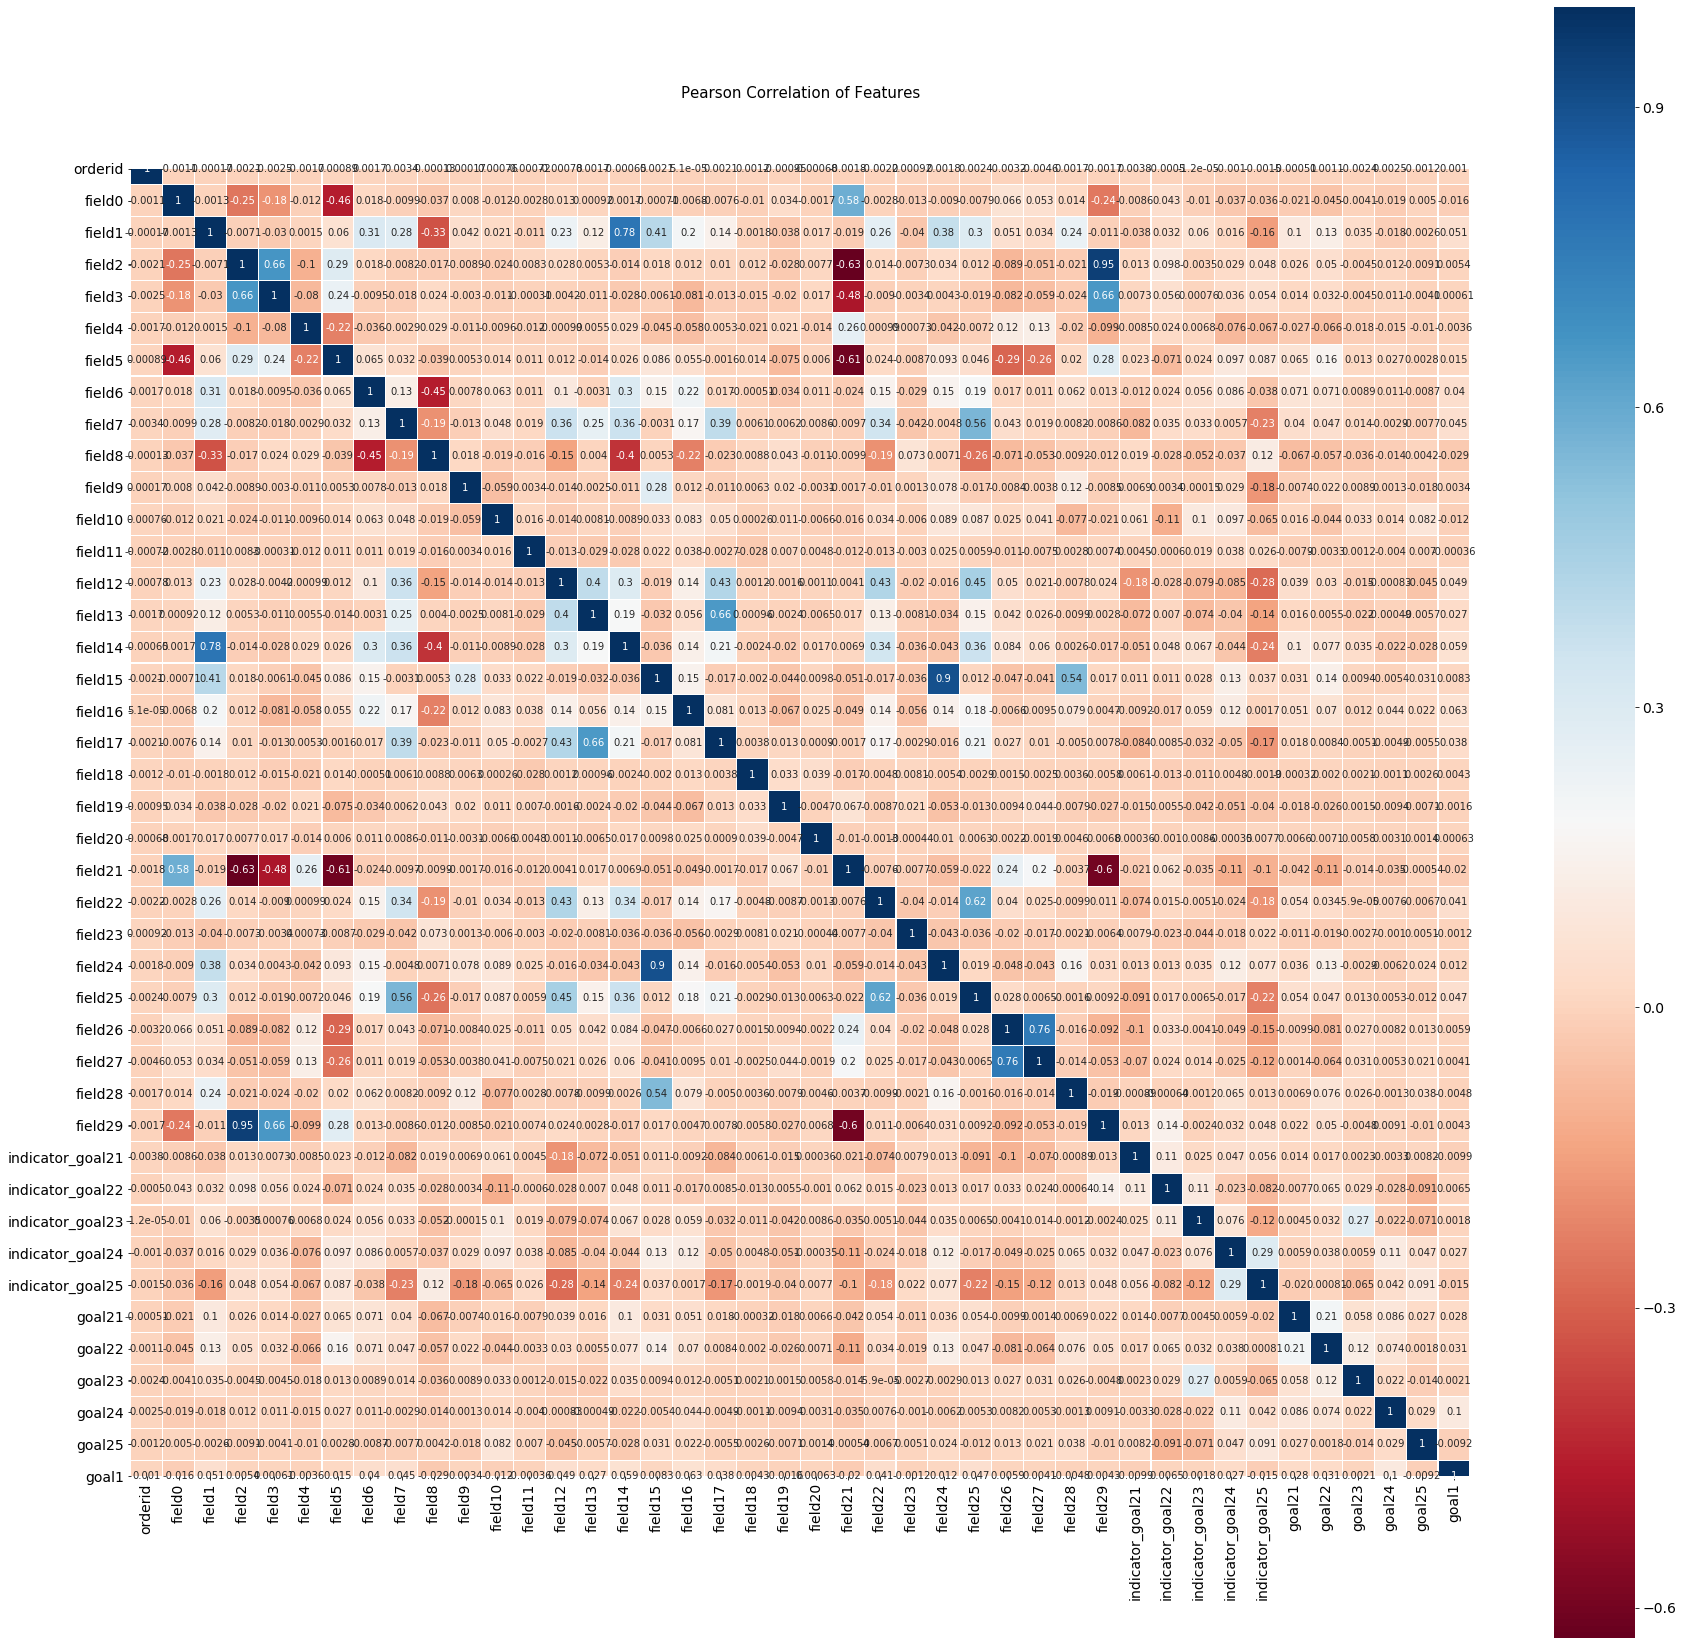

In [73]:
colormap = plt.cm.RdBu
plt.figure(figsize=(30,30))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_train.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

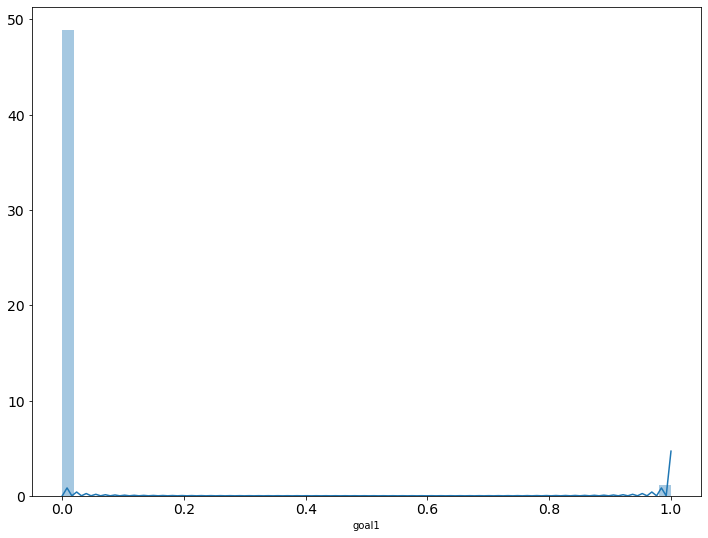

In [74]:
sns.distplot(data_train['goal1']);

findfont: Font family ['Vernada'] not found. Falling back to DejaVu Sans.


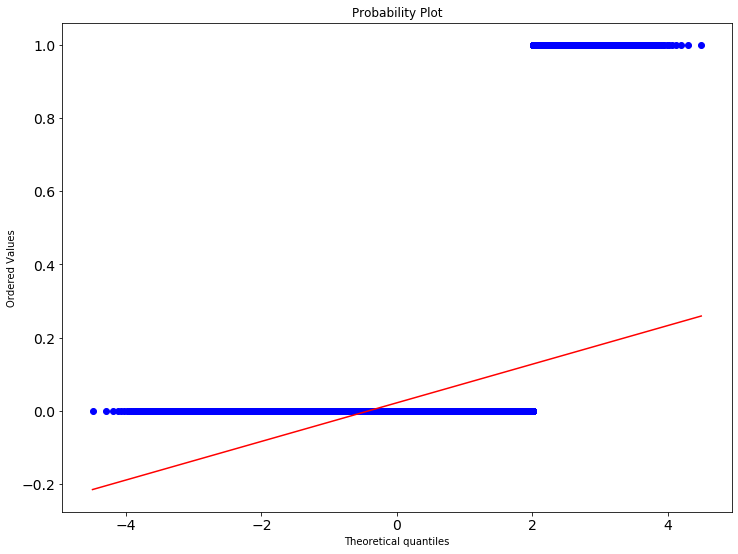

In [77]:
fig = plt.figure()
res = stats.probplot(data_train['goal1'], plot=plt)
plt.show()

In [78]:
#skewness and kurtosis
print("Skewness: %f" % data_train['goal1'].skew())
print("Kurtosis: %f" % data_train['goal1'].kurt())

Skewness: 6.495158
Kurtosis: 40.187486


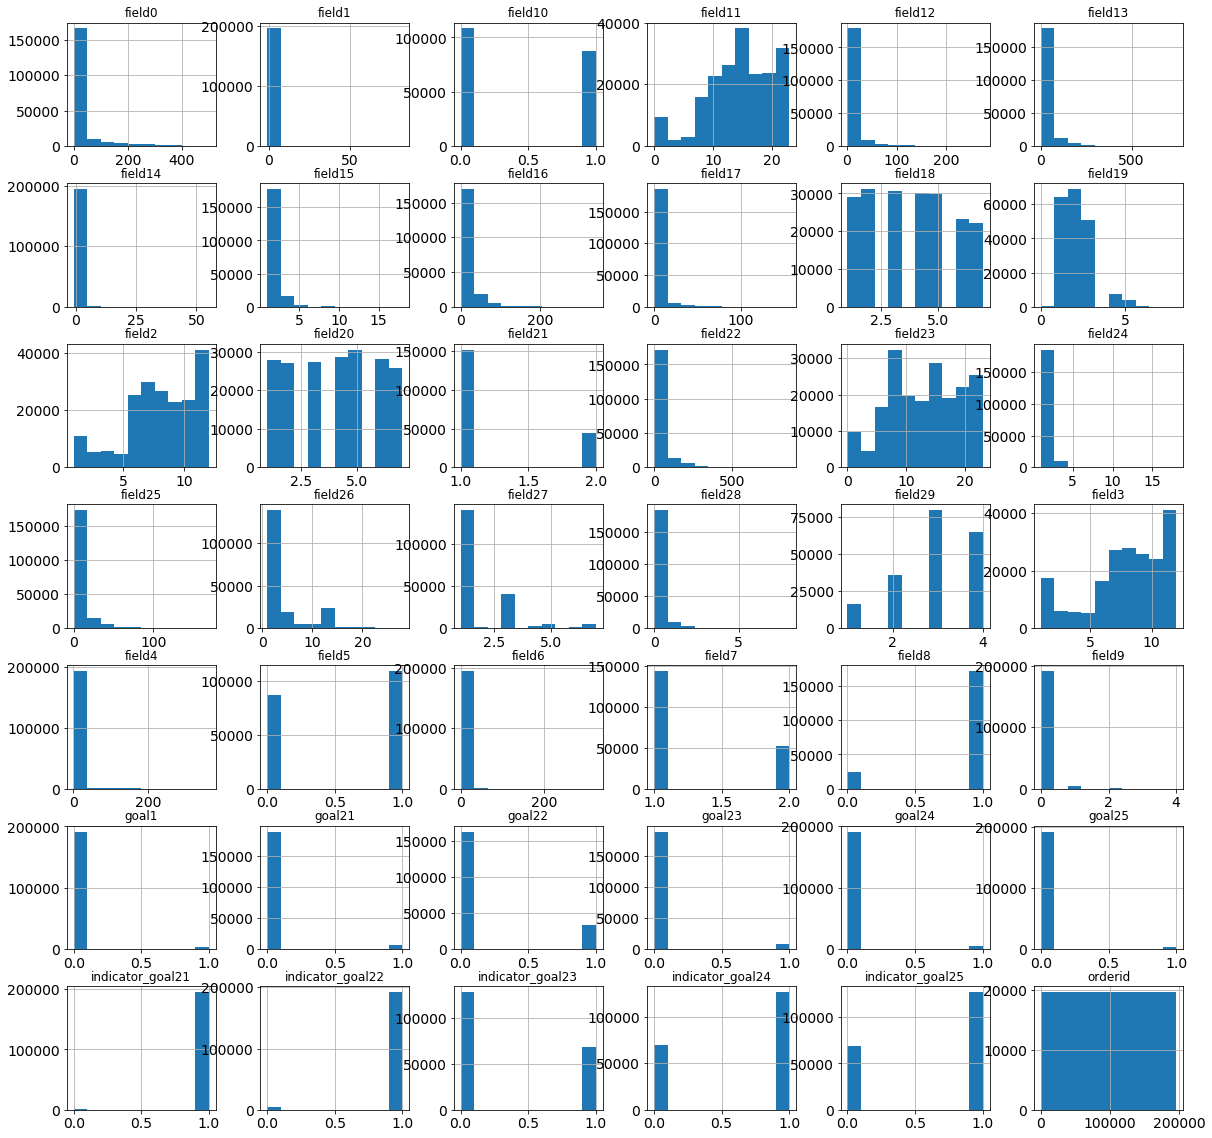

In [79]:
features = list(set(data_train.columns))

data_train[features].hist(figsize=(20,20));

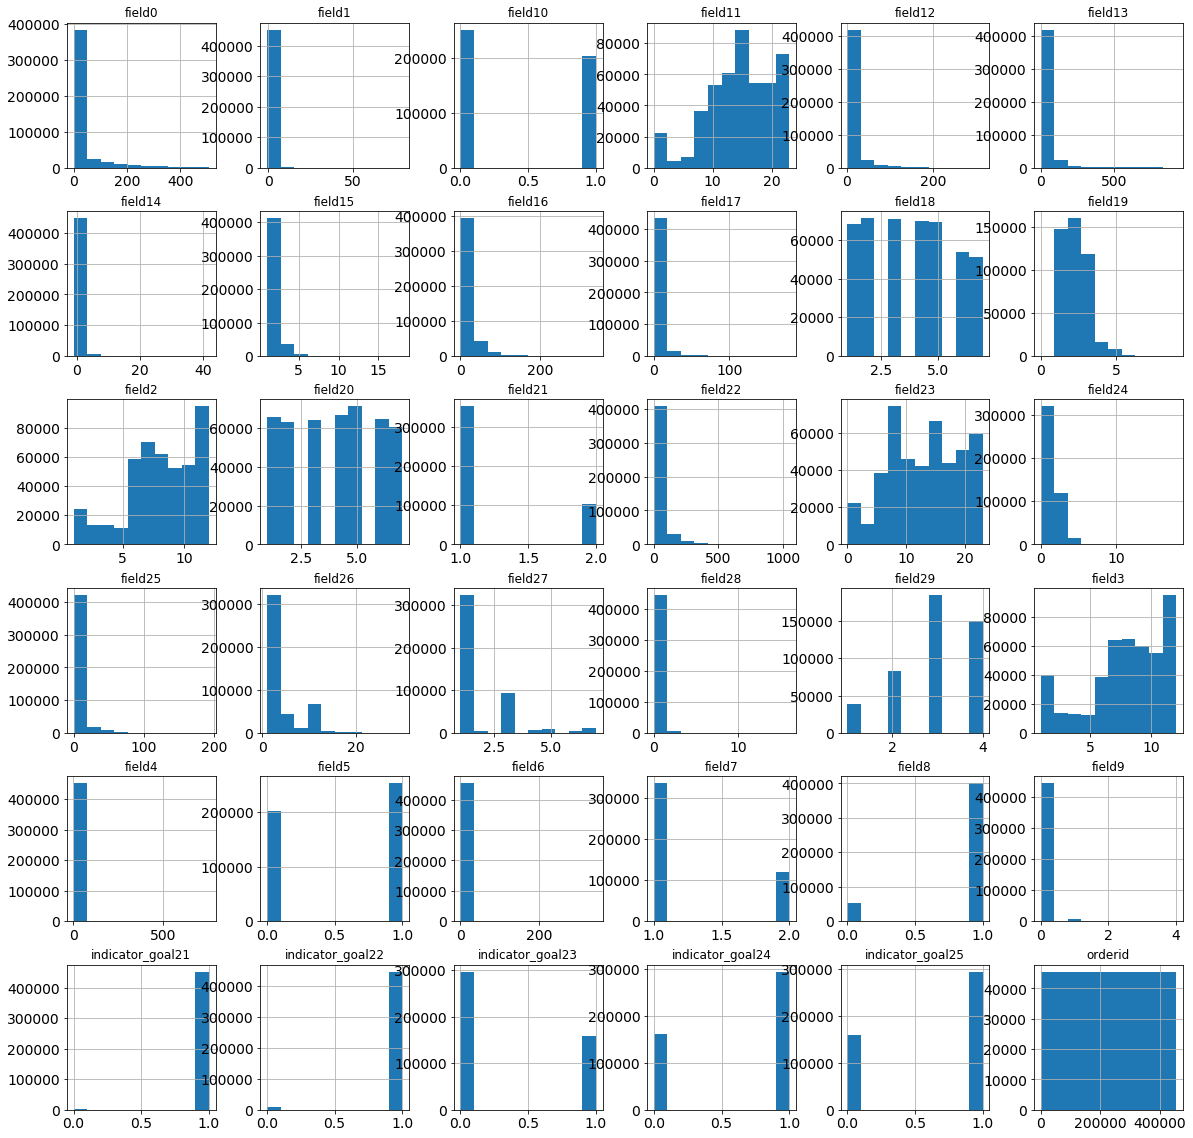

In [81]:
features = list(set(data_test.columns))

data_test[features].hist(figsize=(20,20));

In [80]:
data_train.corr()['goal1'].sort_values()

field8             -0.028664
field21            -0.020217
field0             -0.016298
indicator_goal25   -0.014630
field10            -0.011799
indicator_goal21   -0.009867
goal25             -0.009250
field28            -0.004827
field4             -0.003554
field19            -0.001578
field23            -0.001217
field11            -0.000356
field3              0.000605
field20             0.000633
orderid             0.001049
indicator_goal23    0.001847
goal23              0.002146
field9              0.003393
field27             0.004135
field29             0.004306
field18             0.004332
field2              0.005422
field26             0.005943
indicator_goal22    0.006468
field15             0.008260
field24             0.011594
field5              0.014615
field13             0.027147
indicator_goal24    0.027235
goal21              0.028418
goal22              0.031314
field17             0.037896
field6              0.040037
field22             0.040529
field7        

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_train, y, test_size=0.2, random_state=1)

## Построение моделей с наилучшими параметрами

### RandomForestClassifier

In [180]:
clf1 = RandomForestClassifier(max_features=2, n_estimators=188, oob_score=False, warm_start=True, random_state=1)
roc_auc_score(y_test, clf1.fit(X_train, y_train).predict_proba(X_test)[:, 1])

0.6469794503974226

In [176]:
model_params1 = {
                "criterion": ["gini", "entropy"],
                "min_samples_leaf": randint(1, 9),
                # randomly sample numbers from 4 to 204 estimators
                'n_estimators': randint(4,800),
                # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
                'max_features': randint(1, 5),
                # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
#                 'min_samples_split': uniform(0.01, 0.9),
                'max_depth': randint(2, 5),
#                 'n_jobs': -1,
#                 'warm_start' : True
               }

In [177]:
clf1 = RandomForestClassifier(random_state=1, n_jobs = -1, warm_start = True)
# roc_auc_score(y_test, clf1.fit(X_train, y_train).predict_proba(X_test)[:, 1])

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (500 models total)
clf1_ = RandomizedSearchCV(clf1, model_params1, n_iter=100,  random_state=1)

# train the random search meta-estimator to find the best model out of 100 candidates
clf1_model = clf1_.fit(X_train, y_train)

# print winning set of hyperparameters
pprint(clf1_model.best_estimator_.get_params())
print(roc_auc_score(y_test, clf1_model.predict_proba(X_test)[:, 1]))

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 2,
 'max_features': 1,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 719,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': True}
0.6502948511809864


In [16]:
clf1 = RandomForestClassifier(bootstrap = True,
                             class_weight= None,
                             criterion = 'entropy',
                             max_depth = 2,
                             max_features = 1,
                             max_leaf_nodes =None,
                             min_impurity_decrease = 0.0,
                             min_impurity_split = None,
                             min_samples_leaf = 8,
                             min_samples_split =  2,
                             min_weight_fraction_leaf =  0.0,
                             n_estimators = 719,
                             n_jobs = -1,
                             oob_score = False,
                             random_state =  1,
                             verbose = 0,
                             warm_start = True
                            )
roc_auc_score(y_test, clf1.fit(X_train, y_train).predict_proba(X_test)[:, 1])

0.6502948511809864

### CatBoost

In [13]:
clf2 = CatBoostClassifier(iterations=1000, 
                           devices='0:1',
                          )

In [12]:

print("Accuracy: %0.2f (+/- %0.2f)" % 
      (cross_val_score(clf2, data_train, y, cv=14).mean(), 
            cross_val_score(clf2, data_train, y, cv=14).std() * 2))

# roc_auc_score(y_test, clf2.fit(X_train, y_train).predict_proba(X_test)[:, 1])

NameError: name 'X_train' is not defined

In [171]:
for i in [1,2,3,4,5,6,7,8,9]:
    clf2 = CatBoostClassifier( iterations=1000, devices='0:1', max_depth = i)
    print(roc_auc_score(y_test, clf2.fit(X_train, y_train).predict_proba(X_test)[:, 1]), i)


Learning rate set to 0.070055
0:	learn: 0.5749569	total: 59ms	remaining: 59s
1:	learn: 0.4806586	total: 116ms	remaining: 58s
2:	learn: 0.4057936	total: 183ms	remaining: 1m
3:	learn: 0.3468632	total: 252ms	remaining: 1m 2s
4:	learn: 0.2995556	total: 309ms	remaining: 1m 1s
5:	learn: 0.2623802	total: 402ms	remaining: 1m 6s
6:	learn: 0.2322000	total: 477ms	remaining: 1m 7s
7:	learn: 0.2087843	total: 538ms	remaining: 1m 6s
8:	learn: 0.1900201	total: 596ms	remaining: 1m 5s
9:	learn: 0.1749655	total: 687ms	remaining: 1m 7s
10:	learn: 0.1628109	total: 814ms	remaining: 1m 13s
11:	learn: 0.1529364	total: 883ms	remaining: 1m 12s
12:	learn: 0.1444521	total: 954ms	remaining: 1m 12s
13:	learn: 0.1379482	total: 1.01s	remaining: 1m 10s
14:	learn: 0.1326121	total: 1.06s	remaining: 1m 9s
15:	learn: 0.1282334	total: 1.12s	remaining: 1m 8s
16:	learn: 0.1242639	total: 1.23s	remaining: 1m 11s
17:	learn: 0.1212750	total: 1.33s	remaining: 1m 12s
18:	learn: 0.1187834	total: 1.39s	remaining: 1m 11s
19:	learn: 0

160:	learn: 0.1021641	total: 14.6s	remaining: 1m 16s
161:	learn: 0.1021635	total: 14.7s	remaining: 1m 15s
162:	learn: 0.1021543	total: 14.7s	remaining: 1m 15s
163:	learn: 0.1021521	total: 14.8s	remaining: 1m 15s
164:	learn: 0.1021412	total: 14.9s	remaining: 1m 15s
165:	learn: 0.1021396	total: 14.9s	remaining: 1m 14s
166:	learn: 0.1021295	total: 15s	remaining: 1m 14s
167:	learn: 0.1021226	total: 15s	remaining: 1m 14s
168:	learn: 0.1021221	total: 15.1s	remaining: 1m 14s
169:	learn: 0.1021205	total: 15.2s	remaining: 1m 14s
170:	learn: 0.1021123	total: 15.2s	remaining: 1m 13s
171:	learn: 0.1021108	total: 15.3s	remaining: 1m 13s
172:	learn: 0.1021016	total: 15.3s	remaining: 1m 13s
173:	learn: 0.1020925	total: 15.4s	remaining: 1m 13s
174:	learn: 0.1020914	total: 15.5s	remaining: 1m 12s
175:	learn: 0.1020897	total: 15.5s	remaining: 1m 12s
176:	learn: 0.1020812	total: 15.6s	remaining: 1m 12s
177:	learn: 0.1020797	total: 15.6s	remaining: 1m 12s
178:	learn: 0.1020707	total: 15.7s	remaining: 1m 1

319:	learn: 0.1016501	total: 31s	remaining: 1m 5s
320:	learn: 0.1016494	total: 31.1s	remaining: 1m 5s
321:	learn: 0.1016478	total: 31.2s	remaining: 1m 5s
322:	learn: 0.1016470	total: 31.2s	remaining: 1m 5s
323:	learn: 0.1016455	total: 31.3s	remaining: 1m 5s
324:	learn: 0.1016423	total: 31.3s	remaining: 1m 5s
325:	learn: 0.1016396	total: 31.5s	remaining: 1m 5s
326:	learn: 0.1016388	total: 31.6s	remaining: 1m 5s
327:	learn: 0.1016352	total: 31.7s	remaining: 1m 4s
328:	learn: 0.1016349	total: 32s	remaining: 1m 5s
329:	learn: 0.1016324	total: 32.1s	remaining: 1m 5s
330:	learn: 0.1016291	total: 32.2s	remaining: 1m 5s
331:	learn: 0.1016261	total: 32.2s	remaining: 1m 4s
332:	learn: 0.1016251	total: 32.4s	remaining: 1m 4s
333:	learn: 0.1016223	total: 32.5s	remaining: 1m 4s
334:	learn: 0.1016219	total: 32.8s	remaining: 1m 5s
335:	learn: 0.1016187	total: 32.8s	remaining: 1m 4s
336:	learn: 0.1016176	total: 32.9s	remaining: 1m 4s
337:	learn: 0.1016136	total: 32.9s	remaining: 1m 4s
338:	learn: 0.10

478:	learn: 0.1014088	total: 43.8s	remaining: 47.7s
479:	learn: 0.1014067	total: 43.9s	remaining: 47.5s
480:	learn: 0.1014057	total: 43.9s	remaining: 47.4s
481:	learn: 0.1014048	total: 44s	remaining: 47.3s
482:	learn: 0.1014046	total: 44.1s	remaining: 47.2s
483:	learn: 0.1014042	total: 44.1s	remaining: 47s
484:	learn: 0.1014038	total: 44.2s	remaining: 46.9s
485:	learn: 0.1014030	total: 44.3s	remaining: 46.8s
486:	learn: 0.1014025	total: 44.5s	remaining: 46.9s
487:	learn: 0.1013982	total: 44.6s	remaining: 46.8s
488:	learn: 0.1013961	total: 44.6s	remaining: 46.6s
489:	learn: 0.1013940	total: 44.7s	remaining: 46.5s
490:	learn: 0.1013936	total: 44.7s	remaining: 46.4s
491:	learn: 0.1013916	total: 44.8s	remaining: 46.3s
492:	learn: 0.1013909	total: 44.9s	remaining: 46.1s
493:	learn: 0.1013893	total: 44.9s	remaining: 46s
494:	learn: 0.1013875	total: 45.2s	remaining: 46.1s
495:	learn: 0.1013855	total: 45.3s	remaining: 46.1s
496:	learn: 0.1013834	total: 45.5s	remaining: 46s
497:	learn: 0.101381

637:	learn: 0.1012533	total: 55.6s	remaining: 31.6s
638:	learn: 0.1012528	total: 55.7s	remaining: 31.5s
639:	learn: 0.1012525	total: 55.8s	remaining: 31.4s
640:	learn: 0.1012510	total: 55.8s	remaining: 31.3s
641:	learn: 0.1012506	total: 56.2s	remaining: 31.3s
642:	learn: 0.1012503	total: 56.3s	remaining: 31.2s
643:	learn: 0.1012500	total: 56.3s	remaining: 31.1s
644:	learn: 0.1012498	total: 56.4s	remaining: 31s
645:	learn: 0.1012494	total: 56.6s	remaining: 31s
646:	learn: 0.1012491	total: 56.9s	remaining: 31s
647:	learn: 0.1012489	total: 57.1s	remaining: 31s
648:	learn: 0.1012474	total: 57.4s	remaining: 31s
649:	learn: 0.1012469	total: 57.5s	remaining: 30.9s
650:	learn: 0.1012459	total: 57.7s	remaining: 30.9s
651:	learn: 0.1012455	total: 58s	remaining: 30.9s
652:	learn: 0.1012452	total: 58s	remaining: 30.8s
653:	learn: 0.1012445	total: 58.1s	remaining: 30.7s
654:	learn: 0.1012431	total: 58.1s	remaining: 30.6s
655:	learn: 0.1012416	total: 58.2s	remaining: 30.5s
656:	learn: 0.1012412	tota

798:	learn: 0.1011410	total: 1m 12s	remaining: 18.1s
799:	learn: 0.1011407	total: 1m 13s	remaining: 18.3s
800:	learn: 0.1011399	total: 1m 13s	remaining: 18.2s
801:	learn: 0.1011396	total: 1m 13s	remaining: 18.1s
802:	learn: 0.1011383	total: 1m 13s	remaining: 18s
803:	learn: 0.1011370	total: 1m 13s	remaining: 17.9s
804:	learn: 0.1011368	total: 1m 13s	remaining: 17.8s
805:	learn: 0.1011356	total: 1m 14s	remaining: 17.9s
806:	learn: 0.1011352	total: 1m 14s	remaining: 17.8s
807:	learn: 0.1011350	total: 1m 14s	remaining: 17.7s
808:	learn: 0.1011339	total: 1m 15s	remaining: 17.8s
809:	learn: 0.1011327	total: 1m 15s	remaining: 17.7s
810:	learn: 0.1011324	total: 1m 15s	remaining: 17.6s
811:	learn: 0.1011314	total: 1m 15s	remaining: 17.6s
812:	learn: 0.1011312	total: 1m 15s	remaining: 17.5s
813:	learn: 0.1011298	total: 1m 16s	remaining: 17.4s
814:	learn: 0.1011290	total: 1m 16s	remaining: 17.3s
815:	learn: 0.1011287	total: 1m 16s	remaining: 17.3s
816:	learn: 0.1011281	total: 1m 16s	remaining: 1

953:	learn: 0.1010411	total: 1m 29s	remaining: 4.33s
954:	learn: 0.1010405	total: 1m 29s	remaining: 4.24s
955:	learn: 0.1010402	total: 1m 30s	remaining: 4.14s
956:	learn: 0.1010394	total: 1m 30s	remaining: 4.05s
957:	learn: 0.1010383	total: 1m 30s	remaining: 3.95s
958:	learn: 0.1010381	total: 1m 30s	remaining: 3.86s
959:	learn: 0.1010379	total: 1m 30s	remaining: 3.77s
960:	learn: 0.1010367	total: 1m 30s	remaining: 3.67s
961:	learn: 0.1010362	total: 1m 30s	remaining: 3.58s
962:	learn: 0.1010349	total: 1m 30s	remaining: 3.48s
963:	learn: 0.1010347	total: 1m 30s	remaining: 3.39s
964:	learn: 0.1010346	total: 1m 30s	remaining: 3.29s
965:	learn: 0.1010345	total: 1m 31s	remaining: 3.2s
966:	learn: 0.1010340	total: 1m 31s	remaining: 3.11s
967:	learn: 0.1010337	total: 1m 31s	remaining: 3.02s
968:	learn: 0.1010329	total: 1m 31s	remaining: 2.92s
969:	learn: 0.1010326	total: 1m 31s	remaining: 2.83s
970:	learn: 0.1010323	total: 1m 32s	remaining: 2.76s
971:	learn: 0.1010318	total: 1m 32s	remaining: 

110:	learn: 0.1018653	total: 12s	remaining: 1m 36s
111:	learn: 0.1018603	total: 12.1s	remaining: 1m 35s
112:	learn: 0.1018596	total: 12.2s	remaining: 1m 35s
113:	learn: 0.1018536	total: 12.2s	remaining: 1m 35s
114:	learn: 0.1018479	total: 12.3s	remaining: 1m 34s
115:	learn: 0.1018437	total: 12.4s	remaining: 1m 34s
116:	learn: 0.1018425	total: 12.5s	remaining: 1m 34s
117:	learn: 0.1018369	total: 12.6s	remaining: 1m 33s
118:	learn: 0.1018306	total: 12.6s	remaining: 1m 33s
119:	learn: 0.1018239	total: 12.7s	remaining: 1m 33s
120:	learn: 0.1018158	total: 12.8s	remaining: 1m 33s
121:	learn: 0.1018050	total: 12.9s	remaining: 1m 32s
122:	learn: 0.1017968	total: 13s	remaining: 1m 32s
123:	learn: 0.1017813	total: 13.1s	remaining: 1m 32s
124:	learn: 0.1017767	total: 13.1s	remaining: 1m 31s
125:	learn: 0.1017644	total: 13.2s	remaining: 1m 31s
126:	learn: 0.1017502	total: 13.2s	remaining: 1m 31s
127:	learn: 0.1017473	total: 13.4s	remaining: 1m 30s
128:	learn: 0.1017427	total: 13.5s	remaining: 1m 3

267:	learn: 0.1009521	total: 25s	remaining: 1m 8s
268:	learn: 0.1009472	total: 25s	remaining: 1m 8s
269:	learn: 0.1009431	total: 25.1s	remaining: 1m 7s
270:	learn: 0.1009403	total: 25.2s	remaining: 1m 7s
271:	learn: 0.1009372	total: 25.2s	remaining: 1m 7s
272:	learn: 0.1009315	total: 25.3s	remaining: 1m 7s
273:	learn: 0.1009271	total: 25.4s	remaining: 1m 7s
274:	learn: 0.1009252	total: 25.4s	remaining: 1m 7s
275:	learn: 0.1009218	total: 25.5s	remaining: 1m 6s
276:	learn: 0.1009135	total: 25.6s	remaining: 1m 6s
277:	learn: 0.1009122	total: 25.7s	remaining: 1m 6s
278:	learn: 0.1009107	total: 25.7s	remaining: 1m 6s
279:	learn: 0.1009071	total: 25.8s	remaining: 1m 6s
280:	learn: 0.1009043	total: 25.9s	remaining: 1m 6s
281:	learn: 0.1009029	total: 25.9s	remaining: 1m 6s
282:	learn: 0.1008957	total: 26s	remaining: 1m 5s
283:	learn: 0.1008907	total: 26.1s	remaining: 1m 5s
284:	learn: 0.1008887	total: 26.1s	remaining: 1m 5s
285:	learn: 0.1008877	total: 26.2s	remaining: 1m 5s
286:	learn: 0.1008

426:	learn: 0.1003366	total: 36.9s	remaining: 49.5s
427:	learn: 0.1003334	total: 37s	remaining: 49.5s
428:	learn: 0.1003301	total: 37.2s	remaining: 49.5s
429:	learn: 0.1003256	total: 37.3s	remaining: 49.4s
430:	learn: 0.1003253	total: 37.3s	remaining: 49.3s
431:	learn: 0.1003198	total: 37.4s	remaining: 49.2s
432:	learn: 0.1003156	total: 37.5s	remaining: 49.1s
433:	learn: 0.1003127	total: 37.6s	remaining: 49s
434:	learn: 0.1003082	total: 37.6s	remaining: 48.9s
435:	learn: 0.1003063	total: 37.7s	remaining: 48.8s
436:	learn: 0.1003040	total: 37.8s	remaining: 48.7s
437:	learn: 0.1002987	total: 37.9s	remaining: 48.6s
438:	learn: 0.1002980	total: 37.9s	remaining: 48.5s
439:	learn: 0.1002896	total: 38s	remaining: 48.4s
440:	learn: 0.1002872	total: 38.1s	remaining: 48.3s
441:	learn: 0.1002847	total: 38.2s	remaining: 48.2s
442:	learn: 0.1002766	total: 38.3s	remaining: 48.1s
443:	learn: 0.1002751	total: 38.4s	remaining: 48.1s
444:	learn: 0.1002718	total: 38.5s	remaining: 48s
445:	learn: 0.100268

587:	learn: 0.0998525	total: 52.3s	remaining: 36.7s
588:	learn: 0.0998512	total: 52.4s	remaining: 36.6s
589:	learn: 0.0998499	total: 52.5s	remaining: 36.5s
590:	learn: 0.0998459	total: 52.6s	remaining: 36.4s
591:	learn: 0.0998428	total: 52.7s	remaining: 36.3s
592:	learn: 0.0998420	total: 52.8s	remaining: 36.2s
593:	learn: 0.0998405	total: 52.9s	remaining: 36.1s
594:	learn: 0.0998399	total: 53s	remaining: 36.1s
595:	learn: 0.0998365	total: 53s	remaining: 36s
596:	learn: 0.0998318	total: 53.1s	remaining: 35.9s
597:	learn: 0.0998294	total: 53.2s	remaining: 35.8s
598:	learn: 0.0998276	total: 53.3s	remaining: 35.7s
599:	learn: 0.0998252	total: 53.4s	remaining: 35.6s
600:	learn: 0.0998137	total: 53.4s	remaining: 35.5s
601:	learn: 0.0998115	total: 53.5s	remaining: 35.4s
602:	learn: 0.0998082	total: 53.6s	remaining: 35.3s
603:	learn: 0.0998054	total: 53.7s	remaining: 35.2s
604:	learn: 0.0997978	total: 53.8s	remaining: 35.1s
605:	learn: 0.0997957	total: 53.9s	remaining: 35s
606:	learn: 0.099791

748:	learn: 0.0994692	total: 1m 6s	remaining: 22.2s
749:	learn: 0.0994635	total: 1m 6s	remaining: 22.1s
750:	learn: 0.0994593	total: 1m 6s	remaining: 22.1s
751:	learn: 0.0994566	total: 1m 6s	remaining: 22s
752:	learn: 0.0994516	total: 1m 6s	remaining: 21.9s
753:	learn: 0.0994509	total: 1m 6s	remaining: 21.8s
754:	learn: 0.0994508	total: 1m 6s	remaining: 21.7s
755:	learn: 0.0994483	total: 1m 6s	remaining: 21.6s
756:	learn: 0.0994440	total: 1m 7s	remaining: 21.5s
757:	learn: 0.0994421	total: 1m 7s	remaining: 21.4s
758:	learn: 0.0994390	total: 1m 7s	remaining: 21.3s
759:	learn: 0.0994367	total: 1m 7s	remaining: 21.2s
760:	learn: 0.0994350	total: 1m 7s	remaining: 21.1s
761:	learn: 0.0994336	total: 1m 7s	remaining: 21.1s
762:	learn: 0.0994315	total: 1m 7s	remaining: 21s
763:	learn: 0.0994303	total: 1m 7s	remaining: 20.9s
764:	learn: 0.0994281	total: 1m 7s	remaining: 20.8s
765:	learn: 0.0994256	total: 1m 7s	remaining: 20.7s
766:	learn: 0.0994255	total: 1m 7s	remaining: 20.6s
767:	learn: 0.09

905:	learn: 0.0991162	total: 1m 17s	remaining: 8.08s
906:	learn: 0.0991144	total: 1m 17s	remaining: 8s
907:	learn: 0.0991135	total: 1m 18s	remaining: 7.91s
908:	learn: 0.0991111	total: 1m 18s	remaining: 7.82s
909:	learn: 0.0991102	total: 1m 18s	remaining: 7.73s
910:	learn: 0.0991101	total: 1m 18s	remaining: 7.64s
911:	learn: 0.0991095	total: 1m 18s	remaining: 7.56s
912:	learn: 0.0991080	total: 1m 18s	remaining: 7.47s
913:	learn: 0.0991055	total: 1m 18s	remaining: 7.38s
914:	learn: 0.0991042	total: 1m 18s	remaining: 7.3s
915:	learn: 0.0991033	total: 1m 18s	remaining: 7.21s
916:	learn: 0.0991010	total: 1m 18s	remaining: 7.12s
917:	learn: 0.0990985	total: 1m 18s	remaining: 7.03s
918:	learn: 0.0990976	total: 1m 18s	remaining: 6.95s
919:	learn: 0.0990947	total: 1m 18s	remaining: 6.86s
920:	learn: 0.0990932	total: 1m 18s	remaining: 6.77s
921:	learn: 0.0990906	total: 1m 19s	remaining: 6.69s
922:	learn: 0.0990889	total: 1m 19s	remaining: 6.6s
923:	learn: 0.0990841	total: 1m 19s	remaining: 6.51

61:	learn: 0.1021183	total: 4.92s	remaining: 1m 14s
62:	learn: 0.1021036	total: 5s	remaining: 1m 14s
63:	learn: 0.1020644	total: 5.06s	remaining: 1m 14s
64:	learn: 0.1020302	total: 5.14s	remaining: 1m 13s
65:	learn: 0.1020080	total: 5.22s	remaining: 1m 13s
66:	learn: 0.1019920	total: 5.29s	remaining: 1m 13s
67:	learn: 0.1019890	total: 5.36s	remaining: 1m 13s
68:	learn: 0.1019760	total: 5.44s	remaining: 1m 13s
69:	learn: 0.1019557	total: 5.51s	remaining: 1m 13s
70:	learn: 0.1019424	total: 5.59s	remaining: 1m 13s
71:	learn: 0.1019335	total: 5.67s	remaining: 1m 13s
72:	learn: 0.1019207	total: 5.74s	remaining: 1m 12s
73:	learn: 0.1019105	total: 5.83s	remaining: 1m 12s
74:	learn: 0.1019008	total: 5.9s	remaining: 1m 12s
75:	learn: 0.1018935	total: 5.97s	remaining: 1m 12s
76:	learn: 0.1018674	total: 6.03s	remaining: 1m 12s
77:	learn: 0.1018570	total: 6.11s	remaining: 1m 12s
78:	learn: 0.1018379	total: 6.19s	remaining: 1m 12s
79:	learn: 0.1018065	total: 6.27s	remaining: 1m 12s
80:	learn: 0.101

219:	learn: 0.1004200	total: 19s	remaining: 1m 7s
220:	learn: 0.1004103	total: 19.1s	remaining: 1m 7s
221:	learn: 0.1003985	total: 19.2s	remaining: 1m 7s
222:	learn: 0.1003946	total: 19.3s	remaining: 1m 7s
223:	learn: 0.1003871	total: 19.4s	remaining: 1m 7s
224:	learn: 0.1003862	total: 19.4s	remaining: 1m 6s
225:	learn: 0.1003767	total: 19.5s	remaining: 1m 6s
226:	learn: 0.1003668	total: 19.6s	remaining: 1m 6s
227:	learn: 0.1003617	total: 19.7s	remaining: 1m 6s
228:	learn: 0.1003563	total: 19.7s	remaining: 1m 6s
229:	learn: 0.1003489	total: 19.8s	remaining: 1m 6s
230:	learn: 0.1003388	total: 19.9s	remaining: 1m 6s
231:	learn: 0.1003326	total: 20s	remaining: 1m 6s
232:	learn: 0.1003285	total: 20s	remaining: 1m 5s
233:	learn: 0.1003157	total: 20.1s	remaining: 1m 5s
234:	learn: 0.1003073	total: 20.2s	remaining: 1m 5s
235:	learn: 0.1002987	total: 20.3s	remaining: 1m 5s
236:	learn: 0.1002903	total: 20.3s	remaining: 1m 5s
237:	learn: 0.1002804	total: 20.4s	remaining: 1m 5s
238:	learn: 0.1002

381:	learn: 0.0994048	total: 33.7s	remaining: 54.5s
382:	learn: 0.0994045	total: 33.7s	remaining: 54.4s
383:	learn: 0.0993890	total: 33.8s	remaining: 54.3s
384:	learn: 0.0993826	total: 33.9s	remaining: 54.1s
385:	learn: 0.0993760	total: 34s	remaining: 54s
386:	learn: 0.0993730	total: 34.1s	remaining: 53.9s
387:	learn: 0.0993708	total: 34.1s	remaining: 53.8s
388:	learn: 0.0993652	total: 34.2s	remaining: 53.7s
389:	learn: 0.0993636	total: 34.3s	remaining: 53.6s
390:	learn: 0.0993618	total: 34.4s	remaining: 53.5s
391:	learn: 0.0993605	total: 34.5s	remaining: 53.5s
392:	learn: 0.0993537	total: 34.6s	remaining: 53.4s
393:	learn: 0.0993525	total: 34.7s	remaining: 53.3s
394:	learn: 0.0993470	total: 34.8s	remaining: 53.3s
395:	learn: 0.0993378	total: 34.9s	remaining: 53.2s
396:	learn: 0.0993308	total: 35s	remaining: 53.1s
397:	learn: 0.0993261	total: 35.1s	remaining: 53s
398:	learn: 0.0993160	total: 35.2s	remaining: 52.9s
399:	learn: 0.0993113	total: 35.2s	remaining: 52.9s
400:	learn: 0.099310

542:	learn: 0.0985878	total: 47.3s	remaining: 39.8s
543:	learn: 0.0985853	total: 47.3s	remaining: 39.7s
544:	learn: 0.0985789	total: 47.4s	remaining: 39.6s
545:	learn: 0.0985747	total: 47.5s	remaining: 39.5s
546:	learn: 0.0985734	total: 47.6s	remaining: 39.4s
547:	learn: 0.0985680	total: 47.6s	remaining: 39.3s
548:	learn: 0.0985667	total: 47.7s	remaining: 39.2s
549:	learn: 0.0985620	total: 47.8s	remaining: 39.1s
550:	learn: 0.0985546	total: 47.9s	remaining: 39s
551:	learn: 0.0985533	total: 48s	remaining: 38.9s
552:	learn: 0.0985531	total: 48s	remaining: 38.8s
553:	learn: 0.0985493	total: 48.1s	remaining: 38.7s
554:	learn: 0.0985435	total: 48.2s	remaining: 38.6s
555:	learn: 0.0985335	total: 48.3s	remaining: 38.5s
556:	learn: 0.0985250	total: 48.3s	remaining: 38.5s
557:	learn: 0.0985230	total: 48.4s	remaining: 38.4s
558:	learn: 0.0985207	total: 48.5s	remaining: 38.3s
559:	learn: 0.0985173	total: 48.6s	remaining: 38.2s
560:	learn: 0.0985155	total: 48.6s	remaining: 38.1s
561:	learn: 0.0985

701:	learn: 0.0978586	total: 59.5s	remaining: 25.3s
702:	learn: 0.0978560	total: 59.6s	remaining: 25.2s
703:	learn: 0.0978479	total: 59.6s	remaining: 25.1s
704:	learn: 0.0978405	total: 59.7s	remaining: 25s
705:	learn: 0.0978356	total: 59.8s	remaining: 24.9s
706:	learn: 0.0978349	total: 59.9s	remaining: 24.8s
707:	learn: 0.0978293	total: 60s	remaining: 24.7s
708:	learn: 0.0978262	total: 1m	remaining: 24.6s
709:	learn: 0.0978206	total: 1m	remaining: 24.6s
710:	learn: 0.0978174	total: 1m	remaining: 24.5s
711:	learn: 0.0978141	total: 1m	remaining: 24.4s
712:	learn: 0.0978080	total: 1m	remaining: 24.3s
713:	learn: 0.0978037	total: 1m	remaining: 24.2s
714:	learn: 0.0977985	total: 1m	remaining: 24.1s
715:	learn: 0.0977942	total: 1m	remaining: 24s
716:	learn: 0.0977933	total: 1m	remaining: 23.9s
717:	learn: 0.0977892	total: 1m	remaining: 23.8s
718:	learn: 0.0977857	total: 1m	remaining: 23.8s
719:	learn: 0.0977813	total: 1m	remaining: 23.7s
720:	learn: 0.0977785	total: 1m 1s	remaining: 23.6s
72

860:	learn: 0.0971775	total: 1m 13s	remaining: 11.9s
861:	learn: 0.0971654	total: 1m 13s	remaining: 11.8s
862:	learn: 0.0971583	total: 1m 13s	remaining: 11.7s
863:	learn: 0.0971560	total: 1m 14s	remaining: 11.6s
864:	learn: 0.0971554	total: 1m 14s	remaining: 11.6s
865:	learn: 0.0971517	total: 1m 14s	remaining: 11.5s
866:	learn: 0.0971506	total: 1m 14s	remaining: 11.4s
867:	learn: 0.0971446	total: 1m 14s	remaining: 11.3s
868:	learn: 0.0971419	total: 1m 14s	remaining: 11.2s
869:	learn: 0.0971407	total: 1m 14s	remaining: 11.1s
870:	learn: 0.0971406	total: 1m 14s	remaining: 11s
871:	learn: 0.0971372	total: 1m 14s	remaining: 11s
872:	learn: 0.0971347	total: 1m 14s	remaining: 10.9s
873:	learn: 0.0971284	total: 1m 14s	remaining: 10.8s
874:	learn: 0.0971251	total: 1m 15s	remaining: 10.7s
875:	learn: 0.0971235	total: 1m 15s	remaining: 10.6s
876:	learn: 0.0971147	total: 1m 15s	remaining: 10.6s
877:	learn: 0.0971139	total: 1m 15s	remaining: 10.5s
878:	learn: 0.0971113	total: 1m 15s	remaining: 10.

15:	learn: 0.1268920	total: 1.35s	remaining: 1m 23s
16:	learn: 0.1233177	total: 1.44s	remaining: 1m 22s
17:	learn: 0.1203552	total: 1.51s	remaining: 1m 22s
18:	learn: 0.1175574	total: 1.61s	remaining: 1m 23s
19:	learn: 0.1152928	total: 1.68s	remaining: 1m 22s
20:	learn: 0.1135018	total: 1.77s	remaining: 1m 22s
21:	learn: 0.1119939	total: 1.88s	remaining: 1m 23s
22:	learn: 0.1105756	total: 1.96s	remaining: 1m 23s
23:	learn: 0.1095587	total: 2.03s	remaining: 1m 22s
24:	learn: 0.1086805	total: 2.12s	remaining: 1m 22s
25:	learn: 0.1077718	total: 2.2s	remaining: 1m 22s
26:	learn: 0.1071150	total: 2.29s	remaining: 1m 22s
27:	learn: 0.1065995	total: 2.37s	remaining: 1m 22s
28:	learn: 0.1059699	total: 2.45s	remaining: 1m 22s
29:	learn: 0.1055999	total: 2.53s	remaining: 1m 21s
30:	learn: 0.1052621	total: 2.62s	remaining: 1m 22s
31:	learn: 0.1048351	total: 2.7s	remaining: 1m 21s
32:	learn: 0.1044779	total: 2.78s	remaining: 1m 21s
33:	learn: 0.1041786	total: 2.85s	remaining: 1m 20s
34:	learn: 0.1

173:	learn: 0.1001565	total: 15s	remaining: 1m 11s
174:	learn: 0.1001381	total: 15.1s	remaining: 1m 11s
175:	learn: 0.1001252	total: 15.2s	remaining: 1m 11s
176:	learn: 0.1001158	total: 15.3s	remaining: 1m 11s
177:	learn: 0.1001006	total: 15.4s	remaining: 1m 10s
178:	learn: 0.1000902	total: 15.4s	remaining: 1m 10s
179:	learn: 0.1000800	total: 15.5s	remaining: 1m 10s
180:	learn: 0.1000693	total: 15.8s	remaining: 1m 11s
181:	learn: 0.1000585	total: 15.9s	remaining: 1m 11s
182:	learn: 0.1000498	total: 16s	remaining: 1m 11s
183:	learn: 0.1000366	total: 16.1s	remaining: 1m 11s
184:	learn: 0.1000304	total: 16.2s	remaining: 1m 11s
185:	learn: 0.1000215	total: 16.2s	remaining: 1m 11s
186:	learn: 0.1000130	total: 16.3s	remaining: 1m 10s
187:	learn: 0.0999828	total: 16.4s	remaining: 1m 10s
188:	learn: 0.0999766	total: 16.5s	remaining: 1m 10s
189:	learn: 0.0999672	total: 16.6s	remaining: 1m 10s
190:	learn: 0.0999614	total: 16.7s	remaining: 1m 10s
191:	learn: 0.0999554	total: 16.7s	remaining: 1m 1

333:	learn: 0.0986188	total: 28.2s	remaining: 56.3s
334:	learn: 0.0986112	total: 28.3s	remaining: 56.2s
335:	learn: 0.0985987	total: 28.4s	remaining: 56.1s
336:	learn: 0.0985906	total: 28.5s	remaining: 56s
337:	learn: 0.0985844	total: 28.5s	remaining: 55.9s
338:	learn: 0.0985715	total: 28.6s	remaining: 55.8s
339:	learn: 0.0985654	total: 28.7s	remaining: 55.7s
340:	learn: 0.0985571	total: 28.8s	remaining: 55.6s
341:	learn: 0.0985454	total: 28.9s	remaining: 55.5s
342:	learn: 0.0985322	total: 29s	remaining: 55.5s
343:	learn: 0.0985205	total: 29s	remaining: 55.4s
344:	learn: 0.0985168	total: 29.1s	remaining: 55.3s
345:	learn: 0.0985113	total: 29.2s	remaining: 55.2s
346:	learn: 0.0985045	total: 29.3s	remaining: 55.1s
347:	learn: 0.0984957	total: 29.4s	remaining: 55s
348:	learn: 0.0984925	total: 29.4s	remaining: 54.9s
349:	learn: 0.0984922	total: 29.5s	remaining: 54.8s
350:	learn: 0.0984794	total: 29.6s	remaining: 54.7s
351:	learn: 0.0984725	total: 29.7s	remaining: 54.6s
352:	learn: 0.098469

492:	learn: 0.0973421	total: 41.1s	remaining: 42.3s
493:	learn: 0.0973330	total: 41.2s	remaining: 42.2s
494:	learn: 0.0973293	total: 41.2s	remaining: 42.1s
495:	learn: 0.0973225	total: 41.3s	remaining: 42s
496:	learn: 0.0973164	total: 41.4s	remaining: 41.9s
497:	learn: 0.0972945	total: 41.5s	remaining: 41.8s
498:	learn: 0.0972870	total: 41.6s	remaining: 41.7s
499:	learn: 0.0972760	total: 41.6s	remaining: 41.6s
500:	learn: 0.0972690	total: 41.7s	remaining: 41.6s
501:	learn: 0.0972631	total: 41.8s	remaining: 41.5s
502:	learn: 0.0972543	total: 41.9s	remaining: 41.4s
503:	learn: 0.0972343	total: 42s	remaining: 41.3s
504:	learn: 0.0972217	total: 42.1s	remaining: 41.2s
505:	learn: 0.0972093	total: 42.1s	remaining: 41.1s
506:	learn: 0.0972001	total: 42.2s	remaining: 41s
507:	learn: 0.0971882	total: 42.3s	remaining: 41s
508:	learn: 0.0971785	total: 42.4s	remaining: 40.9s
509:	learn: 0.0971737	total: 42.5s	remaining: 40.8s
510:	learn: 0.0971661	total: 42.6s	remaining: 40.8s
511:	learn: 0.097157

651:	learn: 0.0960698	total: 53.9s	remaining: 28.8s
652:	learn: 0.0960678	total: 54s	remaining: 28.7s
653:	learn: 0.0960596	total: 54.1s	remaining: 28.6s
654:	learn: 0.0960577	total: 54.2s	remaining: 28.5s
655:	learn: 0.0960504	total: 54.2s	remaining: 28.4s
656:	learn: 0.0960406	total: 54.3s	remaining: 28.4s
657:	learn: 0.0960338	total: 54.4s	remaining: 28.3s
658:	learn: 0.0960284	total: 54.5s	remaining: 28.2s
659:	learn: 0.0960211	total: 54.6s	remaining: 28.1s
660:	learn: 0.0960135	total: 54.6s	remaining: 28s
661:	learn: 0.0960117	total: 54.7s	remaining: 27.9s
662:	learn: 0.0960071	total: 54.8s	remaining: 27.9s
663:	learn: 0.0960016	total: 54.9s	remaining: 27.8s
664:	learn: 0.0959940	total: 55s	remaining: 27.7s
665:	learn: 0.0959852	total: 55s	remaining: 27.6s
666:	learn: 0.0959818	total: 55.1s	remaining: 27.5s
667:	learn: 0.0959744	total: 55.2s	remaining: 27.4s
668:	learn: 0.0959719	total: 55.3s	remaining: 27.3s
669:	learn: 0.0959654	total: 55.4s	remaining: 27.3s
670:	learn: 0.095961

813:	learn: 0.0950055	total: 1m 7s	remaining: 15.4s
814:	learn: 0.0950040	total: 1m 7s	remaining: 15.3s
815:	learn: 0.0949957	total: 1m 7s	remaining: 15.3s
816:	learn: 0.0949931	total: 1m 7s	remaining: 15.2s
817:	learn: 0.0949861	total: 1m 7s	remaining: 15.1s
818:	learn: 0.0949790	total: 1m 7s	remaining: 15s
819:	learn: 0.0949670	total: 1m 8s	remaining: 14.9s
820:	learn: 0.0949575	total: 1m 8s	remaining: 14.9s
821:	learn: 0.0949461	total: 1m 8s	remaining: 14.8s
822:	learn: 0.0949379	total: 1m 8s	remaining: 14.7s
823:	learn: 0.0949287	total: 1m 8s	remaining: 14.6s
824:	learn: 0.0949244	total: 1m 8s	remaining: 14.6s
825:	learn: 0.0949139	total: 1m 8s	remaining: 14.5s
826:	learn: 0.0949073	total: 1m 8s	remaining: 14.4s
827:	learn: 0.0949049	total: 1m 9s	remaining: 14.4s
828:	learn: 0.0948986	total: 1m 9s	remaining: 14.3s
829:	learn: 0.0948914	total: 1m 9s	remaining: 14.2s
830:	learn: 0.0948816	total: 1m 9s	remaining: 14.1s
831:	learn: 0.0948766	total: 1m 9s	remaining: 14.1s
832:	learn: 0.

969:	learn: 0.0939861	total: 1m 27s	remaining: 2.69s
970:	learn: 0.0939842	total: 1m 27s	remaining: 2.6s
971:	learn: 0.0939819	total: 1m 27s	remaining: 2.51s
972:	learn: 0.0939768	total: 1m 27s	remaining: 2.42s
973:	learn: 0.0939696	total: 1m 27s	remaining: 2.34s
974:	learn: 0.0939586	total: 1m 27s	remaining: 2.25s
975:	learn: 0.0939543	total: 1m 27s	remaining: 2.16s
976:	learn: 0.0939486	total: 1m 27s	remaining: 2.07s
977:	learn: 0.0939421	total: 1m 27s	remaining: 1.98s
978:	learn: 0.0939368	total: 1m 28s	remaining: 1.89s
979:	learn: 0.0939264	total: 1m 28s	remaining: 1.8s
980:	learn: 0.0939178	total: 1m 28s	remaining: 1.71s
981:	learn: 0.0939165	total: 1m 28s	remaining: 1.62s
982:	learn: 0.0939164	total: 1m 28s	remaining: 1.53s
983:	learn: 0.0939130	total: 1m 28s	remaining: 1.45s
984:	learn: 0.0938996	total: 1m 29s	remaining: 1.35s
985:	learn: 0.0938936	total: 1m 29s	remaining: 1.26s
986:	learn: 0.0938895	total: 1m 29s	remaining: 1.18s
987:	learn: 0.0938854	total: 1m 29s	remaining: 1

127:	learn: 0.0999993	total: 16s	remaining: 1m 49s
128:	learn: 0.0999842	total: 16.1s	remaining: 1m 49s
129:	learn: 0.0999640	total: 16.2s	remaining: 1m 48s
130:	learn: 0.0999449	total: 16.4s	remaining: 1m 48s
131:	learn: 0.0999232	total: 16.4s	remaining: 1m 48s
132:	learn: 0.0999010	total: 16.5s	remaining: 1m 47s
133:	learn: 0.0998893	total: 16.6s	remaining: 1m 47s
134:	learn: 0.0998797	total: 16.7s	remaining: 1m 47s
135:	learn: 0.0998618	total: 16.9s	remaining: 1m 47s
136:	learn: 0.0998358	total: 16.9s	remaining: 1m 46s
137:	learn: 0.0998135	total: 17s	remaining: 1m 46s
138:	learn: 0.0998009	total: 17.1s	remaining: 1m 46s
139:	learn: 0.0997883	total: 17.2s	remaining: 1m 45s
140:	learn: 0.0997827	total: 17.3s	remaining: 1m 45s
141:	learn: 0.0997547	total: 17.4s	remaining: 1m 44s
142:	learn: 0.0997262	total: 17.5s	remaining: 1m 44s
143:	learn: 0.0997217	total: 17.6s	remaining: 1m 44s
144:	learn: 0.0997108	total: 17.7s	remaining: 1m 44s
145:	learn: 0.0996902	total: 17.7s	remaining: 1m 4

284:	learn: 0.0976883	total: 36.1s	remaining: 1m 30s
285:	learn: 0.0976721	total: 36.2s	remaining: 1m 30s
286:	learn: 0.0976537	total: 36.3s	remaining: 1m 30s
287:	learn: 0.0976499	total: 36.5s	remaining: 1m 30s
288:	learn: 0.0976433	total: 36.7s	remaining: 1m 30s
289:	learn: 0.0976410	total: 36.8s	remaining: 1m 30s
290:	learn: 0.0976253	total: 36.9s	remaining: 1m 29s
291:	learn: 0.0976196	total: 37.1s	remaining: 1m 29s
292:	learn: 0.0976105	total: 37.2s	remaining: 1m 29s
293:	learn: 0.0975982	total: 37.4s	remaining: 1m 29s
294:	learn: 0.0975901	total: 37.5s	remaining: 1m 29s
295:	learn: 0.0975852	total: 37.6s	remaining: 1m 29s
296:	learn: 0.0975849	total: 37.8s	remaining: 1m 29s
297:	learn: 0.0975801	total: 38s	remaining: 1m 29s
298:	learn: 0.0975609	total: 38.2s	remaining: 1m 29s
299:	learn: 0.0975534	total: 38.3s	remaining: 1m 29s
300:	learn: 0.0975453	total: 38.4s	remaining: 1m 29s
301:	learn: 0.0975362	total: 38.5s	remaining: 1m 29s
302:	learn: 0.0975240	total: 38.6s	remaining: 1m

441:	learn: 0.0959075	total: 56.5s	remaining: 1m 11s
442:	learn: 0.0958970	total: 56.6s	remaining: 1m 11s
443:	learn: 0.0958821	total: 56.7s	remaining: 1m 11s
444:	learn: 0.0958681	total: 56.8s	remaining: 1m 10s
445:	learn: 0.0958651	total: 56.9s	remaining: 1m 10s
446:	learn: 0.0958633	total: 57s	remaining: 1m 10s
447:	learn: 0.0958530	total: 57.1s	remaining: 1m 10s
448:	learn: 0.0958467	total: 57.2s	remaining: 1m 10s
449:	learn: 0.0958248	total: 57.3s	remaining: 1m 9s
450:	learn: 0.0958160	total: 57.4s	remaining: 1m 9s
451:	learn: 0.0958035	total: 57.4s	remaining: 1m 9s
452:	learn: 0.0957946	total: 57.5s	remaining: 1m 9s
453:	learn: 0.0957808	total: 57.6s	remaining: 1m 9s
454:	learn: 0.0957642	total: 57.7s	remaining: 1m 9s
455:	learn: 0.0957526	total: 57.8s	remaining: 1m 8s
456:	learn: 0.0957326	total: 57.9s	remaining: 1m 8s
457:	learn: 0.0957243	total: 58s	remaining: 1m 8s
458:	learn: 0.0957227	total: 58s	remaining: 1m 8s
459:	learn: 0.0957120	total: 58.1s	remaining: 1m 8s
460:	learn

602:	learn: 0.0940594	total: 1m 11s	remaining: 46.9s
603:	learn: 0.0940415	total: 1m 11s	remaining: 46.8s
604:	learn: 0.0940289	total: 1m 11s	remaining: 46.7s
605:	learn: 0.0940178	total: 1m 11s	remaining: 46.5s
606:	learn: 0.0940075	total: 1m 11s	remaining: 46.4s
607:	learn: 0.0939929	total: 1m 11s	remaining: 46.2s
608:	learn: 0.0939737	total: 1m 11s	remaining: 46.1s
609:	learn: 0.0939715	total: 1m 11s	remaining: 46s
610:	learn: 0.0939622	total: 1m 11s	remaining: 45.8s
611:	learn: 0.0939533	total: 1m 12s	remaining: 45.7s
612:	learn: 0.0939482	total: 1m 12s	remaining: 45.6s
613:	learn: 0.0939378	total: 1m 12s	remaining: 45.4s
614:	learn: 0.0939239	total: 1m 12s	remaining: 45.3s
615:	learn: 0.0939125	total: 1m 12s	remaining: 45.1s
616:	learn: 0.0939018	total: 1m 12s	remaining: 45s
617:	learn: 0.0939007	total: 1m 12s	remaining: 44.9s
618:	learn: 0.0938873	total: 1m 12s	remaining: 44.7s
619:	learn: 0.0938802	total: 1m 12s	remaining: 44.6s
620:	learn: 0.0938586	total: 1m 12s	remaining: 44.

758:	learn: 0.0923505	total: 1m 24s	remaining: 26.9s
759:	learn: 0.0923363	total: 1m 24s	remaining: 26.8s
760:	learn: 0.0923223	total: 1m 24s	remaining: 26.7s
761:	learn: 0.0923188	total: 1m 24s	remaining: 26.5s
762:	learn: 0.0923083	total: 1m 25s	remaining: 26.4s
763:	learn: 0.0922938	total: 1m 25s	remaining: 26.3s
764:	learn: 0.0922829	total: 1m 25s	remaining: 26.2s
765:	learn: 0.0922700	total: 1m 25s	remaining: 26.1s
766:	learn: 0.0922635	total: 1m 25s	remaining: 25.9s
767:	learn: 0.0922627	total: 1m 25s	remaining: 25.8s
768:	learn: 0.0922529	total: 1m 25s	remaining: 25.7s
769:	learn: 0.0922451	total: 1m 25s	remaining: 25.6s
770:	learn: 0.0922300	total: 1m 25s	remaining: 25.5s
771:	learn: 0.0922231	total: 1m 25s	remaining: 25.4s
772:	learn: 0.0922150	total: 1m 25s	remaining: 25.2s
773:	learn: 0.0922047	total: 1m 26s	remaining: 25.1s
774:	learn: 0.0922027	total: 1m 26s	remaining: 25s
775:	learn: 0.0921940	total: 1m 26s	remaining: 24.9s
776:	learn: 0.0921912	total: 1m 26s	remaining: 2

914:	learn: 0.0909074	total: 1m 38s	remaining: 9.12s
915:	learn: 0.0908970	total: 1m 38s	remaining: 9.01s
916:	learn: 0.0908884	total: 1m 38s	remaining: 8.9s
917:	learn: 0.0908807	total: 1m 38s	remaining: 8.79s
918:	learn: 0.0908735	total: 1m 38s	remaining: 8.68s
919:	learn: 0.0908695	total: 1m 38s	remaining: 8.57s
920:	learn: 0.0908642	total: 1m 38s	remaining: 8.46s
921:	learn: 0.0908557	total: 1m 38s	remaining: 8.35s
922:	learn: 0.0908372	total: 1m 38s	remaining: 8.24s
923:	learn: 0.0908323	total: 1m 38s	remaining: 8.14s
924:	learn: 0.0908311	total: 1m 39s	remaining: 8.03s
925:	learn: 0.0908275	total: 1m 39s	remaining: 7.92s
926:	learn: 0.0908200	total: 1m 39s	remaining: 7.81s
927:	learn: 0.0908130	total: 1m 39s	remaining: 7.7s
928:	learn: 0.0908025	total: 1m 39s	remaining: 7.59s
929:	learn: 0.0907782	total: 1m 39s	remaining: 7.48s
930:	learn: 0.0907757	total: 1m 39s	remaining: 7.38s
931:	learn: 0.0907561	total: 1m 39s	remaining: 7.27s
932:	learn: 0.0907462	total: 1m 39s	remaining: 7

70:	learn: 0.1006220	total: 11.8s	remaining: 2m 34s
71:	learn: 0.1005819	total: 12.1s	remaining: 2m 35s
72:	learn: 0.1005525	total: 12.3s	remaining: 2m 35s
73:	learn: 0.1005368	total: 12.4s	remaining: 2m 35s
74:	learn: 0.1005138	total: 12.5s	remaining: 2m 34s
75:	learn: 0.1005028	total: 12.7s	remaining: 2m 33s
76:	learn: 0.1004602	total: 12.7s	remaining: 2m 32s
77:	learn: 0.1004307	total: 12.9s	remaining: 2m 31s
78:	learn: 0.1004012	total: 12.9s	remaining: 2m 30s
79:	learn: 0.1003687	total: 13s	remaining: 2m 29s
80:	learn: 0.1003300	total: 13.2s	remaining: 2m 29s
81:	learn: 0.1002991	total: 13.3s	remaining: 2m 28s
82:	learn: 0.1002728	total: 13.4s	remaining: 2m 28s
83:	learn: 0.1002394	total: 13.5s	remaining: 2m 27s
84:	learn: 0.1002175	total: 13.6s	remaining: 2m 26s
85:	learn: 0.1002011	total: 13.7s	remaining: 2m 25s
86:	learn: 0.1001891	total: 13.8s	remaining: 2m 24s
87:	learn: 0.1001514	total: 13.9s	remaining: 2m 24s
88:	learn: 0.1001127	total: 14.1s	remaining: 2m 23s
89:	learn: 0.1

227:	learn: 0.0971315	total: 29.2s	remaining: 1m 38s
228:	learn: 0.0971085	total: 29.3s	remaining: 1m 38s
229:	learn: 0.0970979	total: 29.4s	remaining: 1m 38s
230:	learn: 0.0970709	total: 29.5s	remaining: 1m 38s
231:	learn: 0.0970566	total: 29.6s	remaining: 1m 37s
232:	learn: 0.0970309	total: 29.7s	remaining: 1m 37s
233:	learn: 0.0970173	total: 29.8s	remaining: 1m 37s
234:	learn: 0.0969903	total: 29.9s	remaining: 1m 37s
235:	learn: 0.0969811	total: 30s	remaining: 1m 36s
236:	learn: 0.0969729	total: 30.1s	remaining: 1m 36s
237:	learn: 0.0969725	total: 30.1s	remaining: 1m 36s
238:	learn: 0.0969630	total: 30.3s	remaining: 1m 36s
239:	learn: 0.0969609	total: 30.4s	remaining: 1m 36s
240:	learn: 0.0969463	total: 30.5s	remaining: 1m 35s
241:	learn: 0.0969318	total: 30.5s	remaining: 1m 35s
242:	learn: 0.0969107	total: 30.6s	remaining: 1m 35s
243:	learn: 0.0968938	total: 30.7s	remaining: 1m 35s
244:	learn: 0.0968597	total: 30.8s	remaining: 1m 34s
245:	learn: 0.0968561	total: 30.9s	remaining: 1m

383:	learn: 0.0946926	total: 49s	remaining: 1m 18s
384:	learn: 0.0946748	total: 49.1s	remaining: 1m 18s
385:	learn: 0.0946657	total: 49.2s	remaining: 1m 18s
386:	learn: 0.0946558	total: 49.3s	remaining: 1m 18s
387:	learn: 0.0946407	total: 49.4s	remaining: 1m 17s
388:	learn: 0.0946341	total: 49.5s	remaining: 1m 17s
389:	learn: 0.0946099	total: 49.6s	remaining: 1m 17s
390:	learn: 0.0945877	total: 49.6s	remaining: 1m 17s
391:	learn: 0.0945830	total: 49.7s	remaining: 1m 17s
392:	learn: 0.0945612	total: 49.8s	remaining: 1m 16s
393:	learn: 0.0945490	total: 49.9s	remaining: 1m 16s
394:	learn: 0.0945428	total: 50s	remaining: 1m 16s
395:	learn: 0.0945178	total: 50.1s	remaining: 1m 16s
396:	learn: 0.0945017	total: 50.2s	remaining: 1m 16s
397:	learn: 0.0944909	total: 50.3s	remaining: 1m 16s
398:	learn: 0.0944860	total: 50.4s	remaining: 1m 15s
399:	learn: 0.0944828	total: 50.5s	remaining: 1m 15s
400:	learn: 0.0944678	total: 50.6s	remaining: 1m 15s
401:	learn: 0.0944491	total: 50.7s	remaining: 1m 1

542:	learn: 0.0921538	total: 1m 5s	remaining: 55.3s
543:	learn: 0.0921338	total: 1m 5s	remaining: 55.2s
544:	learn: 0.0921267	total: 1m 6s	remaining: 55.1s
545:	learn: 0.0920963	total: 1m 6s	remaining: 55s
546:	learn: 0.0920691	total: 1m 6s	remaining: 54.9s
547:	learn: 0.0920675	total: 1m 6s	remaining: 54.8s
548:	learn: 0.0920633	total: 1m 6s	remaining: 54.8s
549:	learn: 0.0920534	total: 1m 6s	remaining: 54.6s
550:	learn: 0.0920426	total: 1m 6s	remaining: 54.5s
551:	learn: 0.0920232	total: 1m 7s	remaining: 54.4s
552:	learn: 0.0920036	total: 1m 7s	remaining: 54.4s
553:	learn: 0.0919768	total: 1m 7s	remaining: 54.3s
554:	learn: 0.0919662	total: 1m 7s	remaining: 54.2s
555:	learn: 0.0919590	total: 1m 7s	remaining: 54.1s
556:	learn: 0.0919508	total: 1m 7s	remaining: 54s
557:	learn: 0.0919367	total: 1m 8s	remaining: 53.9s
558:	learn: 0.0919177	total: 1m 8s	remaining: 53.8s
559:	learn: 0.0919080	total: 1m 8s	remaining: 53.7s
560:	learn: 0.0918870	total: 1m 8s	remaining: 53.7s
561:	learn: 0.09

698:	learn: 0.0896656	total: 1m 26s	remaining: 37s
699:	learn: 0.0896524	total: 1m 26s	remaining: 36.9s
700:	learn: 0.0896476	total: 1m 26s	remaining: 36.8s
701:	learn: 0.0896231	total: 1m 26s	remaining: 36.6s
702:	learn: 0.0896216	total: 1m 26s	remaining: 36.5s
703:	learn: 0.0896180	total: 1m 26s	remaining: 36.4s
704:	learn: 0.0896165	total: 1m 26s	remaining: 36.2s
705:	learn: 0.0896069	total: 1m 26s	remaining: 36.1s
706:	learn: 0.0896057	total: 1m 26s	remaining: 36s
707:	learn: 0.0895914	total: 1m 26s	remaining: 35.8s
708:	learn: 0.0895789	total: 1m 26s	remaining: 35.7s
709:	learn: 0.0895590	total: 1m 27s	remaining: 35.6s
710:	learn: 0.0895390	total: 1m 27s	remaining: 35.4s
711:	learn: 0.0895199	total: 1m 27s	remaining: 35.3s
712:	learn: 0.0894978	total: 1m 27s	remaining: 35.2s
713:	learn: 0.0894754	total: 1m 27s	remaining: 35s
714:	learn: 0.0894641	total: 1m 27s	remaining: 34.9s
715:	learn: 0.0894458	total: 1m 27s	remaining: 34.8s
716:	learn: 0.0894352	total: 1m 27s	remaining: 34.6s

856:	learn: 0.0874858	total: 1m 40s	remaining: 16.8s
857:	learn: 0.0874787	total: 1m 40s	remaining: 16.7s
858:	learn: 0.0874682	total: 1m 40s	remaining: 16.6s
859:	learn: 0.0874596	total: 1m 40s	remaining: 16.4s
860:	learn: 0.0874464	total: 1m 41s	remaining: 16.3s
861:	learn: 0.0874248	total: 1m 41s	remaining: 16.2s
862:	learn: 0.0874143	total: 1m 41s	remaining: 16.1s
863:	learn: 0.0874046	total: 1m 41s	remaining: 15.9s
864:	learn: 0.0873831	total: 1m 41s	remaining: 15.8s
865:	learn: 0.0873601	total: 1m 41s	remaining: 15.7s
866:	learn: 0.0873511	total: 1m 41s	remaining: 15.6s
867:	learn: 0.0873328	total: 1m 41s	remaining: 15.5s
868:	learn: 0.0873169	total: 1m 41s	remaining: 15.3s
869:	learn: 0.0873141	total: 1m 41s	remaining: 15.2s
870:	learn: 0.0873024	total: 1m 41s	remaining: 15.1s
871:	learn: 0.0872812	total: 1m 42s	remaining: 15s
872:	learn: 0.0872568	total: 1m 42s	remaining: 14.9s
873:	learn: 0.0872423	total: 1m 42s	remaining: 14.7s
874:	learn: 0.0872331	total: 1m 42s	remaining: 1

12:	learn: 0.1428731	total: 1.34s	remaining: 1m 41s
13:	learn: 0.1363949	total: 1.42s	remaining: 1m 40s
14:	learn: 0.1307288	total: 1.52s	remaining: 1m 39s
15:	learn: 0.1264741	total: 1.6s	remaining: 1m 38s
16:	learn: 0.1227383	total: 1.69s	remaining: 1m 37s
17:	learn: 0.1195104	total: 1.78s	remaining: 1m 37s
18:	learn: 0.1170463	total: 1.89s	remaining: 1m 37s
19:	learn: 0.1149707	total: 1.98s	remaining: 1m 36s
20:	learn: 0.1130531	total: 2.07s	remaining: 1m 36s
21:	learn: 0.1115135	total: 2.17s	remaining: 1m 36s
22:	learn: 0.1102468	total: 2.26s	remaining: 1m 36s
23:	learn: 0.1091316	total: 2.36s	remaining: 1m 35s
24:	learn: 0.1080599	total: 2.46s	remaining: 1m 35s
25:	learn: 0.1071977	total: 2.56s	remaining: 1m 35s
26:	learn: 0.1064214	total: 2.65s	remaining: 1m 35s
27:	learn: 0.1058017	total: 2.76s	remaining: 1m 35s
28:	learn: 0.1053182	total: 2.85s	remaining: 1m 35s
29:	learn: 0.1049164	total: 2.94s	remaining: 1m 35s
30:	learn: 0.1044589	total: 3.05s	remaining: 1m 35s
31:	learn: 0.

KeyboardInterrupt: 

In [ ]:
#### 0.67551298799203 1
#### 0.6808475390459878 2
#### 0.6819121990083865 3
#### 0.6781143228847396 4
#### 0.6731327086675628 5
#### 0.6646336040515454 6

In [17]:
clf2 = CatBoostClassifier(iterations=1000, devices='0:1', max_depth = 3).fit(X_train, y_train)
roc_auc_score(y_test, clf2.predict_proba(X_test)[:, 1])

Learning rate set to 0.070055
0:	learn: 0.5738308	total: 125ms	remaining: 2m 5s
1:	learn: 0.4797556	total: 170ms	remaining: 1m 24s
2:	learn: 0.4048708	total: 229ms	remaining: 1m 15s
3:	learn: 0.3453345	total: 271ms	remaining: 1m 7s
4:	learn: 0.2983490	total: 315ms	remaining: 1m 2s
5:	learn: 0.2614685	total: 355ms	remaining: 58.7s
6:	learn: 0.2319433	total: 506ms	remaining: 1m 11s
7:	learn: 0.2080992	total: 794ms	remaining: 1m 38s
8:	learn: 0.1893901	total: 841ms	remaining: 1m 32s
9:	learn: 0.1743885	total: 869ms	remaining: 1m 26s
10:	learn: 0.1620009	total: 898ms	remaining: 1m 20s
11:	learn: 0.1521567	total: 924ms	remaining: 1m 16s
12:	learn: 0.1436748	total: 951ms	remaining: 1m 12s
13:	learn: 0.1368684	total: 974ms	remaining: 1m 8s
14:	learn: 0.1312642	total: 1.01s	remaining: 1m 6s
15:	learn: 0.1268855	total: 1.05s	remaining: 1m 4s
16:	learn: 0.1232960	total: 1.07s	remaining: 1m 1s
17:	learn: 0.1200919	total: 1.11s	remaining: 1m
18:	learn: 0.1176505	total: 1.16s	remaining: 59.8s
19:	l

160:	learn: 0.1008584	total: 7.07s	remaining: 36.9s
161:	learn: 0.1008504	total: 7.1s	remaining: 36.7s
162:	learn: 0.1008394	total: 7.13s	remaining: 36.6s
163:	learn: 0.1008246	total: 7.17s	remaining: 36.5s
164:	learn: 0.1008207	total: 7.27s	remaining: 36.8s
165:	learn: 0.1008090	total: 7.37s	remaining: 37s
166:	learn: 0.1008035	total: 7.41s	remaining: 37s
167:	learn: 0.1007996	total: 7.44s	remaining: 36.8s
168:	learn: 0.1007932	total: 7.47s	remaining: 36.7s
169:	learn: 0.1007850	total: 7.49s	remaining: 36.6s
170:	learn: 0.1007796	total: 7.53s	remaining: 36.5s
171:	learn: 0.1007631	total: 7.56s	remaining: 36.4s
172:	learn: 0.1007612	total: 7.6s	remaining: 36.3s
173:	learn: 0.1007528	total: 7.64s	remaining: 36.3s
174:	learn: 0.1007384	total: 7.74s	remaining: 36.5s
175:	learn: 0.1007292	total: 7.86s	remaining: 36.8s
176:	learn: 0.1007208	total: 7.95s	remaining: 37s
177:	learn: 0.1007200	total: 8.01s	remaining: 37s
178:	learn: 0.1007099	total: 8.05s	remaining: 36.9s
179:	learn: 0.1007031	

319:	learn: 0.0997389	total: 14.3s	remaining: 30.5s
320:	learn: 0.0997340	total: 14.4s	remaining: 30.4s
321:	learn: 0.0997285	total: 14.5s	remaining: 30.4s
322:	learn: 0.0997235	total: 14.5s	remaining: 30.4s
323:	learn: 0.0997119	total: 14.6s	remaining: 30.4s
324:	learn: 0.0997020	total: 14.6s	remaining: 30.3s
325:	learn: 0.0996931	total: 14.6s	remaining: 30.2s
326:	learn: 0.0996893	total: 14.7s	remaining: 30.2s
327:	learn: 0.0996790	total: 14.7s	remaining: 30.1s
328:	learn: 0.0996687	total: 14.7s	remaining: 30s
329:	learn: 0.0996637	total: 14.8s	remaining: 30s
330:	learn: 0.0996614	total: 14.8s	remaining: 29.9s
331:	learn: 0.0996567	total: 14.8s	remaining: 29.8s
332:	learn: 0.0996549	total: 14.9s	remaining: 29.8s
333:	learn: 0.0996515	total: 14.9s	remaining: 29.7s
334:	learn: 0.0996469	total: 14.9s	remaining: 29.6s
335:	learn: 0.0996422	total: 14.9s	remaining: 29.5s
336:	learn: 0.0996355	total: 15s	remaining: 29.5s
337:	learn: 0.0996293	total: 15s	remaining: 29.4s
338:	learn: 0.099623

479:	learn: 0.0988623	total: 21.9s	remaining: 23.7s
480:	learn: 0.0988490	total: 22s	remaining: 23.7s
481:	learn: 0.0988427	total: 22s	remaining: 23.7s
482:	learn: 0.0988405	total: 22.1s	remaining: 23.6s
483:	learn: 0.0988355	total: 22.1s	remaining: 23.6s
484:	learn: 0.0988294	total: 22.1s	remaining: 23.5s
485:	learn: 0.0988286	total: 22.3s	remaining: 23.5s
486:	learn: 0.0988230	total: 22.4s	remaining: 23.6s
487:	learn: 0.0988202	total: 22.4s	remaining: 23.5s
488:	learn: 0.0988180	total: 22.5s	remaining: 23.5s
489:	learn: 0.0988158	total: 22.5s	remaining: 23.4s
490:	learn: 0.0988156	total: 22.5s	remaining: 23.3s
491:	learn: 0.0988096	total: 22.5s	remaining: 23.3s
492:	learn: 0.0988069	total: 22.6s	remaining: 23.2s
493:	learn: 0.0988040	total: 22.6s	remaining: 23.2s
494:	learn: 0.0987987	total: 22.7s	remaining: 23.1s
495:	learn: 0.0987931	total: 22.7s	remaining: 23.1s
496:	learn: 0.0987901	total: 22.7s	remaining: 23s
497:	learn: 0.0987892	total: 22.8s	remaining: 22.9s
498:	learn: 0.0987

644:	learn: 0.0981091	total: 31s	remaining: 17.1s
645:	learn: 0.0981049	total: 31.1s	remaining: 17s
646:	learn: 0.0981039	total: 31.2s	remaining: 17s
647:	learn: 0.0981014	total: 31.2s	remaining: 17s
648:	learn: 0.0980967	total: 31.3s	remaining: 16.9s
649:	learn: 0.0980887	total: 31.4s	remaining: 16.9s
650:	learn: 0.0980776	total: 31.6s	remaining: 16.9s
651:	learn: 0.0980694	total: 31.6s	remaining: 16.9s
652:	learn: 0.0980648	total: 31.7s	remaining: 16.8s
653:	learn: 0.0980628	total: 31.7s	remaining: 16.8s
654:	learn: 0.0980618	total: 31.8s	remaining: 16.8s
655:	learn: 0.0980460	total: 31.9s	remaining: 16.7s
656:	learn: 0.0980429	total: 32s	remaining: 16.7s
657:	learn: 0.0980415	total: 32s	remaining: 16.7s
658:	learn: 0.0980380	total: 32.1s	remaining: 16.6s
659:	learn: 0.0980344	total: 32.2s	remaining: 16.6s
660:	learn: 0.0980299	total: 32.2s	remaining: 16.5s
661:	learn: 0.0980213	total: 32.3s	remaining: 16.5s
662:	learn: 0.0980179	total: 32.3s	remaining: 16.4s
663:	learn: 0.0980143	to

807:	learn: 0.0973975	total: 40.3s	remaining: 9.57s
808:	learn: 0.0973914	total: 40.4s	remaining: 9.53s
809:	learn: 0.0973894	total: 40.5s	remaining: 9.49s
810:	learn: 0.0973881	total: 40.5s	remaining: 9.44s
811:	learn: 0.0973852	total: 40.5s	remaining: 9.38s
812:	learn: 0.0973790	total: 40.6s	remaining: 9.33s
813:	learn: 0.0973754	total: 40.6s	remaining: 9.28s
814:	learn: 0.0973722	total: 40.6s	remaining: 9.22s
815:	learn: 0.0973679	total: 40.7s	remaining: 9.17s
816:	learn: 0.0973612	total: 40.7s	remaining: 9.12s
817:	learn: 0.0973529	total: 40.8s	remaining: 9.07s
818:	learn: 0.0973491	total: 40.8s	remaining: 9.02s
819:	learn: 0.0973458	total: 40.8s	remaining: 8.96s
820:	learn: 0.0973368	total: 40.9s	remaining: 8.91s
821:	learn: 0.0973363	total: 40.9s	remaining: 8.86s
822:	learn: 0.0973334	total: 40.9s	remaining: 8.8s
823:	learn: 0.0973286	total: 41s	remaining: 8.75s
824:	learn: 0.0973277	total: 41s	remaining: 8.7s
825:	learn: 0.0973215	total: 41.1s	remaining: 8.65s
826:	learn: 0.0973

968:	learn: 0.0967680	total: 49.2s	remaining: 1.57s
969:	learn: 0.0967631	total: 49.2s	remaining: 1.52s
970:	learn: 0.0967589	total: 49.2s	remaining: 1.47s
971:	learn: 0.0967574	total: 49.3s	remaining: 1.42s
972:	learn: 0.0967539	total: 49.3s	remaining: 1.37s
973:	learn: 0.0967521	total: 49.4s	remaining: 1.32s
974:	learn: 0.0967483	total: 49.5s	remaining: 1.27s
975:	learn: 0.0967463	total: 49.5s	remaining: 1.22s
976:	learn: 0.0967443	total: 49.5s	remaining: 1.17s
977:	learn: 0.0967424	total: 49.6s	remaining: 1.11s
978:	learn: 0.0967408	total: 49.6s	remaining: 1.06s
979:	learn: 0.0967398	total: 49.6s	remaining: 1.01s
980:	learn: 0.0967362	total: 49.8s	remaining: 964ms
981:	learn: 0.0967351	total: 49.9s	remaining: 914ms
982:	learn: 0.0967322	total: 49.9s	remaining: 863ms
983:	learn: 0.0967277	total: 49.9s	remaining: 812ms
984:	learn: 0.0967246	total: 50s	remaining: 761ms
985:	learn: 0.0967206	total: 50s	remaining: 710ms
986:	learn: 0.0967188	total: 50s	remaining: 659ms
987:	learn: 0.0967

0.6819121990083865

##  Kneigbors

In [103]:
clf3 = KNeighborsClassifier(n_neighbors=4 ).fit(X_train, y_train)
roc_auc_score(y_test, clf3.predict_proba(X_test)[:, 1])

0.5229091385935445

In [115]:
for k_neigb in [2,3,4,5,6,7,8,9,10]:
    clf3 = KNeighborsClassifier(n_neighbors=k_neigb).fit(X_train, y_train)
    print(roc_auc_score(y_test, clf3.predict_proba(X_test)[:, 1]), k_neigb)

0.5175996433266765 2
0.5212681003235942 3
0.5249991554107492 4
0.5268820522456344 5
0.5243346307975083 6
0.5289026350348992 7
0.5284006714693453 8
0.5295780079941715 9
0.5325267137909666 10


In [143]:
for k_neigb in [10, 11, 12, 13, 14, 15, 16, 17]:
    clf3 = KNeighborsClassifier(n_neighbors=k_neigb).fit(X_train, y_train)
    print(roc_auc_score(y_test, clf3.predict_proba(X_test)[:, 1]), k_neigb)

0.5325267137909666 10
0.5365979174995669 11
0.5392414072444628 12
0.5418070336199047 13
0.5416061079262104 14
0.5424261056031424 15
0.5460421115184902 16
0.5483687609177337 17


In [18]:
clf3 = KNeighborsClassifier(n_neighbors= 17).fit(X_train, y_train)
roc_auc_score(y_test, clf3.predict_proba(X_test)[:, 1])

0.5483687609177337

### GradientBoostingClassifier

In [104]:
clf4 = GradientBoostingClassifier().fit(X_train, y_train)
roc_auc_score(y_test, clf4.predict_proba(X_test)[:, 1])

0.6732108291732346

In [141]:
model_params4 = {
                "min_samples_leaf": randint(1, 9),
                # randomly sample numbers from 4 to 204 estimators
                'n_estimators': randint(4,800),
                # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
                'max_features': randint(1, 5),
                # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
#                 'min_samples_split': uniform(0.01, 0.9),
                'max_depth': randint(2, 5),
#                 'n_jobs': -1,
#                 'warm_start' : True
               }

In [142]:
clf4 = GradientBoostingClassifier(random_state=1, warm_start = True)
# roc_auc_score(y_test, clf1.fit(X_train, y_train).predict_proba(X_test)[:, 1])

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (500 models total)
clf4_ = RandomizedSearchCV(clf4, model_params4, n_iter=100, random_state=1)

# train the random search meta-estimator to find the best model out of 100 candidates
clf4_model = clf4_.fit(X_train, y_train)

# print winning set of hyperparameters
pprint(clf4_model.best_estimator_.get_params())
print(roc_auc_score(y_test, clf4_model.best_estimator_.predict_proba(X_test)[:, 1]))

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 4,
 'max_features': 4,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 286,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 1,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': True}
0.6800613697053057


In [14]:
clf4 = GradientBoostingClassifier(criterion = 'friedman_mse',
                                 init = None,
                                 learning_rate = 0.1/2,
                                 loss = 'deviance',
                                 max_depth = 4,
                                 max_features = 4,
                                 max_leaf_nodes = None,
                                 min_impurity_decrease = 0.0,
                                 min_impurity_split = None,
                                 min_samples_leaf = 8,
                                 min_samples_split = 2,
                                 min_weight_fraction_leaf = 0.0,
                                 n_estimators = 286*2,
                                 n_iter_no_change = None,
                                 presort = 'auto',
                                 random_state = 1,
                                 subsample = 1.0,
                                 tol = 0.0001,
                                 validation_fraction = 0.1,
                                 verbose = 0

                                )


In [ ]:
roc_auc_score(y_test, clf4.fit(X_train, y_train).predict_proba(X_test)[:, 1])

### AdaBoost

In [105]:
clf5 = AdaBoostClassifier().fit(X_train, y_train)
roc_auc_score(y_test, clf5.predict_proba(X_test)[:, 1])


0.6679628804809331

In [28]:
clf5 = AdaBoostClassifier().fit(data_train, y)
print("Accuracy: %0.5f (+/- %0.5f)" % 
      (cross_val_score(clf5, data_train, y, cv=3, scoring='roc_auc').mean(), 
            cross_val_score(clf5, data_train, y, cv=3, scoring='roc_auc').std() * 2))

Accuracy: 0.67 (+/- 0.01)


In [146]:
for i in [4, 100, 400, 700]:
    clf5 = AdaBoostClassifier(n_estimators = i,random_state=1)
    print(roc_auc_score(y_test, clf5.fit(X_train, y_train).predict_proba(X_test)[:, 1]), i)

0.6458394339735937 4
0.6774998916657604 100
0.6769994501515068 400
0.6750942298975523 700


In [20]:
clf5 = AdaBoostClassifier(n_estimators = 400).fit(X_train, y_train)
roc_auc_score(y_test, clf5.predict_proba(X_test)[:, 1])

0.6769994501515068

### NuSVC

In [99]:
clf6 = NuSVC(gamma='scale', probability=True).fit(X_train, y_train)
roc_auc_score(y_test, clf6.predict_proba(X_test)[:, 1])

ValueError: specified nu is infeasible

### MLP

In [21]:
clf7 =  MLPClassifier().fit(X_train, y_train)
roc_auc_score(y_test, clf7.predict_proba(X_test)[:, 1])

0.652859761296993

### XGBoost

In [52]:
for i in range(50, 800, 30):#[50, 75, 100, 200, 300, 400, 500, 600, 700, 800]:
    clf8_ = xgb.XGBClassifier(learning_rate=0.1, n_estimators=i, n_jobs = -1).fit(X_train, y_train)
    print(roc_auc_score(y_test, clf8_.predict_proba(X_test)[:, 1]), i )

0.673398649827089 50
0.6803479480898137 80
0.68195604005466 110
0.6831566699332077 140
0.6838920146981211 170
0.6851745070613033 200
0.6855320846623427 230
0.6847543462920981 260
0.6844549498481113 290
0.6844430868012128 320
0.6836366234431952 350
0.6832763598692732 380
0.6830363383480645 410
0.6819341642977381 440
0.6815672454798957 470
0.6807134045446422 500


KeyboardInterrupt: 

In [53]:
# 0.673398649827089 50
# 0.6803479480898137 80
# 0.68195604005466 110
# 0.6831566699332077 140
# 0.6838920146981211 170
# 0.6851745070613033 200
# 0.6855320846623427 230
# 0.6847543462920981 260
# 0.6844549498481113 290
# 0.6844430868012128 320
# 0.6836366234431952 350
# 0.6832763598692732 380
# 0.6830363383480645 410
# 0.6819341642977381 440
# 0.6815672454798957 470
# 0.6807134045446422 500

In [15]:
clf8 =  xgb.XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                      n_estimators=100, probability=True)


In [17]:
roc_auc_score(y_test, clf8.fit(X_train, y_train).predict_proba(X_test)[:, 1])

0.6817973139793667

In [34]:
clf8_2 =  xgb.XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                      n_estimators=100, max_depth=3, probability=True).fit(data_train, y)
print("Accuracy: %0.5f (+/- %0.5f)" % 
      (cross_val_score(clf8_2, data_train, y, cv=3, scoring='roc_auc').mean(), 
            cross_val_score(clf8_2, data_train, y, cv=3, scoring='roc_auc').std() * 2))

Accuracy: 0.68032 (+/- 0.01298)


In [168]:
model_params8 = {
                "min_samples_leaf": randint(1, 9),
                "criterion": ["gini", "entropy"],
                "min_samples_leaf": randint(1, 9),
                # randomly sample numbers from 4 to 204 estimators
                'n_estimators': randint(4,800),
                # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
                'max_features': randint(1, 5),
                # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
#                 'min_samples_split': uniform(0.01, 0.9),
                'max_depth': randint(1, 7),
#                 'n_jobs': -1,
#                 'warm_start' : True
               }

In [169]:
clf8 =  xgb.XGBClassifier(random_state=1, n_jobs = -1, warm_start = True)
# roc_auc_score(y_test, clf1.fit(X_train, y_train).predict_proba(X_test)[:, 1])

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (500 models total)
clf8_ = RandomizedSearchCV(clf8, model_params8, n_iter=100, random_state=1)

# train the random search meta-estimator to find the best model out of 100 candidates
clf8_model = clf8_.fit(X_train, y_train)

# print winning set of hyperparameters
pprint(clf8_model.best_estimator_.get_params())
print(roc_auc_score(y_test, clf8_model.best_estimator_.predict_proba(X_test)[:, 1]))

KeyboardInterrupt: 

In [21]:
clf8 =  xgb.XGBClassifier(learning_rate=0.1, n_estimators=230, n_jobs = -1)
# roc_auc_score(y_test, clf8.fit(X_train, y_train).predict_proba(X_test)[:, 1])

### LinearSVC

In [40]:
clf9 = LinearSVC(tol=1e-6).fit(X_train, y_train)
roc_auc_score(y_test, clf9(X_test)[:, 1])

TypeError: 'LinearSVC' object is not callable

## Ridge

In [44]:
clf10 = RidgeClassifier(alpha=0.01).fit(X_train, y_train)
roc_auc_score(y_test, clf10(X_test)[:, 1])

TypeError: 'RidgeClassifier' object is not callable

### LGBM

In [185]:
for i in [200,400,700,100]:
    for j in [-1,1,2,3,4,5,6]:
        for k in [2,3,4,5,6,7,8]:
            model = lgb.LGBMClassifier(num_leaves=k, learning_rate=0.1, n_estimators=i, n_jobs = -1, max_depht = j).fit(X_train, y_train)
            print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), i , j ,k)

0.6733757146030854 200 -1 2
0.6807033172242607 200 -1 3
0.6831423149003569 200 -1 4
0.6842326408258567 200 -1 5
0.681848108710992 200 -1 6
0.6826669126221984 200 -1 7
0.6820936812428247 200 -1 8
0.6733757146030854 200 1 2
0.6807033172242607 200 1 3
0.6831423149003569 200 1 4
0.6842326408258567 200 1 5
0.681848108710992 200 1 6
0.6826669126221984 200 1 7
0.6820936812428247 200 1 8
0.6733757146030854 200 2 2
0.6807033172242607 200 2 3
0.6831423149003569 200 2 4
0.6842326408258567 200 2 5
0.681848108710992 200 2 6
0.6826669126221984 200 2 7
0.6820936812428247 200 2 8
0.6733757146030854 200 3 2
0.6807033172242607 200 3 3
0.6831423149003569 200 3 4
0.6842326408258567 200 3 5
0.681848108710992 200 3 6
0.6826669126221984 200 3 7
0.6820936812428247 200 3 8
0.6733757146030854 200 4 2
0.6807033172242607 200 4 3
0.6831423149003569 200 4 4
0.6842326408258567 200 4 5
0.681848108710992 200 4 6
0.6826669126221984 200 4 7
0.6820936812428247 200 4 8
0.6733757146030854 200 5 2
0.6807033172242607 200 5 3

In [ ]:
# 0.6766119455415115

In [82]:
params_lgb = {'bagging_fraction': 0.2, 
              'boosting': 'dart', 
              'lambda_l1': 0.4, 
              'lambda_l2': 1.0, 
              'learning_rate': 0.1, 
              'max_depth': 12, 
              'n_estimators': 400, 
              'num_leaves': 12}

In [22]:
model = lgb.LGBMClassifier(num_leaves=5, learning_rate=0.1, n_estimators=200, n_jobs = -1).fit(X_train, y_train)
print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

0.6842326408258567


In [19]:
model = lgb.LGBMClassifier(
              bagging_fraction = 0.2, 
              boosting = 'dart', 
              lambda_l1 = 0.4, 
              lambda_l2 = 1.0, 
              learning_rate =  0.1, 
              max_depth = 12, 
              n_estimators = 400, 
              num_leaves = 12)


In [20]:
print(roc_auc_score(y_test, model.fit(X_train, y_train).predict_proba(X_test)[:, 1]))

0.6866788160183782


In [52]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [53]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [54]:

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [55]:
n_HP_points_to_test = 100


#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
gs = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [56]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.678476	valid's binary_logloss: 0.102258
Early stopping, best iteration is:
[72]	valid's auc: 0.678806	valid's binary_logloss: 0.102263
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.680853	valid's binary_logloss: 0.102105
Early stopping, best iteration is:
[92]	valid's auc: 0.681069	valid's binary_logloss: 0.102097
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.679783	valid's binary_logloss: 0.102173
[200]	valid's auc: 0.681243	valid's binary_logloss: 0.102097
Early stopping, best iteration is:
[238]	valid's auc: 0.681529	valid's binary_logloss: 0.102082
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.676004	valid's binary_logloss: 0.102376
Early stopping, best iteration is:
[133]	valid's auc: 0.676722	valid's binary_logloss: 0.102332
Training until validation scores don't improve for 30 rounds
[100]	va

KeyboardInterrupt: 

In [41]:
opt_parameters = {'colsample_bytree': 0.4467801334566121, 'min_child_samples': 107, 'min_child_weight': 1, 'num_leaves': 43, 'reg_alpha': 10, 'reg_lambda': 100, 'subsample': 0.40294551048668437}


In [43]:
clf_sw = lgb.LGBMClassifier(**model.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.4467801334566121, importance_type='split',
               learning_rate=0.1, max_depth=-1, min_child_samples=107,
               min_child_weight=1, min_split_gain=0.0, n_estimators=300,
               n_jobs=-1, num_leaves=43, objective=None, random_state=None,
               reg_alpha=10, reg_lambda=100, silent=True,
               subsample=0.40294551048668437, subsample_for_bin=200000,
               subsample_freq=0)

In [46]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)

In [47]:
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.68205	valid's binary_logloss: 0.102032
Early stopping, best iteration is:
[149]	valid's auc: 0.683409	valid's binary_logloss: 0.101936
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.684369	valid's binary_logloss: 0.101941
Early stopping, best iteration is:
[140]	valid's auc: 0.685416	valid's binary_logloss: 0.10186
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.684805	valid's binary_logloss: 0.101936
Early stopping, best iteration is:
[99]	valid's auc: 0.684962	valid's binary_logloss: 0.101932
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.683862	valid's binary_logloss: 0.10195
Early stopping, best iteration is:
[112]	valid's auc: 0.684216	valid's binary_logloss: 0.10191
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.683216	valid's binary_logloss: 0.101955
Early stopp

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   33.1s finished


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.686125	valid's binary_logloss: 0.101788
Early stopping, best iteration is:
[101]	valid's auc: 0.686311	valid's binary_logloss: 0.101777
Best score reached: 0.6887778898334108 with params: {'scale_pos_weight': 1} 


In [178]:
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**model.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

TypeError: fit() got multiple values for keyword argument 'callbacks'

In [65]:
for learn_rat in [0.06, 0.07, 0.08]:
    model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.4467801334566121, importance_type='split',
               learning_rate=learn_rat, max_depth=-1, min_child_samples=107,
               min_child_weight=1, min_split_gain=0.0, n_estimators=300,
               n_jobs=-1, num_leaves=43, objective=None, random_state=None,
               reg_alpha=10, reg_lambda=100, silent=True,
               subsample=0.40294551048668437, subsample_for_bin=200000,
               subsample_freq=0)
    print("Accuracy: %0.5f (+/- %0.5f)" % 
      (cross_val_score(model, data_train, y, cv=3, scoring='roc_auc').mean(), 
            cross_val_score(model, data_train, y, cv=3, scoring='roc_auc').std() * 2), learn_rat)

Accuracy: 0.68557 (+/- 0.01683) 0.06
Accuracy: 0.68576 (+/- 0.01482) 0.07
Accuracy: 0.68421 (+/- 0.01673) 0.08


In [64]:
print(model.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.4467801334566121, 'importance_type': 'split', 'learning_rate': 0.07, 'max_depth': -1, 'min_child_samples': 107, 'min_child_weight': 1, 'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'num_leaves': 43, 'objective': None, 'random_state': None, 'reg_alpha': 10, 'reg_lambda': 100, 'silent': True, 'subsample': 0.40294551048668437, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [175]:
model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.4467801334566121, importance_type='split',
               learning_rate=0.7, max_depth=-1, min_child_samples=107,
               min_child_weight=1, min_split_gain=0.0, n_estimators=300,
               n_jobs=-1, num_leaves=43, objective=None, random_state=None,
               reg_alpha=10, reg_lambda=100, silent=True,
               subsample=0.40294551048668437, subsample_for_bin=200000,
               subsample_freq=0).fit(X_train, y_train)
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.6577636315212885

In [50]:
param = {'num_leaves': 6, 'objective': 'binary', 'learning_rate': 0.1}
param['metric'] = 'auc'
q = lgb.train(param, train_set=lgb.Dataset(X_train, y_train), num_boost_round=503,
              valid_sets=[lgb.Dataset(X_train, y_train), lgb.Dataset(X_test, y_test)],
             verbose_eval=50)

[50]	valid_0's auc: 0.704178	valid_1's auc: 0.672874
[100]	valid_0's auc: 0.723382	valid_1's auc: 0.677023
[150]	valid_0's auc: 0.73437	valid_1's auc: 0.677421
[200]	valid_0's auc: 0.745385	valid_1's auc: 0.677687
[250]	valid_0's auc: 0.753306	valid_1's auc: 0.676892
[300]	valid_0's auc: 0.761791	valid_1's auc: 0.676612
[350]	valid_0's auc: 0.770144	valid_1's auc: 0.675263
[400]	valid_0's auc: 0.77705	valid_1's auc: 0.674495
[450]	valid_0's auc: 0.783543	valid_1's auc: 0.674115
[500]	valid_0's auc: 0.788316	valid_1's auc: 0.673671


In [43]:
model.fit(data_train, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=3000, n_jobs=-1, num_leaves=6, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [44]:
a = model.predict_proba(data_test)[:, 1] # вероятности за 1й класс
a

array([0.00888181, 0.00920753, 0.05550605, ..., 0.0191297 , 0.03502826,
       0.00781362])

### Stacking

In [60]:
sclf_clf4 = StackingCVClassifier(classifiers = [clf1 , clf3, clf4, clf5, clf7, model, clf2],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = clf4)#(probability = True))

In [48]:
sclf_lgb = StackingCVClassifier(classifiers = [clf1 , clf3, clf4, clf5, clf7, model, clf2],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = model)#(probability = True))

In [ ]:
models = [clf1 , clf3, clf4, clf5, clf7, model, clf2] # , rf3
ens_model = model
s1 = DjStacking(models, ens_model)
print(roc_auc_score(y_test, s1.fit(X_train, y_train).predict_proba(X_test)[:, 1]))


s2 = DjStacking(models, ens_model)
print(roc_auc_score(y_test, s2.fit(X_train, y_train).predict_proba(X_test)[:, 1]))

## Predictions

In [24]:
y_score = sclf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_score)

Learning rate set to 0.065768
0:	learn: 0.5805573	total: 30.3ms	remaining: 30.3s
1:	learn: 0.4903983	total: 60ms	remaining: 29.9s
2:	learn: 0.4175093	total: 87.6ms	remaining: 29.1s
3:	learn: 0.3591451	total: 117ms	remaining: 29.1s
4:	learn: 0.3121650	total: 145ms	remaining: 28.8s
5:	learn: 0.2741858	total: 176ms	remaining: 29.2s
6:	learn: 0.2432808	total: 223ms	remaining: 31.6s
7:	learn: 0.2190142	total: 264ms	remaining: 32.7s
8:	learn: 0.1993428	total: 303ms	remaining: 33.3s
9:	learn: 0.1833260	total: 330ms	remaining: 32.7s
10:	learn: 0.1702063	total: 358ms	remaining: 32.2s
11:	learn: 0.1594952	total: 389ms	remaining: 32s
12:	learn: 0.1507185	total: 418ms	remaining: 31.7s
13:	learn: 0.1429527	total: 452ms	remaining: 31.9s
14:	learn: 0.1369160	total: 482ms	remaining: 31.6s
15:	learn: 0.1319615	total: 512ms	remaining: 31.5s
16:	learn: 0.1278152	total: 561ms	remaining: 32.4s
17:	learn: 0.1243198	total: 757ms	remaining: 41.3s
18:	learn: 0.1213965	total: 947ms	remaining: 48.9s
19:	learn: 0

163:	learn: 0.1006749	total: 7.97s	remaining: 40.6s
164:	learn: 0.1006568	total: 8.01s	remaining: 40.6s
165:	learn: 0.1006442	total: 8.06s	remaining: 40.5s
166:	learn: 0.1006431	total: 8.09s	remaining: 40.4s
167:	learn: 0.1006334	total: 8.12s	remaining: 40.2s
168:	learn: 0.1006255	total: 8.16s	remaining: 40.1s
169:	learn: 0.1006185	total: 8.19s	remaining: 40s
170:	learn: 0.1006112	total: 8.22s	remaining: 39.9s
171:	learn: 0.1005932	total: 8.26s	remaining: 39.8s
172:	learn: 0.1005839	total: 8.3s	remaining: 39.7s
173:	learn: 0.1005622	total: 8.34s	remaining: 39.6s
174:	learn: 0.1005517	total: 8.37s	remaining: 39.5s
175:	learn: 0.1005455	total: 8.42s	remaining: 39.4s
176:	learn: 0.1005324	total: 8.48s	remaining: 39.4s
177:	learn: 0.1005240	total: 8.52s	remaining: 39.4s
178:	learn: 0.1005138	total: 8.58s	remaining: 39.4s
179:	learn: 0.1005107	total: 8.63s	remaining: 39.3s
180:	learn: 0.1005012	total: 8.69s	remaining: 39.3s
181:	learn: 0.1004966	total: 8.73s	remaining: 39.3s
182:	learn: 0.1

326:	learn: 0.0995424	total: 15.6s	remaining: 32.1s
327:	learn: 0.0995416	total: 15.6s	remaining: 32s
328:	learn: 0.0995302	total: 15.7s	remaining: 31.9s
329:	learn: 0.0995288	total: 15.7s	remaining: 31.8s
330:	learn: 0.0995227	total: 15.7s	remaining: 31.8s
331:	learn: 0.0995193	total: 15.7s	remaining: 31.7s
332:	learn: 0.0995172	total: 15.8s	remaining: 31.6s
333:	learn: 0.0995160	total: 15.8s	remaining: 31.5s
334:	learn: 0.0995118	total: 15.8s	remaining: 31.4s
335:	learn: 0.0995031	total: 15.9s	remaining: 31.4s
336:	learn: 0.0994959	total: 15.9s	remaining: 31.3s
337:	learn: 0.0994904	total: 15.9s	remaining: 31.2s
338:	learn: 0.0994838	total: 16s	remaining: 31.1s
339:	learn: 0.0994802	total: 16s	remaining: 31s
340:	learn: 0.0994787	total: 16s	remaining: 31s
341:	learn: 0.0994737	total: 16.1s	remaining: 30.9s
342:	learn: 0.0994709	total: 16.1s	remaining: 30.8s
343:	learn: 0.0994663	total: 16.1s	remaining: 30.7s
344:	learn: 0.0994351	total: 16.1s	remaining: 30.7s
345:	learn: 0.0994286	to

490:	learn: 0.0985916	total: 20.9s	remaining: 21.7s
491:	learn: 0.0985862	total: 20.9s	remaining: 21.6s
492:	learn: 0.0985837	total: 21s	remaining: 21.5s
493:	learn: 0.0985826	total: 21s	remaining: 21.5s
494:	learn: 0.0985654	total: 21s	remaining: 21.4s
495:	learn: 0.0985564	total: 21.1s	remaining: 21.4s
496:	learn: 0.0985516	total: 21.1s	remaining: 21.3s
497:	learn: 0.0985467	total: 21.1s	remaining: 21.3s
498:	learn: 0.0985393	total: 21.1s	remaining: 21.2s
499:	learn: 0.0985376	total: 21.2s	remaining: 21.2s
500:	learn: 0.0985348	total: 21.2s	remaining: 21.1s
501:	learn: 0.0985297	total: 21.2s	remaining: 21.1s
502:	learn: 0.0985216	total: 21.3s	remaining: 21s
503:	learn: 0.0985158	total: 21.3s	remaining: 21s
504:	learn: 0.0985148	total: 21.3s	remaining: 20.9s
505:	learn: 0.0985110	total: 21.4s	remaining: 20.9s
506:	learn: 0.0985061	total: 21.4s	remaining: 20.8s
507:	learn: 0.0985020	total: 21.4s	remaining: 20.8s
508:	learn: 0.0984960	total: 21.5s	remaining: 20.7s
509:	learn: 0.0984941	

653:	learn: 0.0977812	total: 26.5s	remaining: 14s
654:	learn: 0.0977765	total: 26.6s	remaining: 14s
655:	learn: 0.0977732	total: 26.6s	remaining: 14s
656:	learn: 0.0977596	total: 26.6s	remaining: 13.9s
657:	learn: 0.0977484	total: 26.7s	remaining: 13.9s
658:	learn: 0.0977459	total: 26.7s	remaining: 13.8s
659:	learn: 0.0977406	total: 26.8s	remaining: 13.8s
660:	learn: 0.0977333	total: 26.8s	remaining: 13.7s
661:	learn: 0.0977308	total: 26.8s	remaining: 13.7s
662:	learn: 0.0977263	total: 26.9s	remaining: 13.7s
663:	learn: 0.0977194	total: 26.9s	remaining: 13.6s
664:	learn: 0.0977186	total: 26.9s	remaining: 13.6s
665:	learn: 0.0977167	total: 27s	remaining: 13.5s
666:	learn: 0.0977089	total: 27s	remaining: 13.5s
667:	learn: 0.0977049	total: 27.1s	remaining: 13.5s
668:	learn: 0.0977032	total: 27.1s	remaining: 13.4s
669:	learn: 0.0976942	total: 27.1s	remaining: 13.4s
670:	learn: 0.0976842	total: 27.2s	remaining: 13.3s
671:	learn: 0.0976805	total: 27.2s	remaining: 13.3s
672:	learn: 0.0976738	

816:	learn: 0.0969656	total: 32.3s	remaining: 7.23s
817:	learn: 0.0969552	total: 32.3s	remaining: 7.19s
818:	learn: 0.0969501	total: 32.3s	remaining: 7.15s
819:	learn: 0.0969481	total: 32.4s	remaining: 7.11s
820:	learn: 0.0969458	total: 32.4s	remaining: 7.07s
821:	learn: 0.0969407	total: 32.4s	remaining: 7.02s
822:	learn: 0.0969401	total: 32.5s	remaining: 6.98s
823:	learn: 0.0969297	total: 32.5s	remaining: 6.94s
824:	learn: 0.0969229	total: 32.5s	remaining: 6.9s
825:	learn: 0.0969189	total: 32.6s	remaining: 6.86s
826:	learn: 0.0969170	total: 32.6s	remaining: 6.82s
827:	learn: 0.0969088	total: 32.6s	remaining: 6.78s
828:	learn: 0.0969012	total: 32.7s	remaining: 6.74s
829:	learn: 0.0968962	total: 32.7s	remaining: 6.69s
830:	learn: 0.0968896	total: 32.7s	remaining: 6.65s
831:	learn: 0.0968856	total: 32.7s	remaining: 6.61s
832:	learn: 0.0968805	total: 32.8s	remaining: 6.57s
833:	learn: 0.0968788	total: 32.8s	remaining: 6.53s
834:	learn: 0.0968770	total: 32.8s	remaining: 6.49s
835:	learn: 0

977:	learn: 0.0962936	total: 37.7s	remaining: 848ms
978:	learn: 0.0962898	total: 37.7s	remaining: 809ms
979:	learn: 0.0962852	total: 37.7s	remaining: 770ms
980:	learn: 0.0962823	total: 37.8s	remaining: 732ms
981:	learn: 0.0962800	total: 37.8s	remaining: 693ms
982:	learn: 0.0962780	total: 37.8s	remaining: 655ms
983:	learn: 0.0962724	total: 37.9s	remaining: 616ms
984:	learn: 0.0962675	total: 37.9s	remaining: 577ms
985:	learn: 0.0962618	total: 38s	remaining: 539ms
986:	learn: 0.0962589	total: 38.1s	remaining: 502ms
987:	learn: 0.0962552	total: 38.2s	remaining: 464ms
988:	learn: 0.0962506	total: 38.2s	remaining: 425ms
989:	learn: 0.0962464	total: 38.2s	remaining: 386ms
990:	learn: 0.0962400	total: 38.3s	remaining: 348ms
991:	learn: 0.0962360	total: 38.3s	remaining: 309ms
992:	learn: 0.0962328	total: 38.3s	remaining: 270ms
993:	learn: 0.0962299	total: 38.4s	remaining: 232ms
994:	learn: 0.0962271	total: 38.4s	remaining: 193ms
995:	learn: 0.0962183	total: 38.4s	remaining: 154ms
996:	learn: 0.

143:	learn: 0.1010652	total: 4.92s	remaining: 29.2s
144:	learn: 0.1010438	total: 4.96s	remaining: 29.2s
145:	learn: 0.1010373	total: 4.99s	remaining: 29.2s
146:	learn: 0.1010225	total: 5.01s	remaining: 29.1s
147:	learn: 0.1010190	total: 5.05s	remaining: 29.1s
148:	learn: 0.1010060	total: 5.08s	remaining: 29s
149:	learn: 0.1010018	total: 5.11s	remaining: 29s
150:	learn: 0.1009921	total: 5.14s	remaining: 28.9s
151:	learn: 0.1009900	total: 5.17s	remaining: 28.9s
152:	learn: 0.1009736	total: 5.2s	remaining: 28.8s
153:	learn: 0.1009641	total: 5.23s	remaining: 28.8s
154:	learn: 0.1009479	total: 5.26s	remaining: 28.7s
155:	learn: 0.1009389	total: 5.29s	remaining: 28.6s
156:	learn: 0.1009338	total: 5.32s	remaining: 28.6s
157:	learn: 0.1009241	total: 5.36s	remaining: 28.5s
158:	learn: 0.1009140	total: 5.39s	remaining: 28.5s
159:	learn: 0.1008862	total: 5.42s	remaining: 28.4s
160:	learn: 0.1008714	total: 5.49s	remaining: 28.6s
161:	learn: 0.1008615	total: 5.52s	remaining: 28.6s
162:	learn: 0.100

302:	learn: 0.0997301	total: 13.5s	remaining: 31.1s
303:	learn: 0.0997175	total: 13.6s	remaining: 31.1s
304:	learn: 0.0997097	total: 13.6s	remaining: 31.1s
305:	learn: 0.0997030	total: 13.7s	remaining: 31.1s
306:	learn: 0.0996997	total: 13.8s	remaining: 31.2s
307:	learn: 0.0996932	total: 13.9s	remaining: 31.2s
308:	learn: 0.0996922	total: 14s	remaining: 31.2s
309:	learn: 0.0996890	total: 14.1s	remaining: 31.3s
310:	learn: 0.0996868	total: 14.2s	remaining: 31.4s
311:	learn: 0.0996818	total: 14.2s	remaining: 31.4s
312:	learn: 0.0996766	total: 14.3s	remaining: 31.3s
313:	learn: 0.0996699	total: 14.3s	remaining: 31.2s
314:	learn: 0.0996617	total: 14.3s	remaining: 31.2s
315:	learn: 0.0996530	total: 14.4s	remaining: 31.1s
316:	learn: 0.0996494	total: 14.4s	remaining: 31.1s
317:	learn: 0.0996413	total: 14.5s	remaining: 31s
318:	learn: 0.0996389	total: 14.5s	remaining: 31.1s
319:	learn: 0.0996315	total: 14.6s	remaining: 31.1s
320:	learn: 0.0996218	total: 14.7s	remaining: 31.1s
321:	learn: 0.09

461:	learn: 0.0987611	total: 20.7s	remaining: 24.1s
462:	learn: 0.0987574	total: 20.8s	remaining: 24.1s
463:	learn: 0.0987499	total: 20.8s	remaining: 24s
464:	learn: 0.0987433	total: 20.8s	remaining: 24s
465:	learn: 0.0987326	total: 20.9s	remaining: 23.9s
466:	learn: 0.0987263	total: 20.9s	remaining: 23.9s
467:	learn: 0.0987240	total: 21s	remaining: 23.8s
468:	learn: 0.0987145	total: 21s	remaining: 23.8s
469:	learn: 0.0987033	total: 21.1s	remaining: 23.8s
470:	learn: 0.0986938	total: 21.1s	remaining: 23.7s
471:	learn: 0.0986932	total: 21.1s	remaining: 23.7s
472:	learn: 0.0986865	total: 21.2s	remaining: 23.6s
473:	learn: 0.0986838	total: 21.2s	remaining: 23.6s
474:	learn: 0.0986813	total: 21.3s	remaining: 23.5s
475:	learn: 0.0986708	total: 21.3s	remaining: 23.4s
476:	learn: 0.0986671	total: 21.3s	remaining: 23.4s
477:	learn: 0.0986553	total: 21.4s	remaining: 23.3s
478:	learn: 0.0986540	total: 21.4s	remaining: 23.3s
479:	learn: 0.0986508	total: 21.5s	remaining: 23.3s
480:	learn: 0.098648

622:	learn: 0.0978404	total: 28.6s	remaining: 17.3s
623:	learn: 0.0978387	total: 28.6s	remaining: 17.2s
624:	learn: 0.0978362	total: 28.7s	remaining: 17.2s
625:	learn: 0.0978331	total: 28.7s	remaining: 17.2s
626:	learn: 0.0978283	total: 28.8s	remaining: 17.1s
627:	learn: 0.0978268	total: 28.8s	remaining: 17.1s
628:	learn: 0.0978237	total: 28.9s	remaining: 17.1s
629:	learn: 0.0978178	total: 29s	remaining: 17s
630:	learn: 0.0978155	total: 29s	remaining: 17s
631:	learn: 0.0978115	total: 29s	remaining: 16.9s
632:	learn: 0.0978063	total: 29.1s	remaining: 16.9s
633:	learn: 0.0978005	total: 29.1s	remaining: 16.8s
634:	learn: 0.0977987	total: 29.1s	remaining: 16.7s
635:	learn: 0.0977973	total: 29.2s	remaining: 16.7s
636:	learn: 0.0977825	total: 29.2s	remaining: 16.6s
637:	learn: 0.0977774	total: 29.2s	remaining: 16.6s
638:	learn: 0.0977646	total: 29.3s	remaining: 16.5s
639:	learn: 0.0977596	total: 29.3s	remaining: 16.5s
640:	learn: 0.0977496	total: 29.3s	remaining: 16.4s
641:	learn: 0.0977465	

784:	learn: 0.0970451	total: 34.7s	remaining: 9.51s
785:	learn: 0.0970395	total: 34.8s	remaining: 9.46s
786:	learn: 0.0970348	total: 34.8s	remaining: 9.41s
787:	learn: 0.0970259	total: 34.8s	remaining: 9.37s
788:	learn: 0.0970223	total: 34.9s	remaining: 9.32s
789:	learn: 0.0970174	total: 34.9s	remaining: 9.28s
790:	learn: 0.0970147	total: 35s	remaining: 9.23s
791:	learn: 0.0970102	total: 35s	remaining: 9.19s
792:	learn: 0.0970056	total: 35s	remaining: 9.14s
793:	learn: 0.0970045	total: 35.1s	remaining: 9.1s
794:	learn: 0.0970028	total: 35.1s	remaining: 9.05s
795:	learn: 0.0969950	total: 35.1s	remaining: 9s
796:	learn: 0.0969910	total: 35.2s	remaining: 8.96s
797:	learn: 0.0969899	total: 35.2s	remaining: 8.91s
798:	learn: 0.0969890	total: 35.3s	remaining: 8.87s
799:	learn: 0.0969870	total: 35.3s	remaining: 8.82s
800:	learn: 0.0969849	total: 35.3s	remaining: 8.78s
801:	learn: 0.0969824	total: 35.4s	remaining: 8.73s
802:	learn: 0.0969823	total: 35.5s	remaining: 8.72s
803:	learn: 0.0969798	

948:	learn: 0.0963202	total: 44.5s	remaining: 2.39s
949:	learn: 0.0963144	total: 44.5s	remaining: 2.34s
950:	learn: 0.0963095	total: 44.6s	remaining: 2.3s
951:	learn: 0.0963051	total: 44.6s	remaining: 2.25s
952:	learn: 0.0962988	total: 44.7s	remaining: 2.2s
953:	learn: 0.0962921	total: 44.8s	remaining: 2.16s
954:	learn: 0.0962879	total: 44.8s	remaining: 2.11s
955:	learn: 0.0962802	total: 44.9s	remaining: 2.07s
956:	learn: 0.0962765	total: 45s	remaining: 2.02s
957:	learn: 0.0962736	total: 45s	remaining: 1.97s
958:	learn: 0.0962697	total: 45s	remaining: 1.92s
959:	learn: 0.0962647	total: 45s	remaining: 1.88s
960:	learn: 0.0962597	total: 45.1s	remaining: 1.83s
961:	learn: 0.0962543	total: 45.1s	remaining: 1.78s
962:	learn: 0.0962525	total: 45.1s	remaining: 1.73s
963:	learn: 0.0962514	total: 45.2s	remaining: 1.69s
964:	learn: 0.0962461	total: 45.2s	remaining: 1.64s
965:	learn: 0.0962457	total: 45.2s	remaining: 1.59s
966:	learn: 0.0962401	total: 45.3s	remaining: 1.54s
967:	learn: 0.0962333	

114:	learn: 0.1014600	total: 3.72s	remaining: 28.6s
115:	learn: 0.1014497	total: 3.75s	remaining: 28.6s
116:	learn: 0.1014116	total: 3.78s	remaining: 28.5s
117:	learn: 0.1013837	total: 3.81s	remaining: 28.5s
118:	learn: 0.1013780	total: 3.84s	remaining: 28.4s
119:	learn: 0.1013664	total: 3.87s	remaining: 28.4s
120:	learn: 0.1013588	total: 3.9s	remaining: 28.3s
121:	learn: 0.1013420	total: 3.93s	remaining: 28.3s
122:	learn: 0.1013275	total: 3.97s	remaining: 28.3s
123:	learn: 0.1013093	total: 4s	remaining: 28.3s
124:	learn: 0.1012979	total: 4.03s	remaining: 28.2s
125:	learn: 0.1012936	total: 4.06s	remaining: 28.2s
126:	learn: 0.1012801	total: 4.1s	remaining: 28.2s
127:	learn: 0.1012787	total: 4.13s	remaining: 28.2s
128:	learn: 0.1012597	total: 4.17s	remaining: 28.2s
129:	learn: 0.1012544	total: 4.2s	remaining: 28.1s
130:	learn: 0.1012448	total: 4.23s	remaining: 28.1s
131:	learn: 0.1012362	total: 4.26s	remaining: 28s
132:	learn: 0.1012272	total: 4.29s	remaining: 28s
133:	learn: 0.1012148	

279:	learn: 0.0999318	total: 9.24s	remaining: 23.8s
280:	learn: 0.0999236	total: 9.28s	remaining: 23.7s
281:	learn: 0.0999218	total: 9.31s	remaining: 23.7s
282:	learn: 0.0999173	total: 9.34s	remaining: 23.7s
283:	learn: 0.0999120	total: 9.37s	remaining: 23.6s
284:	learn: 0.0999095	total: 9.4s	remaining: 23.6s
285:	learn: 0.0998965	total: 9.43s	remaining: 23.5s
286:	learn: 0.0998886	total: 9.46s	remaining: 23.5s
287:	learn: 0.0998868	total: 9.49s	remaining: 23.5s
288:	learn: 0.0998820	total: 9.52s	remaining: 23.4s
289:	learn: 0.0998680	total: 9.55s	remaining: 23.4s
290:	learn: 0.0998626	total: 9.59s	remaining: 23.4s
291:	learn: 0.0998594	total: 9.61s	remaining: 23.3s
292:	learn: 0.0998538	total: 9.64s	remaining: 23.3s
293:	learn: 0.0998469	total: 9.67s	remaining: 23.2s
294:	learn: 0.0998394	total: 9.71s	remaining: 23.2s
295:	learn: 0.0998334	total: 9.74s	remaining: 23.2s
296:	learn: 0.0998198	total: 9.77s	remaining: 23.1s
297:	learn: 0.0998182	total: 9.8s	remaining: 23.1s
298:	learn: 0.

440:	learn: 0.0988778	total: 14.3s	remaining: 18.1s
441:	learn: 0.0988668	total: 14.3s	remaining: 18.1s
442:	learn: 0.0988657	total: 14.4s	remaining: 18.1s
443:	learn: 0.0988591	total: 14.4s	remaining: 18.1s
444:	learn: 0.0988533	total: 14.4s	remaining: 18s
445:	learn: 0.0988523	total: 14.5s	remaining: 18s
446:	learn: 0.0988463	total: 14.5s	remaining: 17.9s
447:	learn: 0.0988419	total: 14.5s	remaining: 17.9s
448:	learn: 0.0988402	total: 14.6s	remaining: 17.9s
449:	learn: 0.0988200	total: 14.6s	remaining: 17.8s
450:	learn: 0.0988100	total: 14.6s	remaining: 17.8s
451:	learn: 0.0987930	total: 14.7s	remaining: 17.8s
452:	learn: 0.0987838	total: 14.7s	remaining: 17.7s
453:	learn: 0.0987774	total: 14.7s	remaining: 17.7s
454:	learn: 0.0987707	total: 14.8s	remaining: 17.7s
455:	learn: 0.0987622	total: 14.8s	remaining: 17.6s
456:	learn: 0.0987612	total: 14.8s	remaining: 17.6s
457:	learn: 0.0987572	total: 14.8s	remaining: 17.6s
458:	learn: 0.0987520	total: 14.9s	remaining: 17.5s
459:	learn: 0.09

600:	learn: 0.0979316	total: 19.2s	remaining: 12.7s
601:	learn: 0.0979288	total: 19.2s	remaining: 12.7s
602:	learn: 0.0979249	total: 19.2s	remaining: 12.7s
603:	learn: 0.0979191	total: 19.3s	remaining: 12.6s
604:	learn: 0.0979160	total: 19.3s	remaining: 12.6s
605:	learn: 0.0979139	total: 19.3s	remaining: 12.6s
606:	learn: 0.0979068	total: 19.3s	remaining: 12.5s
607:	learn: 0.0979009	total: 19.4s	remaining: 12.5s
608:	learn: 0.0978972	total: 19.4s	remaining: 12.5s
609:	learn: 0.0978919	total: 19.4s	remaining: 12.4s
610:	learn: 0.0978860	total: 19.5s	remaining: 12.4s
611:	learn: 0.0978733	total: 19.5s	remaining: 12.4s
612:	learn: 0.0978721	total: 19.5s	remaining: 12.3s
613:	learn: 0.0978657	total: 19.6s	remaining: 12.3s
614:	learn: 0.0978555	total: 19.6s	remaining: 12.3s
615:	learn: 0.0978504	total: 19.6s	remaining: 12.2s
616:	learn: 0.0978476	total: 19.7s	remaining: 12.2s
617:	learn: 0.0978370	total: 19.7s	remaining: 12.2s
618:	learn: 0.0978294	total: 19.7s	remaining: 12.1s
619:	learn: 

761:	learn: 0.0970914	total: 24.5s	remaining: 7.64s
762:	learn: 0.0970848	total: 24.5s	remaining: 7.61s
763:	learn: 0.0970787	total: 24.5s	remaining: 7.58s
764:	learn: 0.0970711	total: 24.6s	remaining: 7.54s
765:	learn: 0.0970640	total: 24.6s	remaining: 7.51s
766:	learn: 0.0970562	total: 24.6s	remaining: 7.48s
767:	learn: 0.0970533	total: 24.7s	remaining: 7.45s
768:	learn: 0.0970491	total: 24.7s	remaining: 7.42s
769:	learn: 0.0970452	total: 24.7s	remaining: 7.38s
770:	learn: 0.0970395	total: 24.7s	remaining: 7.35s
771:	learn: 0.0970393	total: 24.8s	remaining: 7.32s
772:	learn: 0.0970347	total: 24.8s	remaining: 7.28s
773:	learn: 0.0970312	total: 24.8s	remaining: 7.25s
774:	learn: 0.0970274	total: 24.9s	remaining: 7.22s
775:	learn: 0.0970223	total: 24.9s	remaining: 7.19s
776:	learn: 0.0970127	total: 24.9s	remaining: 7.16s
777:	learn: 0.0970071	total: 25s	remaining: 7.12s
778:	learn: 0.0970029	total: 25s	remaining: 7.09s
779:	learn: 0.0969970	total: 25s	remaining: 7.06s
780:	learn: 0.0969

922:	learn: 0.0963787	total: 29.5s	remaining: 2.46s
923:	learn: 0.0963760	total: 29.5s	remaining: 2.43s
924:	learn: 0.0963706	total: 29.5s	remaining: 2.4s
925:	learn: 0.0963704	total: 29.6s	remaining: 2.36s
926:	learn: 0.0963675	total: 29.6s	remaining: 2.33s
927:	learn: 0.0963619	total: 29.6s	remaining: 2.3s
928:	learn: 0.0963557	total: 29.7s	remaining: 2.27s
929:	learn: 0.0963523	total: 29.7s	remaining: 2.23s
930:	learn: 0.0963425	total: 29.7s	remaining: 2.2s
931:	learn: 0.0963378	total: 29.8s	remaining: 2.17s
932:	learn: 0.0963353	total: 29.8s	remaining: 2.14s
933:	learn: 0.0963304	total: 29.8s	remaining: 2.11s
934:	learn: 0.0963275	total: 29.8s	remaining: 2.08s
935:	learn: 0.0963258	total: 29.9s	remaining: 2.04s
936:	learn: 0.0963174	total: 29.9s	remaining: 2.01s
937:	learn: 0.0963167	total: 29.9s	remaining: 1.98s
938:	learn: 0.0963119	total: 30s	remaining: 1.95s
939:	learn: 0.0963110	total: 30s	remaining: 1.92s
940:	learn: 0.0963090	total: 30s	remaining: 1.88s
941:	learn: 0.0962998

88:	learn: 0.1017754	total: 2.76s	remaining: 28.3s
89:	learn: 0.1017654	total: 2.8s	remaining: 28.3s
90:	learn: 0.1017614	total: 2.83s	remaining: 28.2s
91:	learn: 0.1017375	total: 2.85s	remaining: 28.2s
92:	learn: 0.1017249	total: 2.88s	remaining: 28.1s
93:	learn: 0.1017087	total: 2.91s	remaining: 28s
94:	learn: 0.1016899	total: 2.94s	remaining: 28s
95:	learn: 0.1016872	total: 2.98s	remaining: 28s
96:	learn: 0.1016565	total: 3.01s	remaining: 28s
97:	learn: 0.1016366	total: 3.04s	remaining: 27.9s
98:	learn: 0.1016228	total: 3.06s	remaining: 27.9s
99:	learn: 0.1016057	total: 3.1s	remaining: 27.9s
100:	learn: 0.1015923	total: 3.13s	remaining: 27.8s
101:	learn: 0.1015742	total: 3.15s	remaining: 27.8s
102:	learn: 0.1015719	total: 3.19s	remaining: 27.8s
103:	learn: 0.1015644	total: 3.23s	remaining: 27.8s
104:	learn: 0.1015513	total: 3.28s	remaining: 27.9s
105:	learn: 0.1015226	total: 3.33s	remaining: 28.1s
106:	learn: 0.1015196	total: 3.38s	remaining: 28.2s
107:	learn: 0.1015065	total: 3.43s

247:	learn: 0.1002084	total: 7.99s	remaining: 24.2s
248:	learn: 0.1002066	total: 8.02s	remaining: 24.2s
249:	learn: 0.1001945	total: 8.05s	remaining: 24.2s
250:	learn: 0.1001877	total: 8.08s	remaining: 24.1s
251:	learn: 0.1001805	total: 8.11s	remaining: 24.1s
252:	learn: 0.1001761	total: 8.14s	remaining: 24s
253:	learn: 0.1001698	total: 8.17s	remaining: 24s
254:	learn: 0.1001565	total: 8.2s	remaining: 24s
255:	learn: 0.1001548	total: 8.23s	remaining: 23.9s
256:	learn: 0.1001478	total: 8.26s	remaining: 23.9s
257:	learn: 0.1001425	total: 8.29s	remaining: 23.8s
258:	learn: 0.1001216	total: 8.32s	remaining: 23.8s
259:	learn: 0.1001139	total: 8.35s	remaining: 23.8s
260:	learn: 0.1001058	total: 8.39s	remaining: 23.7s
261:	learn: 0.1000983	total: 8.42s	remaining: 23.7s
262:	learn: 0.1000732	total: 8.45s	remaining: 23.7s
263:	learn: 0.1000614	total: 8.48s	remaining: 23.6s
264:	learn: 0.1000487	total: 8.51s	remaining: 23.6s
265:	learn: 0.1000381	total: 8.54s	remaining: 23.6s
266:	learn: 0.10003

408:	learn: 0.0991266	total: 12.9s	remaining: 18.7s
409:	learn: 0.0991180	total: 13s	remaining: 18.7s
410:	learn: 0.0991110	total: 13s	remaining: 18.6s
411:	learn: 0.0991020	total: 13s	remaining: 18.6s
412:	learn: 0.0991014	total: 13.1s	remaining: 18.6s
413:	learn: 0.0990979	total: 13.1s	remaining: 18.5s
414:	learn: 0.0990933	total: 13.1s	remaining: 18.5s
415:	learn: 0.0990860	total: 13.2s	remaining: 18.5s
416:	learn: 0.0990854	total: 13.2s	remaining: 18.4s
417:	learn: 0.0990734	total: 13.2s	remaining: 18.4s
418:	learn: 0.0990678	total: 13.3s	remaining: 18.4s
419:	learn: 0.0990636	total: 13.3s	remaining: 18.3s
420:	learn: 0.0990591	total: 13.3s	remaining: 18.3s
421:	learn: 0.0990541	total: 13.3s	remaining: 18.3s
422:	learn: 0.0990522	total: 13.4s	remaining: 18.2s
423:	learn: 0.0990491	total: 13.4s	remaining: 18.2s
424:	learn: 0.0990412	total: 13.4s	remaining: 18.2s
425:	learn: 0.0990341	total: 13.5s	remaining: 18.1s
426:	learn: 0.0990305	total: 13.5s	remaining: 18.1s
427:	learn: 0.0990

569:	learn: 0.0982937	total: 17.9s	remaining: 13.5s
570:	learn: 0.0982918	total: 17.9s	remaining: 13.5s
571:	learn: 0.0982849	total: 18s	remaining: 13.4s
572:	learn: 0.0982759	total: 18s	remaining: 13.4s
573:	learn: 0.0982723	total: 18s	remaining: 13.4s
574:	learn: 0.0982687	total: 18.1s	remaining: 13.3s
575:	learn: 0.0982644	total: 18.1s	remaining: 13.3s
576:	learn: 0.0982612	total: 18.1s	remaining: 13.3s
577:	learn: 0.0982565	total: 18.2s	remaining: 13.3s
578:	learn: 0.0982514	total: 18.2s	remaining: 13.2s
579:	learn: 0.0982483	total: 18.2s	remaining: 13.2s
580:	learn: 0.0982442	total: 18.2s	remaining: 13.2s
581:	learn: 0.0982370	total: 18.3s	remaining: 13.1s
582:	learn: 0.0982319	total: 18.3s	remaining: 13.1s
583:	learn: 0.0982264	total: 18.3s	remaining: 13.1s
584:	learn: 0.0982217	total: 18.4s	remaining: 13s
585:	learn: 0.0982177	total: 18.4s	remaining: 13s
586:	learn: 0.0982113	total: 18.4s	remaining: 13s
587:	learn: 0.0982056	total: 18.5s	remaining: 12.9s
588:	learn: 0.0982029	to

734:	learn: 0.0974571	total: 23.4s	remaining: 8.42s
735:	learn: 0.0974517	total: 23.4s	remaining: 8.39s
736:	learn: 0.0974462	total: 23.4s	remaining: 8.36s
737:	learn: 0.0974380	total: 23.4s	remaining: 8.32s
738:	learn: 0.0974351	total: 23.5s	remaining: 8.29s
739:	learn: 0.0974285	total: 23.5s	remaining: 8.26s
740:	learn: 0.0974239	total: 23.5s	remaining: 8.22s
741:	learn: 0.0974163	total: 23.6s	remaining: 8.19s
742:	learn: 0.0974019	total: 23.6s	remaining: 8.16s
743:	learn: 0.0973995	total: 23.6s	remaining: 8.13s
744:	learn: 0.0973974	total: 23.7s	remaining: 8.1s
745:	learn: 0.0973917	total: 23.7s	remaining: 8.06s
746:	learn: 0.0973841	total: 23.7s	remaining: 8.03s
747:	learn: 0.0973826	total: 23.7s	remaining: 8s
748:	learn: 0.0973729	total: 23.8s	remaining: 7.97s
749:	learn: 0.0973657	total: 23.8s	remaining: 7.94s
750:	learn: 0.0973604	total: 23.8s	remaining: 7.9s
751:	learn: 0.0973551	total: 23.9s	remaining: 7.87s
752:	learn: 0.0973482	total: 23.9s	remaining: 7.84s
753:	learn: 0.097

895:	learn: 0.0966648	total: 28.3s	remaining: 3.28s
896:	learn: 0.0966607	total: 28.3s	remaining: 3.25s
897:	learn: 0.0966533	total: 28.3s	remaining: 3.22s
898:	learn: 0.0966474	total: 28.4s	remaining: 3.19s
899:	learn: 0.0966446	total: 28.4s	remaining: 3.15s
900:	learn: 0.0966411	total: 28.4s	remaining: 3.12s
901:	learn: 0.0966333	total: 28.5s	remaining: 3.09s
902:	learn: 0.0966295	total: 28.5s	remaining: 3.06s
903:	learn: 0.0966284	total: 28.5s	remaining: 3.03s
904:	learn: 0.0966259	total: 28.5s	remaining: 3s
905:	learn: 0.0966223	total: 28.6s	remaining: 2.96s
906:	learn: 0.0966142	total: 28.6s	remaining: 2.93s
907:	learn: 0.0966102	total: 28.6s	remaining: 2.9s
908:	learn: 0.0966076	total: 28.7s	remaining: 2.87s
909:	learn: 0.0966031	total: 28.7s	remaining: 2.84s
910:	learn: 0.0966009	total: 28.7s	remaining: 2.81s
911:	learn: 0.0965997	total: 28.8s	remaining: 2.77s
912:	learn: 0.0965938	total: 28.8s	remaining: 2.74s
913:	learn: 0.0965888	total: 28.8s	remaining: 2.71s
914:	learn: 0.09

59:	learn: 0.1023183	total: 1.98s	remaining: 31.1s
60:	learn: 0.1022836	total: 2.01s	remaining: 31s
61:	learn: 0.1022628	total: 2.06s	remaining: 31.2s
62:	learn: 0.1022289	total: 2.11s	remaining: 31.4s
63:	learn: 0.1022216	total: 2.16s	remaining: 31.6s
64:	learn: 0.1021873	total: 2.21s	remaining: 31.9s
65:	learn: 0.1021525	total: 2.27s	remaining: 32.1s
66:	learn: 0.1021351	total: 2.32s	remaining: 32.3s
67:	learn: 0.1021103	total: 2.37s	remaining: 32.5s
68:	learn: 0.1020916	total: 2.42s	remaining: 32.6s
69:	learn: 0.1020773	total: 2.47s	remaining: 32.9s
70:	learn: 0.1020739	total: 2.52s	remaining: 33s
71:	learn: 0.1020664	total: 2.57s	remaining: 33.1s
72:	learn: 0.1020466	total: 2.62s	remaining: 33.3s
73:	learn: 0.1020338	total: 2.67s	remaining: 33.5s
74:	learn: 0.1020080	total: 2.72s	remaining: 33.6s
75:	learn: 0.1019792	total: 2.76s	remaining: 33.6s
76:	learn: 0.1019742	total: 2.79s	remaining: 33.4s
77:	learn: 0.1019500	total: 2.82s	remaining: 33.4s
78:	learn: 0.1019407	total: 2.85s	r

223:	learn: 0.1003424	total: 7.35s	remaining: 25.5s
224:	learn: 0.1003254	total: 7.38s	remaining: 25.4s
225:	learn: 0.1003169	total: 7.42s	remaining: 25.4s
226:	learn: 0.1003073	total: 7.45s	remaining: 25.4s
227:	learn: 0.1003025	total: 7.48s	remaining: 25.3s
228:	learn: 0.1002928	total: 7.5s	remaining: 25.3s
229:	learn: 0.1002889	total: 7.54s	remaining: 25.2s
230:	learn: 0.1002854	total: 7.57s	remaining: 25.2s
231:	learn: 0.1002820	total: 7.6s	remaining: 25.2s
232:	learn: 0.1002789	total: 7.63s	remaining: 25.1s
233:	learn: 0.1002676	total: 7.67s	remaining: 25.1s
234:	learn: 0.1002572	total: 7.7s	remaining: 25.1s
235:	learn: 0.1002438	total: 7.73s	remaining: 25s
236:	learn: 0.1002402	total: 7.76s	remaining: 25s
237:	learn: 0.1002374	total: 7.79s	remaining: 24.9s
238:	learn: 0.1002364	total: 7.82s	remaining: 24.9s
239:	learn: 0.1002298	total: 7.85s	remaining: 24.9s
240:	learn: 0.1002175	total: 7.88s	remaining: 24.8s
241:	learn: 0.1002121	total: 7.93s	remaining: 24.8s
242:	learn: 0.10020

383:	learn: 0.0992794	total: 12.3s	remaining: 19.8s
384:	learn: 0.0992737	total: 12.4s	remaining: 19.8s
385:	learn: 0.0992623	total: 12.4s	remaining: 19.7s
386:	learn: 0.0992595	total: 12.4s	remaining: 19.7s
387:	learn: 0.0992556	total: 12.5s	remaining: 19.7s
388:	learn: 0.0992509	total: 12.5s	remaining: 19.6s
389:	learn: 0.0992473	total: 12.5s	remaining: 19.6s
390:	learn: 0.0992414	total: 12.6s	remaining: 19.6s
391:	learn: 0.0992317	total: 12.6s	remaining: 19.5s
392:	learn: 0.0992289	total: 12.6s	remaining: 19.5s
393:	learn: 0.0992266	total: 12.7s	remaining: 19.5s
394:	learn: 0.0992243	total: 12.7s	remaining: 19.4s
395:	learn: 0.0992212	total: 12.7s	remaining: 19.4s
396:	learn: 0.0992145	total: 12.7s	remaining: 19.4s
397:	learn: 0.0992104	total: 12.8s	remaining: 19.3s
398:	learn: 0.0992071	total: 12.8s	remaining: 19.3s
399:	learn: 0.0991988	total: 12.8s	remaining: 19.3s
400:	learn: 0.0991940	total: 12.9s	remaining: 19.3s
401:	learn: 0.0991870	total: 12.9s	remaining: 19.2s
402:	learn: 

542:	learn: 0.0984504	total: 17.3s	remaining: 14.6s
543:	learn: 0.0984477	total: 17.3s	remaining: 14.5s
544:	learn: 0.0984469	total: 17.4s	remaining: 14.5s
545:	learn: 0.0984461	total: 17.4s	remaining: 14.5s
546:	learn: 0.0984458	total: 17.4s	remaining: 14.4s
547:	learn: 0.0984423	total: 17.4s	remaining: 14.4s
548:	learn: 0.0984391	total: 17.5s	remaining: 14.4s
549:	learn: 0.0984337	total: 17.5s	remaining: 14.3s
550:	learn: 0.0984284	total: 17.5s	remaining: 14.3s
551:	learn: 0.0984271	total: 17.6s	remaining: 14.3s
552:	learn: 0.0984185	total: 17.6s	remaining: 14.2s
553:	learn: 0.0984168	total: 17.6s	remaining: 14.2s
554:	learn: 0.0984114	total: 17.7s	remaining: 14.2s
555:	learn: 0.0984107	total: 17.7s	remaining: 14.1s
556:	learn: 0.0984085	total: 17.7s	remaining: 14.1s
557:	learn: 0.0984029	total: 17.8s	remaining: 14.1s
558:	learn: 0.0983993	total: 17.8s	remaining: 14s
559:	learn: 0.0983964	total: 17.8s	remaining: 14s
560:	learn: 0.0983926	total: 17.8s	remaining: 14s
561:	learn: 0.0983

704:	learn: 0.0976942	total: 22.6s	remaining: 9.44s
705:	learn: 0.0976914	total: 22.6s	remaining: 9.41s
706:	learn: 0.0976807	total: 22.6s	remaining: 9.38s
707:	learn: 0.0976781	total: 22.7s	remaining: 9.35s
708:	learn: 0.0976711	total: 22.7s	remaining: 9.31s
709:	learn: 0.0976693	total: 22.7s	remaining: 9.28s
710:	learn: 0.0976635	total: 22.8s	remaining: 9.25s
711:	learn: 0.0976618	total: 22.8s	remaining: 9.22s
712:	learn: 0.0976510	total: 22.8s	remaining: 9.19s
713:	learn: 0.0976462	total: 22.9s	remaining: 9.15s
714:	learn: 0.0976404	total: 22.9s	remaining: 9.12s
715:	learn: 0.0976369	total: 22.9s	remaining: 9.09s
716:	learn: 0.0976320	total: 22.9s	remaining: 9.06s
717:	learn: 0.0976275	total: 23s	remaining: 9.02s
718:	learn: 0.0976223	total: 23s	remaining: 8.99s
719:	learn: 0.0976143	total: 23s	remaining: 8.96s
720:	learn: 0.0976040	total: 23.1s	remaining: 8.93s
721:	learn: 0.0975940	total: 23.1s	remaining: 8.89s
722:	learn: 0.0975884	total: 23.1s	remaining: 8.86s
723:	learn: 0.0975

865:	learn: 0.0969117	total: 27.5s	remaining: 4.26s
866:	learn: 0.0969108	total: 27.5s	remaining: 4.22s
867:	learn: 0.0969100	total: 27.6s	remaining: 4.19s
868:	learn: 0.0969072	total: 27.6s	remaining: 4.16s
869:	learn: 0.0969026	total: 27.6s	remaining: 4.13s
870:	learn: 0.0968988	total: 27.7s	remaining: 4.1s
871:	learn: 0.0968946	total: 27.7s	remaining: 4.07s
872:	learn: 0.0968892	total: 27.7s	remaining: 4.03s
873:	learn: 0.0968826	total: 27.8s	remaining: 4s
874:	learn: 0.0968794	total: 27.8s	remaining: 3.97s
875:	learn: 0.0968733	total: 27.8s	remaining: 3.94s
876:	learn: 0.0968691	total: 27.9s	remaining: 3.91s
877:	learn: 0.0968676	total: 27.9s	remaining: 3.87s
878:	learn: 0.0968651	total: 27.9s	remaining: 3.84s
879:	learn: 0.0968615	total: 27.9s	remaining: 3.81s
880:	learn: 0.0968551	total: 28s	remaining: 3.78s
881:	learn: 0.0968499	total: 28s	remaining: 3.75s
882:	learn: 0.0968457	total: 28s	remaining: 3.71s
883:	learn: 0.0968392	total: 28.1s	remaining: 3.68s
884:	learn: 0.0968337	

27:	learn: 0.1066638	total: 1.07s	remaining: 37.3s
28:	learn: 0.1061506	total: 1.1s	remaining: 37s
29:	learn: 0.1056094	total: 1.14s	remaining: 36.8s
30:	learn: 0.1052192	total: 1.17s	remaining: 36.7s
31:	learn: 0.1049050	total: 1.21s	remaining: 36.5s
32:	learn: 0.1046795	total: 1.24s	remaining: 36.4s
33:	learn: 0.1043833	total: 1.27s	remaining: 36.2s
34:	learn: 0.1041803	total: 1.31s	remaining: 36.2s
35:	learn: 0.1039699	total: 1.34s	remaining: 36s
36:	learn: 0.1037981	total: 1.38s	remaining: 36s
37:	learn: 0.1035979	total: 1.42s	remaining: 35.9s
38:	learn: 0.1034460	total: 1.45s	remaining: 35.8s
39:	learn: 0.1033355	total: 1.49s	remaining: 35.7s
40:	learn: 0.1032572	total: 1.53s	remaining: 35.7s
41:	learn: 0.1031475	total: 1.56s	remaining: 35.6s
42:	learn: 0.1030596	total: 1.59s	remaining: 35.5s
43:	learn: 0.1029821	total: 1.63s	remaining: 35.4s
44:	learn: 0.1028601	total: 1.66s	remaining: 35.3s
45:	learn: 0.1028079	total: 1.7s	remaining: 35.2s
46:	learn: 0.1027535	total: 1.74s	remai

190:	learn: 0.1006347	total: 6.99s	remaining: 29.6s
191:	learn: 0.1006317	total: 7.03s	remaining: 29.6s
192:	learn: 0.1006247	total: 7.07s	remaining: 29.5s
193:	learn: 0.1006190	total: 7.1s	remaining: 29.5s
194:	learn: 0.1006054	total: 7.13s	remaining: 29.5s
195:	learn: 0.1005976	total: 7.17s	remaining: 29.4s
196:	learn: 0.1005841	total: 7.21s	remaining: 29.4s
197:	learn: 0.1005761	total: 7.25s	remaining: 29.4s
198:	learn: 0.1005721	total: 7.28s	remaining: 29.3s
199:	learn: 0.1005676	total: 7.32s	remaining: 29.3s
200:	learn: 0.1005620	total: 7.35s	remaining: 29.2s
201:	learn: 0.1005536	total: 7.38s	remaining: 29.2s
202:	learn: 0.1005495	total: 7.42s	remaining: 29.1s
203:	learn: 0.1005376	total: 7.46s	remaining: 29.1s
204:	learn: 0.1005360	total: 7.5s	remaining: 29.1s
205:	learn: 0.1005245	total: 7.54s	remaining: 29s
206:	learn: 0.1005208	total: 7.58s	remaining: 29.1s
207:	learn: 0.1005070	total: 7.62s	remaining: 29s
208:	learn: 0.1004989	total: 7.66s	remaining: 29s
209:	learn: 0.100494

353:	learn: 0.0995439	total: 14.1s	remaining: 25.8s
354:	learn: 0.0995395	total: 14.2s	remaining: 25.7s
355:	learn: 0.0995323	total: 14.2s	remaining: 25.7s
356:	learn: 0.0995286	total: 14.2s	remaining: 25.7s
357:	learn: 0.0995248	total: 14.3s	remaining: 25.6s
358:	learn: 0.0995204	total: 14.3s	remaining: 25.6s
359:	learn: 0.0995186	total: 14.4s	remaining: 25.5s
360:	learn: 0.0995117	total: 14.5s	remaining: 25.6s
361:	learn: 0.0995059	total: 14.5s	remaining: 25.6s
362:	learn: 0.0994959	total: 14.6s	remaining: 25.6s
363:	learn: 0.0994915	total: 14.6s	remaining: 25.5s
364:	learn: 0.0994897	total: 14.7s	remaining: 25.5s
365:	learn: 0.0994847	total: 14.7s	remaining: 25.5s
366:	learn: 0.0994823	total: 14.8s	remaining: 25.4s
367:	learn: 0.0994773	total: 14.9s	remaining: 25.5s
368:	learn: 0.0994706	total: 14.9s	remaining: 25.6s
369:	learn: 0.0994617	total: 15s	remaining: 25.6s
370:	learn: 0.0994578	total: 15.1s	remaining: 25.6s
371:	learn: 0.0994505	total: 15.2s	remaining: 25.6s
372:	learn: 0.

512:	learn: 0.0987078	total: 22.7s	remaining: 21.5s
513:	learn: 0.0987037	total: 22.7s	remaining: 21.5s
514:	learn: 0.0986977	total: 22.8s	remaining: 21.5s
515:	learn: 0.0986946	total: 22.8s	remaining: 21.4s
516:	learn: 0.0986928	total: 22.9s	remaining: 21.4s
517:	learn: 0.0986898	total: 23s	remaining: 21.4s
518:	learn: 0.0986866	total: 23s	remaining: 21.3s
519:	learn: 0.0986798	total: 23.1s	remaining: 21.3s
520:	learn: 0.0986770	total: 23.2s	remaining: 21.3s
521:	learn: 0.0986736	total: 23.2s	remaining: 21.3s
522:	learn: 0.0986695	total: 23.3s	remaining: 21.2s
523:	learn: 0.0986692	total: 23.3s	remaining: 21.2s
524:	learn: 0.0986678	total: 23.4s	remaining: 21.1s
525:	learn: 0.0986609	total: 23.4s	remaining: 21.1s
526:	learn: 0.0986574	total: 23.5s	remaining: 21.1s
527:	learn: 0.0986508	total: 23.5s	remaining: 21s
528:	learn: 0.0986506	total: 23.6s	remaining: 21s
529:	learn: 0.0986474	total: 23.7s	remaining: 21s
530:	learn: 0.0986428	total: 23.7s	remaining: 20.9s
531:	learn: 0.0986372	

673:	learn: 0.0979725	total: 29.6s	remaining: 14.3s
674:	learn: 0.0979647	total: 29.7s	remaining: 14.3s
675:	learn: 0.0979592	total: 29.7s	remaining: 14.2s
676:	learn: 0.0979584	total: 29.8s	remaining: 14.2s
677:	learn: 0.0979576	total: 29.8s	remaining: 14.1s
678:	learn: 0.0979563	total: 29.8s	remaining: 14.1s
679:	learn: 0.0979540	total: 29.9s	remaining: 14.1s
680:	learn: 0.0979514	total: 29.9s	remaining: 14s
681:	learn: 0.0979484	total: 29.9s	remaining: 14s
682:	learn: 0.0979467	total: 30s	remaining: 13.9s
683:	learn: 0.0979429	total: 30s	remaining: 13.9s
684:	learn: 0.0979371	total: 30.1s	remaining: 13.8s
685:	learn: 0.0979356	total: 30.1s	remaining: 13.8s
686:	learn: 0.0979313	total: 30.1s	remaining: 13.7s
687:	learn: 0.0979301	total: 30.2s	remaining: 13.7s
688:	learn: 0.0979291	total: 30.2s	remaining: 13.6s
689:	learn: 0.0979258	total: 30.2s	remaining: 13.6s
690:	learn: 0.0979194	total: 30.3s	remaining: 13.5s
691:	learn: 0.0979105	total: 30.3s	remaining: 13.5s
692:	learn: 0.097904

834:	learn: 0.0972956	total: 35.9s	remaining: 7.1s
835:	learn: 0.0972929	total: 36s	remaining: 7.06s
836:	learn: 0.0972884	total: 36s	remaining: 7.01s
837:	learn: 0.0972857	total: 36s	remaining: 6.97s
838:	learn: 0.0972793	total: 36.1s	remaining: 6.92s
839:	learn: 0.0972735	total: 36.1s	remaining: 6.88s
840:	learn: 0.0972669	total: 36.2s	remaining: 6.83s
841:	learn: 0.0972657	total: 36.2s	remaining: 6.79s
842:	learn: 0.0972656	total: 36.2s	remaining: 6.75s
843:	learn: 0.0972628	total: 36.3s	remaining: 6.7s
844:	learn: 0.0972576	total: 36.3s	remaining: 6.66s
845:	learn: 0.0972507	total: 36.3s	remaining: 6.61s
846:	learn: 0.0972495	total: 36.4s	remaining: 6.57s
847:	learn: 0.0972487	total: 36.4s	remaining: 6.53s
848:	learn: 0.0972412	total: 36.4s	remaining: 6.48s
849:	learn: 0.0972384	total: 36.5s	remaining: 6.44s
850:	learn: 0.0972294	total: 36.5s	remaining: 6.39s
851:	learn: 0.0972249	total: 36.5s	remaining: 6.35s
852:	learn: 0.0972192	total: 36.6s	remaining: 6.31s
853:	learn: 0.097213

995:	learn: 0.0966872	total: 41.9s	remaining: 168ms
996:	learn: 0.0966830	total: 42s	remaining: 126ms
997:	learn: 0.0966760	total: 42s	remaining: 84.2ms
998:	learn: 0.0966701	total: 42s	remaining: 42.1ms
999:	learn: 0.0966667	total: 42.1s	remaining: 0us


0.681784003491526

In [51]:
y_score_model = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_score_lgb)

Learning rate set to 0.065768
0:	learn: 0.5805573	total: 31.2ms	remaining: 31.2s
1:	learn: 0.4903983	total: 56.2ms	remaining: 28s
2:	learn: 0.4175093	total: 78.4ms	remaining: 26s
3:	learn: 0.3591451	total: 103ms	remaining: 25.7s
4:	learn: 0.3121650	total: 131ms	remaining: 26.1s
5:	learn: 0.2741858	total: 159ms	remaining: 26.4s
6:	learn: 0.2432808	total: 192ms	remaining: 27.2s
7:	learn: 0.2190142	total: 227ms	remaining: 28.1s
8:	learn: 0.1993428	total: 260ms	remaining: 28.6s
9:	learn: 0.1833260	total: 284ms	remaining: 28.1s
10:	learn: 0.1702063	total: 310ms	remaining: 27.9s
11:	learn: 0.1594952	total: 336ms	remaining: 27.7s
12:	learn: 0.1507185	total: 363ms	remaining: 27.6s
13:	learn: 0.1429527	total: 393ms	remaining: 27.7s
14:	learn: 0.1369160	total: 437ms	remaining: 28.7s
15:	learn: 0.1319615	total: 465ms	remaining: 28.6s
16:	learn: 0.1278152	total: 491ms	remaining: 28.4s
17:	learn: 0.1243198	total: 519ms	remaining: 28.3s
18:	learn: 0.1213965	total: 542ms	remaining: 28s
19:	learn: 0.1

162:	learn: 0.1006954	total: 4.99s	remaining: 25.6s
163:	learn: 0.1006749	total: 5.01s	remaining: 25.6s
164:	learn: 0.1006568	total: 5.04s	remaining: 25.5s
165:	learn: 0.1006442	total: 5.07s	remaining: 25.5s
166:	learn: 0.1006431	total: 5.1s	remaining: 25.4s
167:	learn: 0.1006334	total: 5.13s	remaining: 25.4s
168:	learn: 0.1006255	total: 5.16s	remaining: 25.4s
169:	learn: 0.1006185	total: 5.19s	remaining: 25.3s
170:	learn: 0.1006112	total: 5.22s	remaining: 25.3s
171:	learn: 0.1005932	total: 5.25s	remaining: 25.3s
172:	learn: 0.1005839	total: 5.27s	remaining: 25.2s
173:	learn: 0.1005622	total: 5.3s	remaining: 25.2s
174:	learn: 0.1005517	total: 5.33s	remaining: 25.1s
175:	learn: 0.1005455	total: 5.35s	remaining: 25.1s
176:	learn: 0.1005324	total: 5.38s	remaining: 25s
177:	learn: 0.1005240	total: 5.41s	remaining: 25s
178:	learn: 0.1005138	total: 5.44s	remaining: 25s
179:	learn: 0.1005107	total: 5.47s	remaining: 24.9s
180:	learn: 0.1005012	total: 5.5s	remaining: 24.9s
181:	learn: 0.1004966

327:	learn: 0.0995416	total: 9.76s	remaining: 20s
328:	learn: 0.0995302	total: 9.78s	remaining: 20s
329:	learn: 0.0995288	total: 9.81s	remaining: 19.9s
330:	learn: 0.0995227	total: 9.84s	remaining: 19.9s
331:	learn: 0.0995193	total: 9.87s	remaining: 19.9s
332:	learn: 0.0995172	total: 9.9s	remaining: 19.8s
333:	learn: 0.0995160	total: 9.92s	remaining: 19.8s
334:	learn: 0.0995118	total: 9.95s	remaining: 19.8s
335:	learn: 0.0995031	total: 9.98s	remaining: 19.7s
336:	learn: 0.0994959	total: 10s	remaining: 19.7s
337:	learn: 0.0994904	total: 10s	remaining: 19.7s
338:	learn: 0.0994838	total: 10.1s	remaining: 19.6s
339:	learn: 0.0994802	total: 10.1s	remaining: 19.6s
340:	learn: 0.0994787	total: 10.1s	remaining: 19.6s
341:	learn: 0.0994737	total: 10.2s	remaining: 19.5s
342:	learn: 0.0994709	total: 10.2s	remaining: 19.5s
343:	learn: 0.0994663	total: 10.2s	remaining: 19.5s
344:	learn: 0.0994351	total: 10.2s	remaining: 19.5s
345:	learn: 0.0994286	total: 10.3s	remaining: 19.4s
346:	learn: 0.0994276

489:	learn: 0.0985967	total: 14.5s	remaining: 15.1s
490:	learn: 0.0985916	total: 14.5s	remaining: 15s
491:	learn: 0.0985862	total: 14.5s	remaining: 15s
492:	learn: 0.0985837	total: 14.6s	remaining: 15s
493:	learn: 0.0985826	total: 14.6s	remaining: 14.9s
494:	learn: 0.0985654	total: 14.6s	remaining: 14.9s
495:	learn: 0.0985564	total: 14.6s	remaining: 14.9s
496:	learn: 0.0985516	total: 14.7s	remaining: 14.8s
497:	learn: 0.0985467	total: 14.7s	remaining: 14.8s
498:	learn: 0.0985393	total: 14.7s	remaining: 14.8s
499:	learn: 0.0985376	total: 14.8s	remaining: 14.8s
500:	learn: 0.0985348	total: 14.8s	remaining: 14.7s
501:	learn: 0.0985297	total: 14.8s	remaining: 14.7s
502:	learn: 0.0985216	total: 14.8s	remaining: 14.7s
503:	learn: 0.0985158	total: 14.9s	remaining: 14.6s
504:	learn: 0.0985148	total: 14.9s	remaining: 14.6s
505:	learn: 0.0985110	total: 14.9s	remaining: 14.6s
506:	learn: 0.0985061	total: 15s	remaining: 14.6s
507:	learn: 0.0985020	total: 15s	remaining: 14.5s
508:	learn: 0.0984960	

651:	learn: 0.0977863	total: 19.2s	remaining: 10.3s
652:	learn: 0.0977840	total: 19.3s	remaining: 10.2s
653:	learn: 0.0977812	total: 19.3s	remaining: 10.2s
654:	learn: 0.0977765	total: 19.3s	remaining: 10.2s
655:	learn: 0.0977732	total: 19.3s	remaining: 10.1s
656:	learn: 0.0977596	total: 19.4s	remaining: 10.1s
657:	learn: 0.0977484	total: 19.4s	remaining: 10.1s
658:	learn: 0.0977459	total: 19.4s	remaining: 10.1s
659:	learn: 0.0977406	total: 19.5s	remaining: 10s
660:	learn: 0.0977333	total: 19.5s	remaining: 9.99s
661:	learn: 0.0977308	total: 19.5s	remaining: 9.96s
662:	learn: 0.0977263	total: 19.5s	remaining: 9.93s
663:	learn: 0.0977194	total: 19.6s	remaining: 9.9s
664:	learn: 0.0977186	total: 19.6s	remaining: 9.87s
665:	learn: 0.0977167	total: 19.6s	remaining: 9.84s
666:	learn: 0.0977089	total: 19.6s	remaining: 9.81s
667:	learn: 0.0977049	total: 19.7s	remaining: 9.78s
668:	learn: 0.0977032	total: 19.7s	remaining: 9.75s
669:	learn: 0.0976942	total: 19.7s	remaining: 9.72s
670:	learn: 0.0

810:	learn: 0.0969906	total: 23.8s	remaining: 5.54s
811:	learn: 0.0969875	total: 23.8s	remaining: 5.51s
812:	learn: 0.0969824	total: 23.8s	remaining: 5.48s
813:	learn: 0.0969782	total: 23.9s	remaining: 5.45s
814:	learn: 0.0969730	total: 23.9s	remaining: 5.42s
815:	learn: 0.0969696	total: 23.9s	remaining: 5.39s
816:	learn: 0.0969656	total: 23.9s	remaining: 5.36s
817:	learn: 0.0969552	total: 24s	remaining: 5.33s
818:	learn: 0.0969501	total: 24s	remaining: 5.3s
819:	learn: 0.0969481	total: 24s	remaining: 5.28s
820:	learn: 0.0969458	total: 24.1s	remaining: 5.25s
821:	learn: 0.0969407	total: 24.1s	remaining: 5.22s
822:	learn: 0.0969401	total: 24.1s	remaining: 5.19s
823:	learn: 0.0969297	total: 24.1s	remaining: 5.16s
824:	learn: 0.0969229	total: 24.2s	remaining: 5.13s
825:	learn: 0.0969189	total: 24.2s	remaining: 5.1s
826:	learn: 0.0969170	total: 24.2s	remaining: 5.07s
827:	learn: 0.0969088	total: 24.3s	remaining: 5.04s
828:	learn: 0.0969012	total: 24.3s	remaining: 5.01s
829:	learn: 0.096896

973:	learn: 0.0963134	total: 28.5s	remaining: 761ms
974:	learn: 0.0963076	total: 28.5s	remaining: 732ms
975:	learn: 0.0963026	total: 28.6s	remaining: 703ms
976:	learn: 0.0962996	total: 28.6s	remaining: 673ms
977:	learn: 0.0962936	total: 28.6s	remaining: 644ms
978:	learn: 0.0962898	total: 28.7s	remaining: 615ms
979:	learn: 0.0962852	total: 28.7s	remaining: 585ms
980:	learn: 0.0962823	total: 28.7s	remaining: 556ms
981:	learn: 0.0962800	total: 28.8s	remaining: 527ms
982:	learn: 0.0962780	total: 28.8s	remaining: 498ms
983:	learn: 0.0962724	total: 28.8s	remaining: 469ms
984:	learn: 0.0962675	total: 28.8s	remaining: 439ms
985:	learn: 0.0962618	total: 28.9s	remaining: 410ms
986:	learn: 0.0962589	total: 28.9s	remaining: 381ms
987:	learn: 0.0962552	total: 28.9s	remaining: 351ms
988:	learn: 0.0962506	total: 29s	remaining: 322ms
989:	learn: 0.0962464	total: 29s	remaining: 293ms
990:	learn: 0.0962400	total: 29s	remaining: 264ms
991:	learn: 0.0962360	total: 29s	remaining: 234ms
992:	learn: 0.096232

135:	learn: 0.1011362	total: 4.27s	remaining: 27.1s
136:	learn: 0.1011285	total: 4.3s	remaining: 27.1s
137:	learn: 0.1011153	total: 4.33s	remaining: 27s
138:	learn: 0.1011029	total: 4.35s	remaining: 27s
139:	learn: 0.1010937	total: 4.38s	remaining: 26.9s
140:	learn: 0.1010800	total: 4.41s	remaining: 26.9s
141:	learn: 0.1010758	total: 4.44s	remaining: 26.8s
142:	learn: 0.1010690	total: 4.46s	remaining: 26.8s
143:	learn: 0.1010652	total: 4.5s	remaining: 26.8s
144:	learn: 0.1010438	total: 4.53s	remaining: 26.7s
145:	learn: 0.1010373	total: 4.56s	remaining: 26.7s
146:	learn: 0.1010225	total: 4.58s	remaining: 26.6s
147:	learn: 0.1010190	total: 4.61s	remaining: 26.5s
148:	learn: 0.1010060	total: 4.64s	remaining: 26.5s
149:	learn: 0.1010018	total: 4.67s	remaining: 26.4s
150:	learn: 0.1009921	total: 4.7s	remaining: 26.4s
151:	learn: 0.1009900	total: 4.73s	remaining: 26.4s
152:	learn: 0.1009736	total: 4.75s	remaining: 26.3s
153:	learn: 0.1009641	total: 4.78s	remaining: 26.3s
154:	learn: 0.10094

299:	learn: 0.0997452	total: 9.09s	remaining: 21.2s
300:	learn: 0.0997376	total: 9.13s	remaining: 21.2s
301:	learn: 0.0997327	total: 9.16s	remaining: 21.2s
302:	learn: 0.0997301	total: 9.18s	remaining: 21.1s
303:	learn: 0.0997175	total: 9.21s	remaining: 21.1s
304:	learn: 0.0997097	total: 9.24s	remaining: 21.1s
305:	learn: 0.0997030	total: 9.27s	remaining: 21s
306:	learn: 0.0996997	total: 9.29s	remaining: 21s
307:	learn: 0.0996932	total: 9.33s	remaining: 21s
308:	learn: 0.0996922	total: 9.36s	remaining: 20.9s
309:	learn: 0.0996890	total: 9.39s	remaining: 20.9s
310:	learn: 0.0996868	total: 9.41s	remaining: 20.9s
311:	learn: 0.0996818	total: 9.44s	remaining: 20.8s
312:	learn: 0.0996766	total: 9.47s	remaining: 20.8s
313:	learn: 0.0996699	total: 9.5s	remaining: 20.8s
314:	learn: 0.0996617	total: 9.53s	remaining: 20.7s
315:	learn: 0.0996530	total: 9.56s	remaining: 20.7s
316:	learn: 0.0996494	total: 9.59s	remaining: 20.7s
317:	learn: 0.0996413	total: 9.62s	remaining: 20.6s
318:	learn: 0.09963

462:	learn: 0.0987574	total: 13.9s	remaining: 16.1s
463:	learn: 0.0987499	total: 13.9s	remaining: 16.1s
464:	learn: 0.0987433	total: 14s	remaining: 16.1s
465:	learn: 0.0987326	total: 14s	remaining: 16s
466:	learn: 0.0987263	total: 14s	remaining: 16s
467:	learn: 0.0987240	total: 14s	remaining: 16s
468:	learn: 0.0987145	total: 14.1s	remaining: 15.9s
469:	learn: 0.0987033	total: 14.1s	remaining: 15.9s
470:	learn: 0.0986938	total: 14.1s	remaining: 15.9s
471:	learn: 0.0986932	total: 14.2s	remaining: 15.8s
472:	learn: 0.0986865	total: 14.2s	remaining: 15.8s
473:	learn: 0.0986838	total: 14.2s	remaining: 15.8s
474:	learn: 0.0986813	total: 14.2s	remaining: 15.7s
475:	learn: 0.0986708	total: 14.3s	remaining: 15.7s
476:	learn: 0.0986671	total: 14.3s	remaining: 15.7s
477:	learn: 0.0986553	total: 14.3s	remaining: 15.6s
478:	learn: 0.0986540	total: 14.3s	remaining: 15.6s
479:	learn: 0.0986508	total: 14.4s	remaining: 15.6s
480:	learn: 0.0986488	total: 14.4s	remaining: 15.5s
481:	learn: 0.0986446	tota

621:	learn: 0.0978451	total: 18.6s	remaining: 11.3s
622:	learn: 0.0978404	total: 18.6s	remaining: 11.3s
623:	learn: 0.0978387	total: 18.6s	remaining: 11.2s
624:	learn: 0.0978362	total: 18.7s	remaining: 11.2s
625:	learn: 0.0978331	total: 18.7s	remaining: 11.2s
626:	learn: 0.0978283	total: 18.7s	remaining: 11.1s
627:	learn: 0.0978268	total: 18.7s	remaining: 11.1s
628:	learn: 0.0978237	total: 18.8s	remaining: 11.1s
629:	learn: 0.0978178	total: 18.8s	remaining: 11s
630:	learn: 0.0978155	total: 18.8s	remaining: 11s
631:	learn: 0.0978115	total: 18.9s	remaining: 11s
632:	learn: 0.0978063	total: 18.9s	remaining: 11s
633:	learn: 0.0978005	total: 18.9s	remaining: 10.9s
634:	learn: 0.0977987	total: 19s	remaining: 10.9s
635:	learn: 0.0977973	total: 19s	remaining: 10.9s
636:	learn: 0.0977825	total: 19s	remaining: 10.8s
637:	learn: 0.0977774	total: 19s	remaining: 10.8s
638:	learn: 0.0977646	total: 19.1s	remaining: 10.8s
639:	learn: 0.0977596	total: 19.1s	remaining: 10.7s
640:	learn: 0.0977496	total:

780:	learn: 0.0970727	total: 23.2s	remaining: 6.5s
781:	learn: 0.0970655	total: 23.2s	remaining: 6.47s
782:	learn: 0.0970574	total: 23.3s	remaining: 6.44s
783:	learn: 0.0970498	total: 23.3s	remaining: 6.41s
784:	learn: 0.0970451	total: 23.3s	remaining: 6.38s
785:	learn: 0.0970395	total: 23.3s	remaining: 6.35s
786:	learn: 0.0970348	total: 23.4s	remaining: 6.32s
787:	learn: 0.0970259	total: 23.4s	remaining: 6.29s
788:	learn: 0.0970223	total: 23.4s	remaining: 6.26s
789:	learn: 0.0970174	total: 23.4s	remaining: 6.23s
790:	learn: 0.0970147	total: 23.5s	remaining: 6.2s
791:	learn: 0.0970102	total: 23.5s	remaining: 6.17s
792:	learn: 0.0970056	total: 23.5s	remaining: 6.14s
793:	learn: 0.0970045	total: 23.6s	remaining: 6.11s
794:	learn: 0.0970028	total: 23.6s	remaining: 6.08s
795:	learn: 0.0969950	total: 23.6s	remaining: 6.05s
796:	learn: 0.0969910	total: 23.6s	remaining: 6.02s
797:	learn: 0.0969899	total: 23.7s	remaining: 5.99s
798:	learn: 0.0969890	total: 23.7s	remaining: 5.96s
799:	learn: 0.

943:	learn: 0.0963385	total: 27.9s	remaining: 1.66s
944:	learn: 0.0963345	total: 28s	remaining: 1.63s
945:	learn: 0.0963300	total: 28s	remaining: 1.6s
946:	learn: 0.0963278	total: 28s	remaining: 1.57s
947:	learn: 0.0963238	total: 28s	remaining: 1.54s
948:	learn: 0.0963202	total: 28.1s	remaining: 1.51s
949:	learn: 0.0963144	total: 28.1s	remaining: 1.48s
950:	learn: 0.0963095	total: 28.1s	remaining: 1.45s
951:	learn: 0.0963051	total: 28.2s	remaining: 1.42s
952:	learn: 0.0962988	total: 28.2s	remaining: 1.39s
953:	learn: 0.0962921	total: 28.2s	remaining: 1.36s
954:	learn: 0.0962879	total: 28.2s	remaining: 1.33s
955:	learn: 0.0962802	total: 28.3s	remaining: 1.3s
956:	learn: 0.0962765	total: 28.3s	remaining: 1.27s
957:	learn: 0.0962736	total: 28.3s	remaining: 1.24s
958:	learn: 0.0962697	total: 28.4s	remaining: 1.21s
959:	learn: 0.0962647	total: 28.4s	remaining: 1.18s
960:	learn: 0.0962597	total: 28.4s	remaining: 1.15s
961:	learn: 0.0962543	total: 28.5s	remaining: 1.12s
962:	learn: 0.0962525	

108:	learn: 0.1015265	total: 3.12s	remaining: 25.5s
109:	learn: 0.1015069	total: 3.16s	remaining: 25.5s
110:	learn: 0.1014984	total: 3.18s	remaining: 25.5s
111:	learn: 0.1014808	total: 3.21s	remaining: 25.5s
112:	learn: 0.1014741	total: 3.24s	remaining: 25.4s
113:	learn: 0.1014653	total: 3.27s	remaining: 25.4s
114:	learn: 0.1014600	total: 3.3s	remaining: 25.4s
115:	learn: 0.1014497	total: 3.33s	remaining: 25.4s
116:	learn: 0.1014116	total: 3.36s	remaining: 25.4s
117:	learn: 0.1013837	total: 3.39s	remaining: 25.3s
118:	learn: 0.1013780	total: 3.42s	remaining: 25.3s
119:	learn: 0.1013664	total: 3.44s	remaining: 25.3s
120:	learn: 0.1013588	total: 3.47s	remaining: 25.2s
121:	learn: 0.1013420	total: 3.5s	remaining: 25.2s
122:	learn: 0.1013275	total: 3.53s	remaining: 25.2s
123:	learn: 0.1013093	total: 3.56s	remaining: 25.2s
124:	learn: 0.1012979	total: 3.59s	remaining: 25.1s
125:	learn: 0.1012936	total: 3.62s	remaining: 25.1s
126:	learn: 0.1012801	total: 3.65s	remaining: 25.1s
127:	learn: 0.

269:	learn: 0.1000181	total: 7.84s	remaining: 21.2s
270:	learn: 0.1000093	total: 7.87s	remaining: 21.2s
271:	learn: 0.0999981	total: 7.9s	remaining: 21.2s
272:	learn: 0.0999824	total: 7.93s	remaining: 21.1s
273:	learn: 0.0999756	total: 7.96s	remaining: 21.1s
274:	learn: 0.0999709	total: 7.99s	remaining: 21.1s
275:	learn: 0.0999690	total: 8.02s	remaining: 21s
276:	learn: 0.0999644	total: 8.05s	remaining: 21s
277:	learn: 0.0999533	total: 8.08s	remaining: 21s
278:	learn: 0.0999392	total: 8.11s	remaining: 20.9s
279:	learn: 0.0999318	total: 8.13s	remaining: 20.9s
280:	learn: 0.0999236	total: 8.16s	remaining: 20.9s
281:	learn: 0.0999218	total: 8.19s	remaining: 20.9s
282:	learn: 0.0999173	total: 8.22s	remaining: 20.8s
283:	learn: 0.0999120	total: 8.24s	remaining: 20.8s
284:	learn: 0.0999095	total: 8.27s	remaining: 20.8s
285:	learn: 0.0998965	total: 8.31s	remaining: 20.7s
286:	learn: 0.0998886	total: 8.34s	remaining: 20.7s
287:	learn: 0.0998868	total: 8.36s	remaining: 20.7s
288:	learn: 0.09988

428:	learn: 0.0989467	total: 12.6s	remaining: 16.8s
429:	learn: 0.0989448	total: 12.6s	remaining: 16.7s
430:	learn: 0.0989332	total: 12.6s	remaining: 16.7s
431:	learn: 0.0989285	total: 12.7s	remaining: 16.7s
432:	learn: 0.0989220	total: 12.7s	remaining: 16.6s
433:	learn: 0.0989216	total: 12.7s	remaining: 16.6s
434:	learn: 0.0989172	total: 12.8s	remaining: 16.6s
435:	learn: 0.0989094	total: 12.8s	remaining: 16.5s
436:	learn: 0.0989027	total: 12.8s	remaining: 16.5s
437:	learn: 0.0988974	total: 12.8s	remaining: 16.5s
438:	learn: 0.0988910	total: 12.9s	remaining: 16.4s
439:	learn: 0.0988828	total: 12.9s	remaining: 16.4s
440:	learn: 0.0988778	total: 12.9s	remaining: 16.4s
441:	learn: 0.0988668	total: 13s	remaining: 16.4s
442:	learn: 0.0988657	total: 13s	remaining: 16.3s
443:	learn: 0.0988591	total: 13s	remaining: 16.3s
444:	learn: 0.0988533	total: 13.1s	remaining: 16.3s
445:	learn: 0.0988523	total: 13.1s	remaining: 16.3s
446:	learn: 0.0988463	total: 13.1s	remaining: 16.2s
447:	learn: 0.0988

594:	learn: 0.0979585	total: 17.4s	remaining: 11.8s
595:	learn: 0.0979515	total: 17.4s	remaining: 11.8s
596:	learn: 0.0979479	total: 17.5s	remaining: 11.8s
597:	learn: 0.0979438	total: 17.5s	remaining: 11.8s
598:	learn: 0.0979369	total: 17.5s	remaining: 11.7s
599:	learn: 0.0979351	total: 17.5s	remaining: 11.7s
600:	learn: 0.0979316	total: 17.6s	remaining: 11.7s
601:	learn: 0.0979288	total: 17.6s	remaining: 11.6s
602:	learn: 0.0979249	total: 17.6s	remaining: 11.6s
603:	learn: 0.0979191	total: 17.7s	remaining: 11.6s
604:	learn: 0.0979160	total: 17.7s	remaining: 11.6s
605:	learn: 0.0979139	total: 17.7s	remaining: 11.5s
606:	learn: 0.0979068	total: 17.8s	remaining: 11.5s
607:	learn: 0.0979009	total: 17.8s	remaining: 11.5s
608:	learn: 0.0978972	total: 17.8s	remaining: 11.4s
609:	learn: 0.0978919	total: 17.8s	remaining: 11.4s
610:	learn: 0.0978860	total: 17.9s	remaining: 11.4s
611:	learn: 0.0978733	total: 17.9s	remaining: 11.4s
612:	learn: 0.0978721	total: 17.9s	remaining: 11.3s
613:	learn: 

758:	learn: 0.0970999	total: 22.2s	remaining: 7.04s
759:	learn: 0.0970997	total: 22.2s	remaining: 7.01s
760:	learn: 0.0970961	total: 22.2s	remaining: 6.98s
761:	learn: 0.0970914	total: 22.3s	remaining: 6.95s
762:	learn: 0.0970848	total: 22.3s	remaining: 6.92s
763:	learn: 0.0970787	total: 22.3s	remaining: 6.89s
764:	learn: 0.0970711	total: 22.3s	remaining: 6.86s
765:	learn: 0.0970640	total: 22.4s	remaining: 6.83s
766:	learn: 0.0970562	total: 22.4s	remaining: 6.81s
767:	learn: 0.0970533	total: 22.4s	remaining: 6.78s
768:	learn: 0.0970491	total: 22.5s	remaining: 6.75s
769:	learn: 0.0970452	total: 22.5s	remaining: 6.72s
770:	learn: 0.0970395	total: 22.5s	remaining: 6.69s
771:	learn: 0.0970393	total: 22.5s	remaining: 6.66s
772:	learn: 0.0970347	total: 22.6s	remaining: 6.63s
773:	learn: 0.0970312	total: 22.6s	remaining: 6.6s
774:	learn: 0.0970274	total: 22.6s	remaining: 6.57s
775:	learn: 0.0970223	total: 22.7s	remaining: 6.54s
776:	learn: 0.0970127	total: 22.7s	remaining: 6.51s
777:	learn: 0

923:	learn: 0.0963760	total: 27.1s	remaining: 2.23s
924:	learn: 0.0963706	total: 27.1s	remaining: 2.2s
925:	learn: 0.0963704	total: 27.1s	remaining: 2.17s
926:	learn: 0.0963675	total: 27.1s	remaining: 2.14s
927:	learn: 0.0963619	total: 27.2s	remaining: 2.11s
928:	learn: 0.0963557	total: 27.2s	remaining: 2.08s
929:	learn: 0.0963523	total: 27.2s	remaining: 2.05s
930:	learn: 0.0963425	total: 27.3s	remaining: 2.02s
931:	learn: 0.0963378	total: 27.3s	remaining: 1.99s
932:	learn: 0.0963353	total: 27.3s	remaining: 1.96s
933:	learn: 0.0963304	total: 27.4s	remaining: 1.93s
934:	learn: 0.0963275	total: 27.4s	remaining: 1.9s
935:	learn: 0.0963258	total: 27.4s	remaining: 1.87s
936:	learn: 0.0963174	total: 27.4s	remaining: 1.84s
937:	learn: 0.0963167	total: 27.5s	remaining: 1.81s
938:	learn: 0.0963119	total: 27.5s	remaining: 1.78s
939:	learn: 0.0963110	total: 27.5s	remaining: 1.76s
940:	learn: 0.0963090	total: 27.6s	remaining: 1.73s
941:	learn: 0.0962998	total: 27.6s	remaining: 1.7s
942:	learn: 0.0

88:	learn: 0.1017754	total: 2.62s	remaining: 26.8s
89:	learn: 0.1017654	total: 2.65s	remaining: 26.8s
90:	learn: 0.1017614	total: 2.68s	remaining: 26.7s
91:	learn: 0.1017375	total: 2.7s	remaining: 26.7s
92:	learn: 0.1017249	total: 2.73s	remaining: 26.6s
93:	learn: 0.1017087	total: 2.75s	remaining: 26.5s
94:	learn: 0.1016899	total: 2.78s	remaining: 26.5s
95:	learn: 0.1016872	total: 2.81s	remaining: 26.5s
96:	learn: 0.1016565	total: 2.85s	remaining: 26.5s
97:	learn: 0.1016366	total: 2.87s	remaining: 26.4s
98:	learn: 0.1016228	total: 2.9s	remaining: 26.4s
99:	learn: 0.1016057	total: 2.93s	remaining: 26.4s
100:	learn: 0.1015923	total: 2.96s	remaining: 26.3s
101:	learn: 0.1015742	total: 2.98s	remaining: 26.3s
102:	learn: 0.1015719	total: 3.01s	remaining: 26.2s
103:	learn: 0.1015644	total: 3.04s	remaining: 26.2s
104:	learn: 0.1015513	total: 3.08s	remaining: 26.2s
105:	learn: 0.1015226	total: 3.11s	remaining: 26.2s
106:	learn: 0.1015196	total: 3.13s	remaining: 26.2s
107:	learn: 0.1015065	tota

250:	learn: 0.1001877	total: 7.38s	remaining: 22s
251:	learn: 0.1001805	total: 7.42s	remaining: 22s
252:	learn: 0.1001761	total: 7.45s	remaining: 22s
253:	learn: 0.1001698	total: 7.48s	remaining: 22s
254:	learn: 0.1001565	total: 7.5s	remaining: 21.9s
255:	learn: 0.1001548	total: 7.53s	remaining: 21.9s
256:	learn: 0.1001478	total: 7.56s	remaining: 21.9s
257:	learn: 0.1001425	total: 7.59s	remaining: 21.8s
258:	learn: 0.1001216	total: 7.63s	remaining: 21.8s
259:	learn: 0.1001139	total: 7.66s	remaining: 21.8s
260:	learn: 0.1001058	total: 7.68s	remaining: 21.8s
261:	learn: 0.1000983	total: 7.71s	remaining: 21.7s
262:	learn: 0.1000732	total: 7.74s	remaining: 21.7s
263:	learn: 0.1000614	total: 7.77s	remaining: 21.7s
264:	learn: 0.1000487	total: 7.8s	remaining: 21.6s
265:	learn: 0.1000381	total: 7.83s	remaining: 21.6s
266:	learn: 0.1000342	total: 7.86s	remaining: 21.6s
267:	learn: 0.1000264	total: 7.89s	remaining: 21.5s
268:	learn: 0.1000249	total: 7.92s	remaining: 21.5s
269:	learn: 0.1000194	

410:	learn: 0.0991110	total: 12.1s	remaining: 17.4s
411:	learn: 0.0991020	total: 12.2s	remaining: 17.4s
412:	learn: 0.0991014	total: 12.2s	remaining: 17.3s
413:	learn: 0.0990979	total: 12.2s	remaining: 17.3s
414:	learn: 0.0990933	total: 12.3s	remaining: 17.3s
415:	learn: 0.0990860	total: 12.3s	remaining: 17.2s
416:	learn: 0.0990854	total: 12.3s	remaining: 17.2s
417:	learn: 0.0990734	total: 12.3s	remaining: 17.2s
418:	learn: 0.0990678	total: 12.4s	remaining: 17.2s
419:	learn: 0.0990636	total: 12.4s	remaining: 17.1s
420:	learn: 0.0990591	total: 12.4s	remaining: 17.1s
421:	learn: 0.0990541	total: 12.5s	remaining: 17.1s
422:	learn: 0.0990522	total: 12.5s	remaining: 17s
423:	learn: 0.0990491	total: 12.5s	remaining: 17s
424:	learn: 0.0990412	total: 12.5s	remaining: 17s
425:	learn: 0.0990341	total: 12.6s	remaining: 17s
426:	learn: 0.0990305	total: 12.6s	remaining: 16.9s
427:	learn: 0.0990303	total: 12.6s	remaining: 16.9s
428:	learn: 0.0990301	total: 12.7s	remaining: 16.9s
429:	learn: 0.099016

573:	learn: 0.0982723	total: 17s	remaining: 12.6s
574:	learn: 0.0982687	total: 17s	remaining: 12.6s
575:	learn: 0.0982644	total: 17s	remaining: 12.5s
576:	learn: 0.0982612	total: 17.1s	remaining: 12.5s
577:	learn: 0.0982565	total: 17.1s	remaining: 12.5s
578:	learn: 0.0982514	total: 17.1s	remaining: 12.4s
579:	learn: 0.0982483	total: 17.1s	remaining: 12.4s
580:	learn: 0.0982442	total: 17.2s	remaining: 12.4s
581:	learn: 0.0982370	total: 17.2s	remaining: 12.4s
582:	learn: 0.0982319	total: 17.2s	remaining: 12.3s
583:	learn: 0.0982264	total: 17.3s	remaining: 12.3s
584:	learn: 0.0982217	total: 17.3s	remaining: 12.3s
585:	learn: 0.0982177	total: 17.3s	remaining: 12.2s
586:	learn: 0.0982113	total: 17.3s	remaining: 12.2s
587:	learn: 0.0982056	total: 17.4s	remaining: 12.2s
588:	learn: 0.0982029	total: 17.5s	remaining: 12.2s
589:	learn: 0.0981958	total: 17.5s	remaining: 12.2s
590:	learn: 0.0981869	total: 17.5s	remaining: 12.1s
591:	learn: 0.0981836	total: 17.6s	remaining: 12.1s
592:	learn: 0.0981

738:	learn: 0.0974351	total: 21.9s	remaining: 7.72s
739:	learn: 0.0974285	total: 21.9s	remaining: 7.69s
740:	learn: 0.0974239	total: 21.9s	remaining: 7.66s
741:	learn: 0.0974163	total: 21.9s	remaining: 7.63s
742:	learn: 0.0974019	total: 22s	remaining: 7.6s
743:	learn: 0.0973995	total: 22s	remaining: 7.57s
744:	learn: 0.0973974	total: 22s	remaining: 7.54s
745:	learn: 0.0973917	total: 22.1s	remaining: 7.51s
746:	learn: 0.0973841	total: 22.1s	remaining: 7.48s
747:	learn: 0.0973826	total: 22.1s	remaining: 7.45s
748:	learn: 0.0973729	total: 22.1s	remaining: 7.42s
749:	learn: 0.0973657	total: 22.2s	remaining: 7.39s
750:	learn: 0.0973604	total: 22.2s	remaining: 7.36s
751:	learn: 0.0973551	total: 22.2s	remaining: 7.33s
752:	learn: 0.0973482	total: 22.3s	remaining: 7.3s
753:	learn: 0.0973329	total: 22.3s	remaining: 7.27s
754:	learn: 0.0973290	total: 22.3s	remaining: 7.24s
755:	learn: 0.0973222	total: 22.4s	remaining: 7.21s
756:	learn: 0.0973211	total: 22.4s	remaining: 7.18s
757:	learn: 0.097315

900:	learn: 0.0966411	total: 26.7s	remaining: 2.93s
901:	learn: 0.0966333	total: 26.7s	remaining: 2.9s
902:	learn: 0.0966295	total: 26.7s	remaining: 2.87s
903:	learn: 0.0966284	total: 26.7s	remaining: 2.84s
904:	learn: 0.0966259	total: 26.8s	remaining: 2.81s
905:	learn: 0.0966223	total: 26.8s	remaining: 2.78s
906:	learn: 0.0966142	total: 26.8s	remaining: 2.75s
907:	learn: 0.0966102	total: 26.9s	remaining: 2.72s
908:	learn: 0.0966076	total: 26.9s	remaining: 2.69s
909:	learn: 0.0966031	total: 26.9s	remaining: 2.66s
910:	learn: 0.0966009	total: 26.9s	remaining: 2.63s
911:	learn: 0.0965997	total: 27s	remaining: 2.6s
912:	learn: 0.0965938	total: 27s	remaining: 2.57s
913:	learn: 0.0965888	total: 27s	remaining: 2.54s
914:	learn: 0.0965866	total: 27.1s	remaining: 2.51s
915:	learn: 0.0965763	total: 27.1s	remaining: 2.48s
916:	learn: 0.0965688	total: 27.1s	remaining: 2.46s
917:	learn: 0.0965594	total: 27.2s	remaining: 2.42s
918:	learn: 0.0965580	total: 27.2s	remaining: 2.4s
919:	learn: 0.0965554

60:	learn: 0.1022836	total: 1.79s	remaining: 27.5s
61:	learn: 0.1022628	total: 1.82s	remaining: 27.5s
62:	learn: 0.1022289	total: 1.85s	remaining: 27.5s
63:	learn: 0.1022216	total: 1.88s	remaining: 27.5s
64:	learn: 0.1021873	total: 1.91s	remaining: 27.4s
65:	learn: 0.1021525	total: 1.94s	remaining: 27.4s
66:	learn: 0.1021351	total: 1.96s	remaining: 27.3s
67:	learn: 0.1021103	total: 1.99s	remaining: 27.3s
68:	learn: 0.1020916	total: 2.03s	remaining: 27.4s
69:	learn: 0.1020773	total: 2.06s	remaining: 27.3s
70:	learn: 0.1020739	total: 2.08s	remaining: 27.3s
71:	learn: 0.1020664	total: 2.11s	remaining: 27.2s
72:	learn: 0.1020466	total: 2.14s	remaining: 27.2s
73:	learn: 0.1020338	total: 2.17s	remaining: 27.1s
74:	learn: 0.1020080	total: 2.2s	remaining: 27.1s
75:	learn: 0.1019792	total: 2.23s	remaining: 27.2s
76:	learn: 0.1019742	total: 2.26s	remaining: 27.1s
77:	learn: 0.1019500	total: 2.29s	remaining: 27.1s
78:	learn: 0.1019407	total: 2.32s	remaining: 27s
79:	learn: 0.1019339	total: 2.35s	

220:	learn: 0.1003619	total: 6.5s	remaining: 22.9s
221:	learn: 0.1003577	total: 6.54s	remaining: 22.9s
222:	learn: 0.1003551	total: 6.56s	remaining: 22.9s
223:	learn: 0.1003424	total: 6.59s	remaining: 22.8s
224:	learn: 0.1003254	total: 6.62s	remaining: 22.8s
225:	learn: 0.1003169	total: 6.65s	remaining: 22.8s
226:	learn: 0.1003073	total: 6.68s	remaining: 22.8s
227:	learn: 0.1003025	total: 6.71s	remaining: 22.7s
228:	learn: 0.1002928	total: 6.75s	remaining: 22.7s
229:	learn: 0.1002889	total: 6.77s	remaining: 22.7s
230:	learn: 0.1002854	total: 6.8s	remaining: 22.7s
231:	learn: 0.1002820	total: 6.83s	remaining: 22.6s
232:	learn: 0.1002789	total: 6.86s	remaining: 22.6s
233:	learn: 0.1002676	total: 6.89s	remaining: 22.6s
234:	learn: 0.1002572	total: 6.93s	remaining: 22.6s
235:	learn: 0.1002438	total: 6.96s	remaining: 22.5s
236:	learn: 0.1002402	total: 6.99s	remaining: 22.5s
237:	learn: 0.1002374	total: 7.02s	remaining: 22.5s
238:	learn: 0.1002364	total: 7.04s	remaining: 22.4s
239:	learn: 0.

385:	learn: 0.0992623	total: 11.4s	remaining: 18.1s
386:	learn: 0.0992595	total: 11.4s	remaining: 18.1s
387:	learn: 0.0992556	total: 11.4s	remaining: 18s
388:	learn: 0.0992509	total: 11.5s	remaining: 18s
389:	learn: 0.0992473	total: 11.5s	remaining: 18s
390:	learn: 0.0992414	total: 11.5s	remaining: 17.9s
391:	learn: 0.0992317	total: 11.5s	remaining: 17.9s
392:	learn: 0.0992289	total: 11.6s	remaining: 17.9s
393:	learn: 0.0992266	total: 11.6s	remaining: 17.9s
394:	learn: 0.0992243	total: 11.6s	remaining: 17.8s
395:	learn: 0.0992212	total: 11.7s	remaining: 17.8s
396:	learn: 0.0992145	total: 11.7s	remaining: 17.8s
397:	learn: 0.0992104	total: 11.7s	remaining: 17.7s
398:	learn: 0.0992071	total: 11.7s	remaining: 17.7s
399:	learn: 0.0991988	total: 11.8s	remaining: 17.7s
400:	learn: 0.0991940	total: 11.8s	remaining: 17.6s
401:	learn: 0.0991870	total: 11.8s	remaining: 17.6s
402:	learn: 0.0991831	total: 11.9s	remaining: 17.6s
403:	learn: 0.0991775	total: 11.9s	remaining: 17.6s
404:	learn: 0.0991

550:	learn: 0.0984284	total: 16.2s	remaining: 13.2s
551:	learn: 0.0984271	total: 16.3s	remaining: 13.2s
552:	learn: 0.0984185	total: 16.3s	remaining: 13.2s
553:	learn: 0.0984168	total: 16.3s	remaining: 13.2s
554:	learn: 0.0984114	total: 16.4s	remaining: 13.1s
555:	learn: 0.0984107	total: 16.4s	remaining: 13.1s
556:	learn: 0.0984085	total: 16.4s	remaining: 13.1s
557:	learn: 0.0984029	total: 16.4s	remaining: 13s
558:	learn: 0.0983993	total: 16.5s	remaining: 13s
559:	learn: 0.0983964	total: 16.5s	remaining: 13s
560:	learn: 0.0983926	total: 16.5s	remaining: 12.9s
561:	learn: 0.0983875	total: 16.6s	remaining: 12.9s
562:	learn: 0.0983849	total: 16.6s	remaining: 12.9s
563:	learn: 0.0983779	total: 16.6s	remaining: 12.8s
564:	learn: 0.0983742	total: 16.6s	remaining: 12.8s
565:	learn: 0.0983715	total: 16.7s	remaining: 12.8s
566:	learn: 0.0983637	total: 16.7s	remaining: 12.8s
567:	learn: 0.0983521	total: 16.7s	remaining: 12.7s
568:	learn: 0.0983498	total: 16.8s	remaining: 12.7s
569:	learn: 0.0983

715:	learn: 0.0976369	total: 21s	remaining: 8.35s
716:	learn: 0.0976320	total: 21.1s	remaining: 8.32s
717:	learn: 0.0976275	total: 21.1s	remaining: 8.29s
718:	learn: 0.0976223	total: 21.1s	remaining: 8.26s
719:	learn: 0.0976143	total: 21.2s	remaining: 8.23s
720:	learn: 0.0976040	total: 21.2s	remaining: 8.21s
721:	learn: 0.0975940	total: 21.2s	remaining: 8.17s
722:	learn: 0.0975884	total: 21.3s	remaining: 8.15s
723:	learn: 0.0975794	total: 21.3s	remaining: 8.12s
724:	learn: 0.0975785	total: 21.3s	remaining: 8.09s
725:	learn: 0.0975763	total: 21.4s	remaining: 8.06s
726:	learn: 0.0975727	total: 21.4s	remaining: 8.03s
727:	learn: 0.0975669	total: 21.4s	remaining: 8s
728:	learn: 0.0975623	total: 21.4s	remaining: 7.97s
729:	learn: 0.0975581	total: 21.5s	remaining: 7.94s
730:	learn: 0.0975449	total: 21.5s	remaining: 7.91s
731:	learn: 0.0975439	total: 21.5s	remaining: 7.88s
732:	learn: 0.0975390	total: 21.6s	remaining: 7.86s
733:	learn: 0.0975331	total: 21.6s	remaining: 7.83s
734:	learn: 0.097

878:	learn: 0.0968651	total: 25.9s	remaining: 3.57s
879:	learn: 0.0968615	total: 25.9s	remaining: 3.54s
880:	learn: 0.0968551	total: 26s	remaining: 3.51s
881:	learn: 0.0968499	total: 26s	remaining: 3.48s
882:	learn: 0.0968457	total: 26s	remaining: 3.45s
883:	learn: 0.0968392	total: 26.1s	remaining: 3.42s
884:	learn: 0.0968337	total: 26.1s	remaining: 3.39s
885:	learn: 0.0968309	total: 26.1s	remaining: 3.36s
886:	learn: 0.0968235	total: 26.2s	remaining: 3.33s
887:	learn: 0.0968166	total: 26.2s	remaining: 3.3s
888:	learn: 0.0968163	total: 26.2s	remaining: 3.27s
889:	learn: 0.0968139	total: 26.2s	remaining: 3.24s
890:	learn: 0.0968118	total: 26.3s	remaining: 3.21s
891:	learn: 0.0968069	total: 26.3s	remaining: 3.18s
892:	learn: 0.0968053	total: 26.3s	remaining: 3.15s
893:	learn: 0.0967966	total: 26.4s	remaining: 3.12s
894:	learn: 0.0967922	total: 26.4s	remaining: 3.1s
895:	learn: 0.0967866	total: 26.4s	remaining: 3.06s
896:	learn: 0.0967815	total: 26.5s	remaining: 3.04s
897:	learn: 0.096781

43:	learn: 0.1029821	total: 1.54s	remaining: 33.5s
44:	learn: 0.1028601	total: 1.57s	remaining: 33.4s
45:	learn: 0.1028079	total: 1.61s	remaining: 33.4s
46:	learn: 0.1027535	total: 1.64s	remaining: 33.3s
47:	learn: 0.1026919	total: 1.67s	remaining: 33.2s
48:	learn: 0.1026418	total: 1.71s	remaining: 33.1s
49:	learn: 0.1025829	total: 1.74s	remaining: 33s
50:	learn: 0.1025209	total: 1.79s	remaining: 33.3s
51:	learn: 0.1024686	total: 1.82s	remaining: 33.2s
52:	learn: 0.1024051	total: 1.85s	remaining: 33.1s
53:	learn: 0.1023823	total: 1.88s	remaining: 33s
54:	learn: 0.1023659	total: 1.92s	remaining: 32.9s
55:	learn: 0.1023262	total: 1.96s	remaining: 33.1s
56:	learn: 0.1023064	total: 1.99s	remaining: 32.9s
57:	learn: 0.1022699	total: 2.03s	remaining: 33s
58:	learn: 0.1022230	total: 2.06s	remaining: 32.9s
59:	learn: 0.1021678	total: 2.09s	remaining: 32.8s
60:	learn: 0.1021486	total: 2.13s	remaining: 32.7s
61:	learn: 0.1021183	total: 2.16s	remaining: 32.7s
62:	learn: 0.1021036	total: 2.19s	rem

206:	learn: 0.1005208	total: 7.13s	remaining: 27.3s
207:	learn: 0.1005070	total: 7.16s	remaining: 27.3s
208:	learn: 0.1004989	total: 7.2s	remaining: 27.2s
209:	learn: 0.1004940	total: 7.23s	remaining: 27.2s
210:	learn: 0.1004836	total: 7.26s	remaining: 27.2s
211:	learn: 0.1004790	total: 7.3s	remaining: 27.1s
212:	learn: 0.1004679	total: 7.33s	remaining: 27.1s
213:	learn: 0.1004642	total: 7.37s	remaining: 27.1s
214:	learn: 0.1004599	total: 7.41s	remaining: 27.1s
215:	learn: 0.1004547	total: 7.44s	remaining: 27s
216:	learn: 0.1004434	total: 7.48s	remaining: 27s
217:	learn: 0.1004367	total: 7.51s	remaining: 26.9s
218:	learn: 0.1004250	total: 7.55s	remaining: 26.9s
219:	learn: 0.1004200	total: 7.58s	remaining: 26.9s
220:	learn: 0.1004103	total: 7.62s	remaining: 26.9s
221:	learn: 0.1003985	total: 7.65s	remaining: 26.8s
222:	learn: 0.1003946	total: 7.69s	remaining: 26.8s
223:	learn: 0.1003871	total: 7.72s	remaining: 26.7s
224:	learn: 0.1003862	total: 7.75s	remaining: 26.7s
225:	learn: 0.1003

367:	learn: 0.0994773	total: 12.8s	remaining: 21.9s
368:	learn: 0.0994706	total: 12.8s	remaining: 21.9s
369:	learn: 0.0994617	total: 12.8s	remaining: 21.9s
370:	learn: 0.0994578	total: 12.9s	remaining: 21.8s
371:	learn: 0.0994505	total: 12.9s	remaining: 21.8s
372:	learn: 0.0994475	total: 12.9s	remaining: 21.8s
373:	learn: 0.0994422	total: 13s	remaining: 21.7s
374:	learn: 0.0994372	total: 13s	remaining: 21.7s
375:	learn: 0.0994278	total: 13.1s	remaining: 21.7s
376:	learn: 0.0994262	total: 13.1s	remaining: 21.6s
377:	learn: 0.0994236	total: 13.1s	remaining: 21.6s
378:	learn: 0.0994175	total: 13.2s	remaining: 21.6s
379:	learn: 0.0994116	total: 13.2s	remaining: 21.5s
380:	learn: 0.0994063	total: 13.2s	remaining: 21.5s
381:	learn: 0.0994048	total: 13.3s	remaining: 21.5s
382:	learn: 0.0994045	total: 13.3s	remaining: 21.4s
383:	learn: 0.0993890	total: 13.3s	remaining: 21.4s
384:	learn: 0.0993826	total: 13.4s	remaining: 21.3s
385:	learn: 0.0993760	total: 13.4s	remaining: 21.3s
386:	learn: 0.09

532:	learn: 0.0986299	total: 18.6s	remaining: 16.3s
533:	learn: 0.0986249	total: 18.6s	remaining: 16.2s
534:	learn: 0.0986231	total: 18.7s	remaining: 16.2s
535:	learn: 0.0986169	total: 18.7s	remaining: 16.2s
536:	learn: 0.0986134	total: 18.7s	remaining: 16.1s
537:	learn: 0.0986048	total: 18.8s	remaining: 16.1s
538:	learn: 0.0986025	total: 18.8s	remaining: 16.1s
539:	learn: 0.0985999	total: 18.8s	remaining: 16s
540:	learn: 0.0985964	total: 18.9s	remaining: 16s
541:	learn: 0.0985943	total: 18.9s	remaining: 16s
542:	learn: 0.0985878	total: 18.9s	remaining: 15.9s
543:	learn: 0.0985853	total: 19s	remaining: 15.9s
544:	learn: 0.0985789	total: 19s	remaining: 15.9s
545:	learn: 0.0985747	total: 19.1s	remaining: 15.8s
546:	learn: 0.0985734	total: 19.1s	remaining: 15.8s
547:	learn: 0.0985680	total: 19.1s	remaining: 15.8s
548:	learn: 0.0985667	total: 19.2s	remaining: 15.7s
549:	learn: 0.0985620	total: 19.2s	remaining: 15.7s
550:	learn: 0.0985546	total: 19.2s	remaining: 15.7s
551:	learn: 0.0985533	

695:	learn: 0.0978917	total: 24.3s	remaining: 10.6s
696:	learn: 0.0978873	total: 24.4s	remaining: 10.6s
697:	learn: 0.0978785	total: 24.4s	remaining: 10.6s
698:	learn: 0.0978754	total: 24.4s	remaining: 10.5s
699:	learn: 0.0978731	total: 24.5s	remaining: 10.5s
700:	learn: 0.0978643	total: 24.5s	remaining: 10.4s
701:	learn: 0.0978586	total: 24.5s	remaining: 10.4s
702:	learn: 0.0978560	total: 24.6s	remaining: 10.4s
703:	learn: 0.0978479	total: 24.6s	remaining: 10.3s
704:	learn: 0.0978405	total: 24.6s	remaining: 10.3s
705:	learn: 0.0978356	total: 24.7s	remaining: 10.3s
706:	learn: 0.0978349	total: 24.7s	remaining: 10.2s
707:	learn: 0.0978293	total: 24.7s	remaining: 10.2s
708:	learn: 0.0978262	total: 24.8s	remaining: 10.2s
709:	learn: 0.0978206	total: 24.8s	remaining: 10.1s
710:	learn: 0.0978174	total: 24.8s	remaining: 10.1s
711:	learn: 0.0978141	total: 24.9s	remaining: 10.1s
712:	learn: 0.0978080	total: 24.9s	remaining: 10s
713:	learn: 0.0978037	total: 24.9s	remaining: 9.99s
714:	learn: 0.

859:	learn: 0.0971836	total: 30.1s	remaining: 4.91s
860:	learn: 0.0971775	total: 30.2s	remaining: 4.87s
861:	learn: 0.0971654	total: 30.2s	remaining: 4.84s
862:	learn: 0.0971583	total: 30.3s	remaining: 4.8s
863:	learn: 0.0971560	total: 30.3s	remaining: 4.77s
864:	learn: 0.0971554	total: 30.3s	remaining: 4.73s
865:	learn: 0.0971517	total: 30.4s	remaining: 4.7s
866:	learn: 0.0971506	total: 30.4s	remaining: 4.66s
867:	learn: 0.0971446	total: 30.4s	remaining: 4.63s
868:	learn: 0.0971419	total: 30.5s	remaining: 4.59s
869:	learn: 0.0971407	total: 30.5s	remaining: 4.56s
870:	learn: 0.0971406	total: 30.5s	remaining: 4.52s
871:	learn: 0.0971372	total: 30.6s	remaining: 4.49s
872:	learn: 0.0971347	total: 30.6s	remaining: 4.45s
873:	learn: 0.0971284	total: 30.6s	remaining: 4.42s
874:	learn: 0.0971251	total: 30.7s	remaining: 4.38s
875:	learn: 0.0971235	total: 30.7s	remaining: 4.34s
876:	learn: 0.0971147	total: 30.7s	remaining: 4.31s
877:	learn: 0.0971139	total: 30.8s	remaining: 4.28s
878:	learn: 0.

0.6825104099355689

In [46]:
xgb_score = clf8.fit(X_train, y_train).predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_score)

0.681784003491526

### Sub

In [22]:
y_score_model = model.fit(data_train, y).predict_proba(data_test)[:, 1]
y_score_clf2 = clf2.fit(data_train, y).predict_proba(data_test)[:, 1]
y_score_clf8 = clf8.fit(data_train, y).predict_proba(data_test)[:, 1]
pd.DataFrame(y_score_model * 0.5 + y_score_clf2 * 0.3 + y_score_clf8 * 0.2,  columns=['proba'], index=ids.values).to_csv('cat_lgb_xgb.csv')

Learning rate set to 0.074622
0:	learn: 0.5666237	total: 142ms	remaining: 2m 21s
1:	learn: 0.4684409	total: 201ms	remaining: 1m 40s
2:	learn: 0.3917279	total: 244ms	remaining: 1m 20s
3:	learn: 0.3313037	total: 298ms	remaining: 1m 14s
4:	learn: 0.2843648	total: 347ms	remaining: 1m 9s
5:	learn: 0.2478492	total: 419ms	remaining: 1m 9s
6:	learn: 0.2195600	total: 492ms	remaining: 1m 9s
7:	learn: 0.1973374	total: 554ms	remaining: 1m 8s
8:	learn: 0.1795524	total: 603ms	remaining: 1m 6s
9:	learn: 0.1650094	total: 667ms	remaining: 1m 6s
10:	learn: 0.1539391	total: 716ms	remaining: 1m 4s
11:	learn: 0.1449972	total: 766ms	remaining: 1m 3s
12:	learn: 0.1379067	total: 818ms	remaining: 1m 2s
13:	learn: 0.1319309	total: 898ms	remaining: 1m 3s
14:	learn: 0.1267740	total: 986ms	remaining: 1m 4s
15:	learn: 0.1229420	total: 1.06s	remaining: 1m 5s
16:	learn: 0.1194383	total: 1.12s	remaining: 1m 4s
17:	learn: 0.1168914	total: 1.18s	remaining: 1m 4s
18:	learn: 0.1145867	total: 1.23s	remaining: 1m 3s
19:	lea

162:	learn: 0.0987856	total: 9.36s	remaining: 48.1s
163:	learn: 0.0987724	total: 9.41s	remaining: 48s
164:	learn: 0.0987523	total: 9.47s	remaining: 47.9s
165:	learn: 0.0987339	total: 9.53s	remaining: 47.9s
166:	learn: 0.0987186	total: 9.58s	remaining: 47.8s
167:	learn: 0.0987059	total: 9.63s	remaining: 47.7s
168:	learn: 0.0986939	total: 9.68s	remaining: 47.6s
169:	learn: 0.0986764	total: 9.73s	remaining: 47.5s
170:	learn: 0.0986319	total: 9.79s	remaining: 47.5s
171:	learn: 0.0986056	total: 9.85s	remaining: 47.4s
172:	learn: 0.0985882	total: 9.9s	remaining: 47.3s
173:	learn: 0.0985653	total: 9.95s	remaining: 47.3s
174:	learn: 0.0985519	total: 10s	remaining: 47.2s
175:	learn: 0.0985433	total: 10.1s	remaining: 47.1s
176:	learn: 0.0985190	total: 10.1s	remaining: 47.1s
177:	learn: 0.0985105	total: 10.2s	remaining: 47s
178:	learn: 0.0985015	total: 10.2s	remaining: 46.9s
179:	learn: 0.0984774	total: 10.3s	remaining: 46.8s
180:	learn: 0.0984656	total: 10.3s	remaining: 46.8s
181:	learn: 0.09845

324:	learn: 0.0961971	total: 19.1s	remaining: 39.6s
325:	learn: 0.0961831	total: 19.1s	remaining: 39.6s
326:	learn: 0.0961611	total: 19.2s	remaining: 39.5s
327:	learn: 0.0961391	total: 19.3s	remaining: 39.5s
328:	learn: 0.0961233	total: 19.3s	remaining: 39.4s
329:	learn: 0.0961113	total: 19.4s	remaining: 39.4s
330:	learn: 0.0960956	total: 19.4s	remaining: 39.3s
331:	learn: 0.0960721	total: 19.5s	remaining: 39.2s
332:	learn: 0.0960519	total: 19.6s	remaining: 39.2s
333:	learn: 0.0960294	total: 19.6s	remaining: 39.1s
334:	learn: 0.0960158	total: 19.7s	remaining: 39s
335:	learn: 0.0960029	total: 19.7s	remaining: 39s
336:	learn: 0.0959904	total: 19.8s	remaining: 38.9s
337:	learn: 0.0959706	total: 19.8s	remaining: 38.8s
338:	learn: 0.0959545	total: 19.9s	remaining: 38.8s
339:	learn: 0.0959493	total: 19.9s	remaining: 38.7s
340:	learn: 0.0959388	total: 20s	remaining: 38.6s
341:	learn: 0.0959349	total: 20s	remaining: 38.6s
342:	learn: 0.0959313	total: 20.1s	remaining: 38.5s
343:	learn: 0.095895

485:	learn: 0.0937566	total: 28.7s	remaining: 30.3s
486:	learn: 0.0937420	total: 28.7s	remaining: 30.2s
487:	learn: 0.0937100	total: 28.8s	remaining: 30.2s
488:	learn: 0.0937033	total: 28.8s	remaining: 30.1s
489:	learn: 0.0936853	total: 28.9s	remaining: 30.1s
490:	learn: 0.0936818	total: 28.9s	remaining: 30s
491:	learn: 0.0936693	total: 29s	remaining: 29.9s
492:	learn: 0.0936634	total: 29s	remaining: 29.9s
493:	learn: 0.0936608	total: 29.1s	remaining: 29.8s
494:	learn: 0.0936589	total: 29.1s	remaining: 29.7s
495:	learn: 0.0936561	total: 29.2s	remaining: 29.7s
496:	learn: 0.0936519	total: 29.2s	remaining: 29.6s
497:	learn: 0.0936228	total: 29.3s	remaining: 29.5s
498:	learn: 0.0936078	total: 29.4s	remaining: 29.5s
499:	learn: 0.0935979	total: 29.4s	remaining: 29.4s
500:	learn: 0.0935797	total: 29.5s	remaining: 29.3s
501:	learn: 0.0935583	total: 29.5s	remaining: 29.3s
502:	learn: 0.0935495	total: 29.6s	remaining: 29.2s
503:	learn: 0.0935266	total: 29.6s	remaining: 29.2s
504:	learn: 0.0934

647:	learn: 0.0914991	total: 40.6s	remaining: 22s
648:	learn: 0.0914749	total: 40.6s	remaining: 22s
649:	learn: 0.0914540	total: 40.7s	remaining: 21.9s
650:	learn: 0.0914456	total: 40.7s	remaining: 21.8s
651:	learn: 0.0914353	total: 40.8s	remaining: 21.8s
652:	learn: 0.0914184	total: 40.9s	remaining: 21.7s
653:	learn: 0.0914165	total: 40.9s	remaining: 21.6s
654:	learn: 0.0914073	total: 41s	remaining: 21.6s
655:	learn: 0.0913899	total: 41s	remaining: 21.5s
656:	learn: 0.0913663	total: 41.1s	remaining: 21.5s
657:	learn: 0.0913582	total: 41.2s	remaining: 21.4s
658:	learn: 0.0913545	total: 41.2s	remaining: 21.3s
659:	learn: 0.0913469	total: 41.3s	remaining: 21.3s
660:	learn: 0.0913304	total: 41.3s	remaining: 21.2s
661:	learn: 0.0913230	total: 41.4s	remaining: 21.1s
662:	learn: 0.0913010	total: 41.5s	remaining: 21.1s
663:	learn: 0.0912837	total: 41.5s	remaining: 21s
664:	learn: 0.0912740	total: 41.6s	remaining: 21s
665:	learn: 0.0912598	total: 41.7s	remaining: 20.9s
666:	learn: 0.0912578	to

809:	learn: 0.0894404	total: 50.8s	remaining: 11.9s
810:	learn: 0.0894131	total: 50.8s	remaining: 11.8s
811:	learn: 0.0893935	total: 50.9s	remaining: 11.8s
812:	learn: 0.0893864	total: 51s	remaining: 11.7s
813:	learn: 0.0893738	total: 51s	remaining: 11.7s
814:	learn: 0.0893541	total: 51.1s	remaining: 11.6s
815:	learn: 0.0893500	total: 51.1s	remaining: 11.5s
816:	learn: 0.0893374	total: 51.2s	remaining: 11.5s
817:	learn: 0.0893313	total: 51.2s	remaining: 11.4s
818:	learn: 0.0893223	total: 51.3s	remaining: 11.3s
819:	learn: 0.0893184	total: 51.4s	remaining: 11.3s
820:	learn: 0.0892983	total: 51.4s	remaining: 11.2s
821:	learn: 0.0892798	total: 51.5s	remaining: 11.1s
822:	learn: 0.0892669	total: 51.5s	remaining: 11.1s
823:	learn: 0.0892548	total: 51.6s	remaining: 11s
824:	learn: 0.0892395	total: 51.6s	remaining: 11s
825:	learn: 0.0892318	total: 51.7s	remaining: 10.9s
826:	learn: 0.0892124	total: 51.7s	remaining: 10.8s
827:	learn: 0.0892037	total: 51.8s	remaining: 10.8s
828:	learn: 0.089192

972:	learn: 0.0872712	total: 1m	remaining: 1.68s
973:	learn: 0.0872695	total: 1m	remaining: 1.62s
974:	learn: 0.0872550	total: 1m	remaining: 1.56s
975:	learn: 0.0872374	total: 1m	remaining: 1.5s
976:	learn: 0.0872196	total: 1m	remaining: 1.43s
977:	learn: 0.0871973	total: 1m	remaining: 1.37s
978:	learn: 0.0871853	total: 1m 1s	remaining: 1.31s
979:	learn: 0.0871682	total: 1m 1s	remaining: 1.25s
980:	learn: 0.0871445	total: 1m 1s	remaining: 1.18s
981:	learn: 0.0871400	total: 1m 1s	remaining: 1.12s
982:	learn: 0.0871281	total: 1m 1s	remaining: 1.06s
983:	learn: 0.0871058	total: 1m 1s	remaining: 997ms
984:	learn: 0.0870923	total: 1m 1s	remaining: 935ms
985:	learn: 0.0870778	total: 1m 1s	remaining: 873ms
986:	learn: 0.0870681	total: 1m 1s	remaining: 810ms
987:	learn: 0.0870640	total: 1m 1s	remaining: 748ms
988:	learn: 0.0870444	total: 1m 1s	remaining: 686ms
989:	learn: 0.0870309	total: 1m 1s	remaining: 623ms
990:	learn: 0.0870142	total: 1m 1s	remaining: 561ms
991:	learn: 0.0870120	total: 1m

In [102]:
(y_score_model * 0.5 + y_score_clf2 * 0.5).shape

(455011,)

In [197]:
ans = pd.read_csv('sclf_all_tuned.csv')

In [198]:
ans

,Unnamed: 0,proba
0,0,0.008700
1,1,0.007479
2,2,0.033663
3,3,0.028616
4,4,0.005589
...,...,...
455006,455006,0.061050
455007,455007,0.021081
455008,455008,0.014795
455009,455009,0.044825
